# 개요

- 출처
  - 원본 데이터 셋
    - [Paris Housing Price Prediction](https://www.kaggle.com/datasets/mssmartypants/paris-housing-price-prediction)
  - 경진 대회 데이터 셋
    - [Paris Housing Price](https://www.kaggle.com/competitions/playground-series-s3e6/overview) 
- 내용 : 교육 목적, 실습 및 필요한 지식 습득을 위한  파리의 가상 집값 데이터에서 생성된 데이터 셋
- 평가지표 : RMSE 
- 타임라인 : 2023.2.7 ~ 2023.2.20

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 모든 부스팅 계열 모델 최신 모델로 업그레이드
!pip install --upgrade catboost
!pip install --upgrade xgboost
!pip install --upgrade lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [3]:
import xgboost, catboost, lightgbm
xgboost.__version__, catboost.__version__, lightgbm.__version__

('1.7.4', '1.1.1', '3.3.5')

## 데이터 준비 및 확인

In [4]:
# 기본 패키지 도구 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 데이터 경로
path = '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.6/'

origin = pd.read_csv(path + 'ParisHousing.csv')
train = pd.read_csv(path + 'train.csv', index_col='id')
test = pd.read_csv(path + 'test.csv', index_col='id')
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')

In [5]:
origin.shape, train.shape, test.shape, submission.shape

((10000, 17), (22730, 17), (15154, 16), (15154, 1))

In [6]:
print(origin.columns)
print(train.columns)
print(test.columns)
print(submission.columns)
# price 변수를 제외하고 컬럼명 동일

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')
Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')
Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')
Index(['price'], dtype='object')


```
< 각 속성 확인 >
'id', : 고유 ID -> 확인 결과 id 컬럼은 인덱스정도 의미를 가진다 ( 컬럼 제거 가능 )
'squareMeters', : 방 면적 넓이 ( 연속형 )
'numberOfRooms', : 방 개수 ( 연속형 )
'hasYard', : 마당 존재 여부  ( 이진형 : 0,1 )
'hasPool', : 수영장 존재 여부 ( 이진형 : 0,1 )
'floors', : 층 수 ( 이산형 )
'cityCode', : 건물 구별 고유 코드 
'cityPartRange', : 지역구로 추정 ( 범주형 : 1 ~ 10 )
'numPrevOwners', : 이전 집 소유자 거친 횟수 ( 이산형 )
'made', : 제작연도 ( 범주형 )
'isNewBuilt',: 리빌딩 여부 ( 이진형 : 0,1 )
'hasStormProtector', : 태풍 보호기 설치 여부 ( 이진형 : 0,1 )
'basement', : 지하실 면적 넓이 (연속형)
'attic', : 다락방 면적 넓이 (연속형)
'garage', : 주차장 크기 (연속형)
'hasStorageRoom', : 창고 여부 ( 이진형 : 0,1 )
'hasGuestRoom', : 게스트 룸 개수 ( 이산형 )
'price' : 종속변수(Target), 시세 예측값
```

In [7]:
train

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22725,55825,84,1,0,70,12031,3,10,2000,0,0,4477,786,345,0,0,5594137.1
22726,65870,88,1,0,49,23197,9,9,2015,0,1,4811,2454,755,0,7,6594705.0
22727,93192,42,1,0,39,8539,10,5,2014,1,0,5595,4072,789,0,0,9321511.4


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22730 entries, 0 to 22729
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       22730 non-null  int64  
 1   numberOfRooms      22730 non-null  int64  
 2   hasYard            22730 non-null  int64  
 3   hasPool            22730 non-null  int64  
 4   floors             22730 non-null  int64  
 5   cityCode           22730 non-null  int64  
 6   cityPartRange      22730 non-null  int64  
 7   numPrevOwners      22730 non-null  int64  
 8   made               22730 non-null  int64  
 9   isNewBuilt         22730 non-null  int64  
 10  hasStormProtector  22730 non-null  int64  
 11  basement           22730 non-null  int64  
 12  attic              22730 non-null  int64  
 13  garage             22730 non-null  int64  
 14  hasStorageRoom     22730 non-null  int64  
 15  hasGuestRoom       22730 non-null  int64  
 16  price              227

In [9]:
test

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
id,,,,,,,,,,,,,,,,
22730,47580,89,0,1,8,54830,5,3,1995,0,0,6885,8181,241,0,8
22731,62083,38,0,0,87,8576,10,3,1994,1,1,4601,9237,393,1,4
22732,90499,75,1,1,37,62454,9,6,1997,0,1,7454,2680,305,0,2
22733,16354,47,1,1,9,9262,6,5,2019,1,1,705,5097,122,1,5
22734,67510,8,0,0,55,24112,3,7,2014,1,1,3715,7979,401,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37879,86184,74,1,1,73,14009,2,10,1993,1,0,3714,3894,665,1,1
37880,45885,41,1,1,64,84208,4,5,2008,0,0,783,7628,976,0,0
37881,73554,51,0,0,41,49263,10,5,2004,0,1,8207,1777,775,0,10


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15154 entries, 22730 to 37883
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   squareMeters       15154 non-null  int64
 1   numberOfRooms      15154 non-null  int64
 2   hasYard            15154 non-null  int64
 3   hasPool            15154 non-null  int64
 4   floors             15154 non-null  int64
 5   cityCode           15154 non-null  int64
 6   cityPartRange      15154 non-null  int64
 7   numPrevOwners      15154 non-null  int64
 8   made               15154 non-null  int64
 9   isNewBuilt         15154 non-null  int64
 10  hasStormProtector  15154 non-null  int64
 11  basement           15154 non-null  int64
 12  attic              15154 non-null  int64
 13  garage             15154 non-null  int64
 14  hasStorageRoom     15154 non-null  int64
 15  hasGuestRoom       15154 non-null  int64
dtypes: int64(16)
memory usage: 2.0 MB


In [11]:
origin

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1726,89,0,1,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9
9996,44403,29,1,1,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0
9997,83841,3,0,0,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5
9998,59036,70,0,0,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0


In [12]:
origin.info()
# 대부분 확인 시 모든 컬럼이 수치형으로 되어있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [13]:
submission

,price
id,
22730,4634456.897
22731,4634456.897
22732,4634456.897
22733,4634456.897
22734,4634456.897
...,...
37879,4634456.897
37880,4634456.897
37881,4634456.897


# 초기 파악

## 결측치 확인

In [14]:
# 참고 :  https://plotly.com/python-api-reference/

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def null_per(df):
    return (df.isnull().sum() / len(df)*100).sort_values(ascending=False)

plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Original Dataset", "Training Dataset","Test Dataset"))

null_per_origin = null_per(origin)
null_per_train = null_per(train)
null_per_test = null_per(test)

print(null_per_origin)
fig.add_trace(
    go.Bar(x=null_per_origin.index, y=null_per_origin.values),
    row=1, col=1
)

print(null_per_train)

fig.add_trace(
    go.Bar(x=null_per_train.index, y=null_per_train.values),
    row=1, col=2
)

print(null_per_test)

fig.add_trace(
    go.Bar(x=null_per_test.index, y=null_per_test.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 결측치 없음

squareMeters         0.0
isNewBuilt           0.0
hasGuestRoom         0.0
hasStorageRoom       0.0
garage               0.0
attic                0.0
basement             0.0
hasStormProtector    0.0
made                 0.0
numberOfRooms        0.0
numPrevOwners        0.0
cityPartRange        0.0
cityCode             0.0
floors               0.0
hasPool              0.0
hasYard              0.0
price                0.0
dtype: float64
squareMeters         0.0
isNewBuilt           0.0
hasGuestRoom         0.0
hasStorageRoom       0.0
garage               0.0
attic                0.0
basement             0.0
hasStormProtector    0.0
made                 0.0
numberOfRooms        0.0
numPrevOwners        0.0
cityPartRange        0.0
cityCode             0.0
floors               0.0
hasPool              0.0
hasYard              0.0
price                0.0
dtype: float64
squareMeters         0.0
numberOfRooms        0.0
hasYard              0.0
hasPool              0.0
floors              

<Figure size 432x288 with 0 Axes>

## 고유값 확인

In [15]:
plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Unique values For Original Dataset", "For Training Dataset","For Test Dataset"))

temp_data= origin.nunique().sort_values()
print(temp_data)
fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=1
)

temp2_data= train.nunique().sort_values()
print(temp2_data)

fig.add_trace(
    go.Bar(x=temp2_data.index, y=temp2_data.values),
    row=1, col=2
)

temp3_data= test.nunique().sort_values()
print(temp3_data)

fig.add_trace(
    go.Bar(x=temp3_data.index, y=temp3_data.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 분포 확인 시 별 차이가 안 보인다
# hasYard, hasPool, hasStorageRoom, isNewBuilt, hasStormProtector는 이진형인것을 알음

hasYard                  2
hasPool                  2
hasStorageRoom           2
isNewBuilt               2
hasStormProtector        2
cityPartRange           10
numPrevOwners           10
hasGuestRoom            11
made                    32
numberOfRooms          100
floors                 100
garage                 901
attic                 6267
basement              6352
squareMeters          9483
cityCode              9509
price                10000
dtype: int64
hasYard                 2
hasPool                 2
hasStorageRoom          2
isNewBuilt              2
hasStormProtector       2
cityPartRange          10
numPrevOwners          10
hasGuestRoom           11
made                   33
numberOfRooms         100
floors                101
garage                896
basement             4903
attic                5167
squareMeters         7319
price                7421
cityCode             7810
dtype: int64
hasYard                 2
hasPool                 2
isNewBuilt           

<Figure size 432x288 with 0 Axes>

## 중복값 확인

In [16]:
train.shape, train.drop_duplicates().shape

((22730, 17), (22730, 17))

In [17]:
test.shape, test.drop_duplicates().shape

((15154, 16), (15154, 16))

In [18]:
origin.shape, origin.drop_duplicates().shape

((10000, 17), (10000, 17))

## 데이터 요약

In [19]:
train.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


In [20]:
test.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
count,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000
mean,45729.407681,47.874951,0.483371,0.445361,46.401148,50185.582750,5.616933,5.602547,2006.225485,0.472219,0.463442,5299.415468,5057.506599,525.091065,0.463178,5.095618
std,29200.142520,28.164077,0.499740,0.497022,27.000547,31227.690126,2.727914,2.718316,8.156347,0.499244,0.498678,2980.156234,2928.004147,268.504745,0.498659,3.049174
min,69.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,8.000000,1.000000,8.000000,0.000000,0.000000
25%,19189.000000,25.000000,0.000000,0.000000,25.000000,23141.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,3114.000000,2567.000000,294.250000,0.000000,2.000000
50%,43802.000000,46.000000,0.000000,0.000000,44.000000,50693.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,5017.000000,501.000000,0.000000,5.000000
75%,70898.000000,75.000000,1.000000,1.000000,69.000000,76264.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7739.000000,7650.750000,757.000000,1.000000,8.000000
max,99999.000000,100.000000,1.000000,1.000000,100.000000,977950.000000,10.000000,10.000000,2021.000000,1.000000,1.000000,89016.000000,38535.000000,1000.000000,1.000000,10.000000


In [21]:
origin.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04
mean,49870.13120,50.358400,0.508700,0.496800,50.276300,50225.486100,5.510100,5.521700,2005.48850,0.499100,0.499900,5033.103900,5028.01060,553.12120,0.503000,4.99460,4.993448e+06
std,28774.37535,28.816696,0.499949,0.500015,28.889171,29006.675799,2.872024,2.856667,9.30809,0.500024,0.500025,2876.729545,2894.33221,262.05017,0.500016,3.17641,2.877424e+06
min,89.00000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.00000,0.000000,0.000000,0.000000,1.00000,100.00000,0.000000,0.00000,1.031350e+04
25%,25098.50000,25.000000,0.000000,0.000000,25.000000,24693.750000,3.000000,3.000000,1997.00000,0.000000,0.000000,2559.750000,2512.00000,327.75000,0.000000,2.00000,2.516402e+06
50%,50105.50000,50.000000,1.000000,0.000000,50.000000,50693.000000,5.000000,5.000000,2005.50000,0.000000,0.000000,5092.500000,5045.00000,554.00000,1.000000,5.00000,5.016180e+06
75%,74609.75000,75.000000,1.000000,1.000000,76.000000,75683.250000,8.000000,8.000000,2014.00000,1.000000,1.000000,7511.250000,7540.50000,777.25000,1.000000,8.00000,7.469092e+06
max,99999.00000,100.000000,1.000000,1.000000,100.000000,99953.000000,10.000000,10.000000,2021.00000,1.000000,1.000000,10000.000000,10000.00000,1000.00000,1.000000,10.00000,1.000677e+07


## 전체 요약 (함수화 처리)

In [22]:
def summary(df, train=train):
    print(f'data shape: {df.shape}')
    sum_df = pd.DataFrame(df.dtypes, columns=['type'])
    sum_df['null'] = df.isnull().sum().values * 100
    #sum_df['missing_per'] = df.isnull().sum().values / len(df)
    sum_df['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    sum_df['min'] = desc['min'].values
    sum_df['max'] = desc['max'].values
    sum_df['mean'] = desc['mean'].values
    sum_df['first value'] = df.iloc[0].values
    sum_df['second value'] = df.iloc[1].values
    sum_df['third value'] = df.iloc[2].values
    
    return sum_df
summary_df = summary(train)
summary_df

data shape: (22730, 17)


,type,null,unique,min,max,mean,first value,second value,third value
squareMeters,int64,0,7319,89.0,6071330.0,4.658622e+04,34291.0,95145.0,92661.0
numberOfRooms,int64,0,100,1.0,100.0,4.824109e+01,24.0,60.0,45.0
hasYard,int64,0,2,0.0,1.0,4.758909e-01,1.0,0.0,1.0
hasPool,int64,0,2,0.0,1.0,4.527497e-01,0.0,1.0,1.0
floors,int64,0,101,1.0,6000.0,4.730598e+01,47.0,60.0,62.0
cityCode,int64,0,7810,3.0,491100.0,5.001380e+04,35693.0,34773.0,45457.0
cityPartRange,int64,0,10,1.0,10.0,5.585042e+00,2.0,1.0,4.0
numPrevOwners,int64,0,10,1.0,10.0,5.620766e+00,1.0,4.0,8.0
made,int64,0,33,1990.0,10000.0,2.008005e+03,2000.0,2000.0,2020.0
isNewBuilt,int64,0,2,0.0,1.0,4.679718e-01,0.0,0.0,1.0


In [23]:
summary_df2 = summary(origin)
summary_df2
# 오리지널 데이터와 비교 시, 차이가 나는 부분이 보인다. squareMeters, floors, cityCode, made, basement, attic, garage에 이상치가 있다는 것을 추측

data shape: (10000, 17)


,type,null,unique,min,max,mean,first value,second value,third value
squareMeters,int64,0,9483,89.0,99999.0,4.987013e+04,75523.0,80771.0,55712.0
numberOfRooms,int64,0,100,1.0,100.0,5.035840e+01,3.0,39.0,58.0
hasYard,int64,0,2,0.0,1.0,5.087000e-01,0.0,1.0,0.0
hasPool,int64,0,2,0.0,1.0,4.968000e-01,1.0,1.0,1.0
floors,int64,0,100,1.0,100.0,5.027630e+01,63.0,98.0,19.0
cityCode,int64,0,9509,3.0,99953.0,5.022549e+04,9373.0,39381.0,34457.0
cityPartRange,int64,0,10,1.0,10.0,5.510100e+00,3.0,8.0,6.0
numPrevOwners,int64,0,10,1.0,10.0,5.521700e+00,8.0,6.0,8.0
made,int64,0,32,1990.0,2021.0,2.005488e+03,2005.0,2015.0,2021.0
isNewBuilt,int64,0,2,0.0,1.0,4.991000e-01,0.0,1.0,0.0


# EDA

- EDA 진행중 수행하는 시각화는 평면적인 데이터에서 주요 특성을 드러내는 효과적인 방법

- 데이터 종류 (복습)
 
|범주형(Categorical)|--|예시|특징|
|--|--|--|--|
|명목형(Nominal)|--|성별, 음식종류|순위가 없다.서열없다|
|순서형(Ordinal)|--|학점, 순위, 평점|순위를 매길수 있다. |
* 사칙연산이 가능한 데이터

|수치형(Numerical)|--|예시|특징|
|--|--|--|--|
|이산형(Discrete)|--|메뉴개수, 책개수|정수로 떨어지는 셀 수 있는 데이터, 소수점없음|
|연속형(Continous)|--|키,몸무게,집값|값이끊기지 않고 연속된 데이터, 소수점가능|
* 범주로 나눠지는 데이터

- [기초 통계 이해](https://m.blog.naver.com/dairum_enc/221409597367)
- [범주형,수치형,이상형,연속형,명목형,순서형 정리 - Unique Life](https://horae.tistory.com/entry/%EB%B2%94%EC%A3%BC%ED%98%95%EC%88%98%EC%B9%98%ED%98%95%EC%9D%B4%EC%83%81%ED%98%95%EC%97%B0%EC%86%8D%ED%98%95%EB%AA%85%EB%AA%A9%ED%98%95%EC%88%9C%EC%84%9C%ED%98%95-%EC%A0%95%EB%A6%AC)

In [24]:
# 앞 선 데이터셋 (기준) 요약을 통해서 데이터 유형을 분류해보았다.

# 범주형
features_cat = ['hasYard', 'hasPool', 'cityPartRange', 'numPrevOwners', 'isNewBuilt','hasStormProtector', 'hasStorageRoom','hasGuestRoom',]

# 이진형
features_bin = ['hasYard', 'hasPool','isNewBuilt','hasStormProtector', 'hasStorageRoom']

# 연속형
features_cont=['squareMeters', 'numberOfRooms', 'floors', 'cityCode', 'made', 'basement', 'attic', 'garage' ]


# 종속변수
target = 'price'

## Target 분포 확인

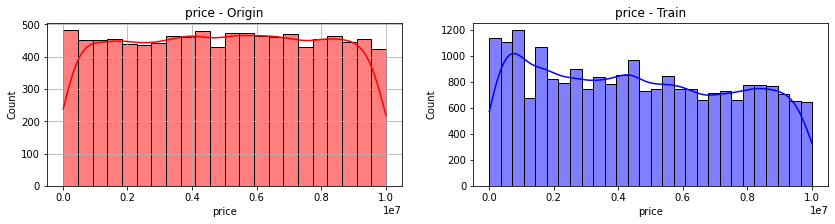

In [25]:
plt.figure(figsize=(14,3))
ax1 = plt.subplot(1,2,1)
sns.histplot(x=origin[target], color='r', kde=True)
plt.title(target + ' - Origin')
plt.grid()
ax2 = plt.subplot(1,2,2)
sns.histplot(x=train[target], color='b', kde=True)
plt.title(target + ' - Train')
plt.show()

# 가격대의 분포가 다양하는 것을 보아 여러 가격대가 있는 것으로 보인다.

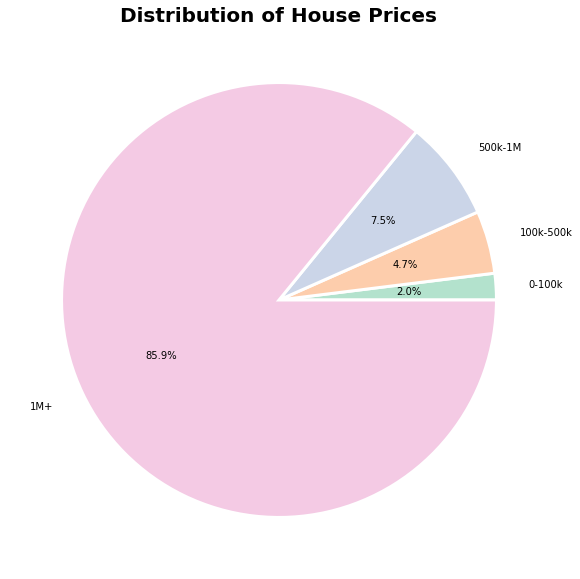

In [26]:
# 앞 선 histplot를 통해서 가격대를 10,50,100만대로 나눠서 확인

plt.figure(figsize=(15, 10))
bins = [0, 100000, 500000,1000000, train['price'].max()]
labels = ['0-100k', '100k-500k','500k-1M', '1M+']
train['price_range'] = pd.cut(train['price'], bins=bins, labels=labels)


plt.pie(train['price_range'].value_counts().sort_values(),autopct='%.1f%%',labels=labels,colors=sns.color_palette('Pastel2'),labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

plt.title("Distribution of House Prices",fontdict={'fontweight':'bold','fontsize':20})

plt.show()

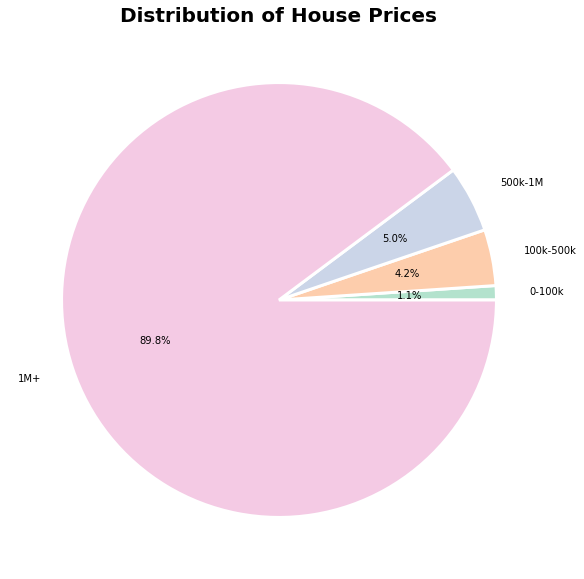

In [27]:
plt.figure(figsize=(15, 10))
bins = [0, 100000, 500000,1000000, origin['price'].max()]
labels = ['0-100k', '100k-500k','500k-1M', '1M+']
origin['price_range'] = pd.cut(origin['price'], bins=bins, labels=labels)


plt.pie(origin['price_range'].value_counts().sort_values(),autopct='%.1f%%',labels=labels,colors=sns.color_palette('Pastel2'),labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

plt.title("Distribution of House Prices",fontdict={'fontweight':'bold','fontsize':20})

plt.show()
# 대부분 집값이 백만이상이다.

## Displot

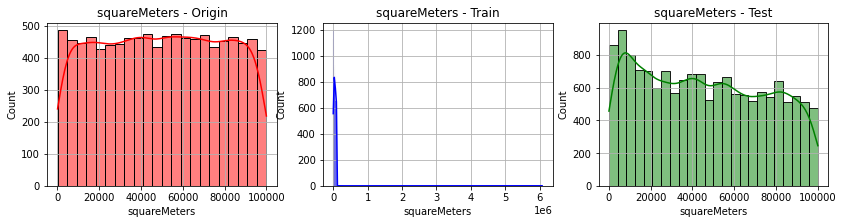

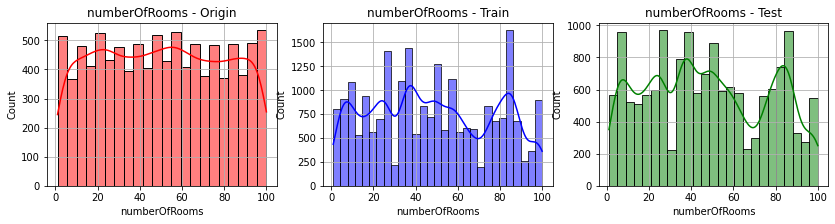

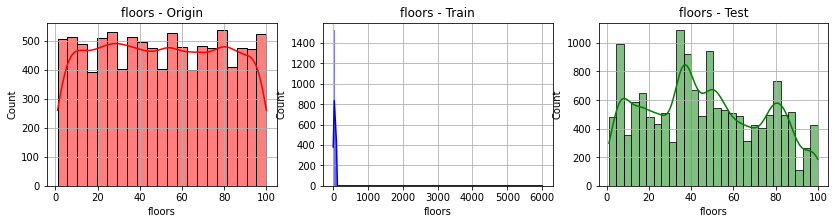

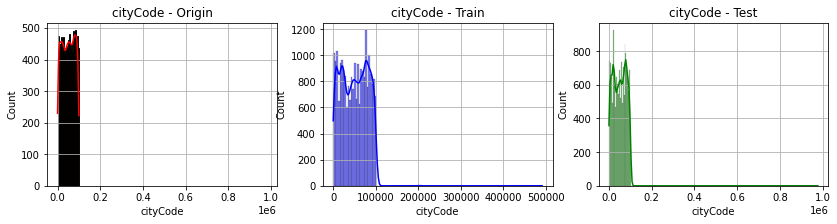

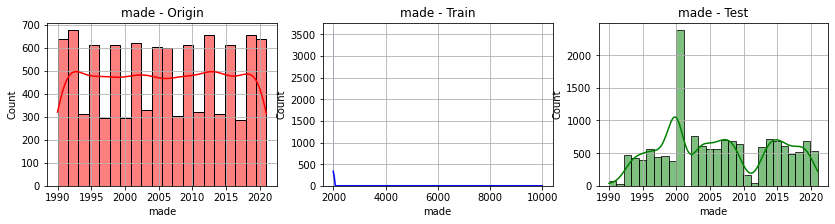

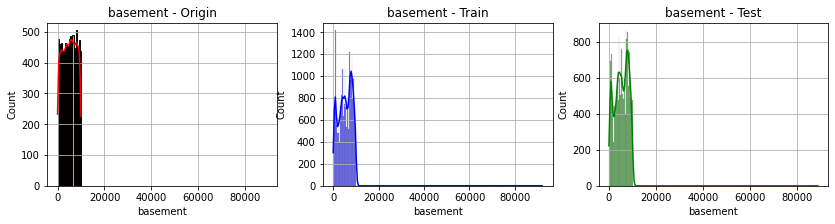

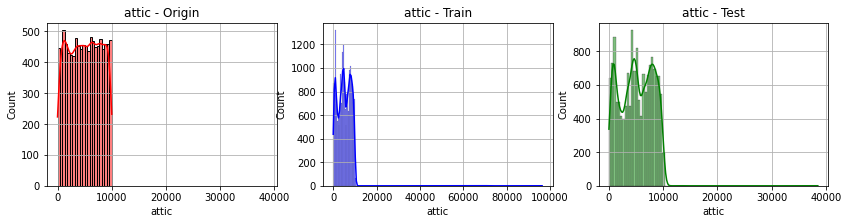

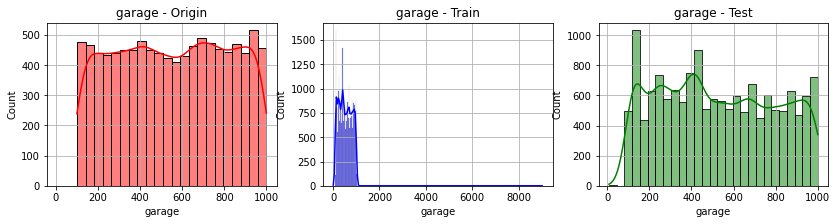

In [28]:
for f in features_cont:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.histplot(x=origin[f], color='r', kde=True)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.histplot(x=train[f], color='b', kde=True)
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3, sharex=ax1)
  sns.histplot(x=test[f],color='g', kde=True)
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 확인 시 train,test에서 비대칭(skewed) 데이터가 보인다. -> Skewed Data https://dining-developer.tistory.com/18

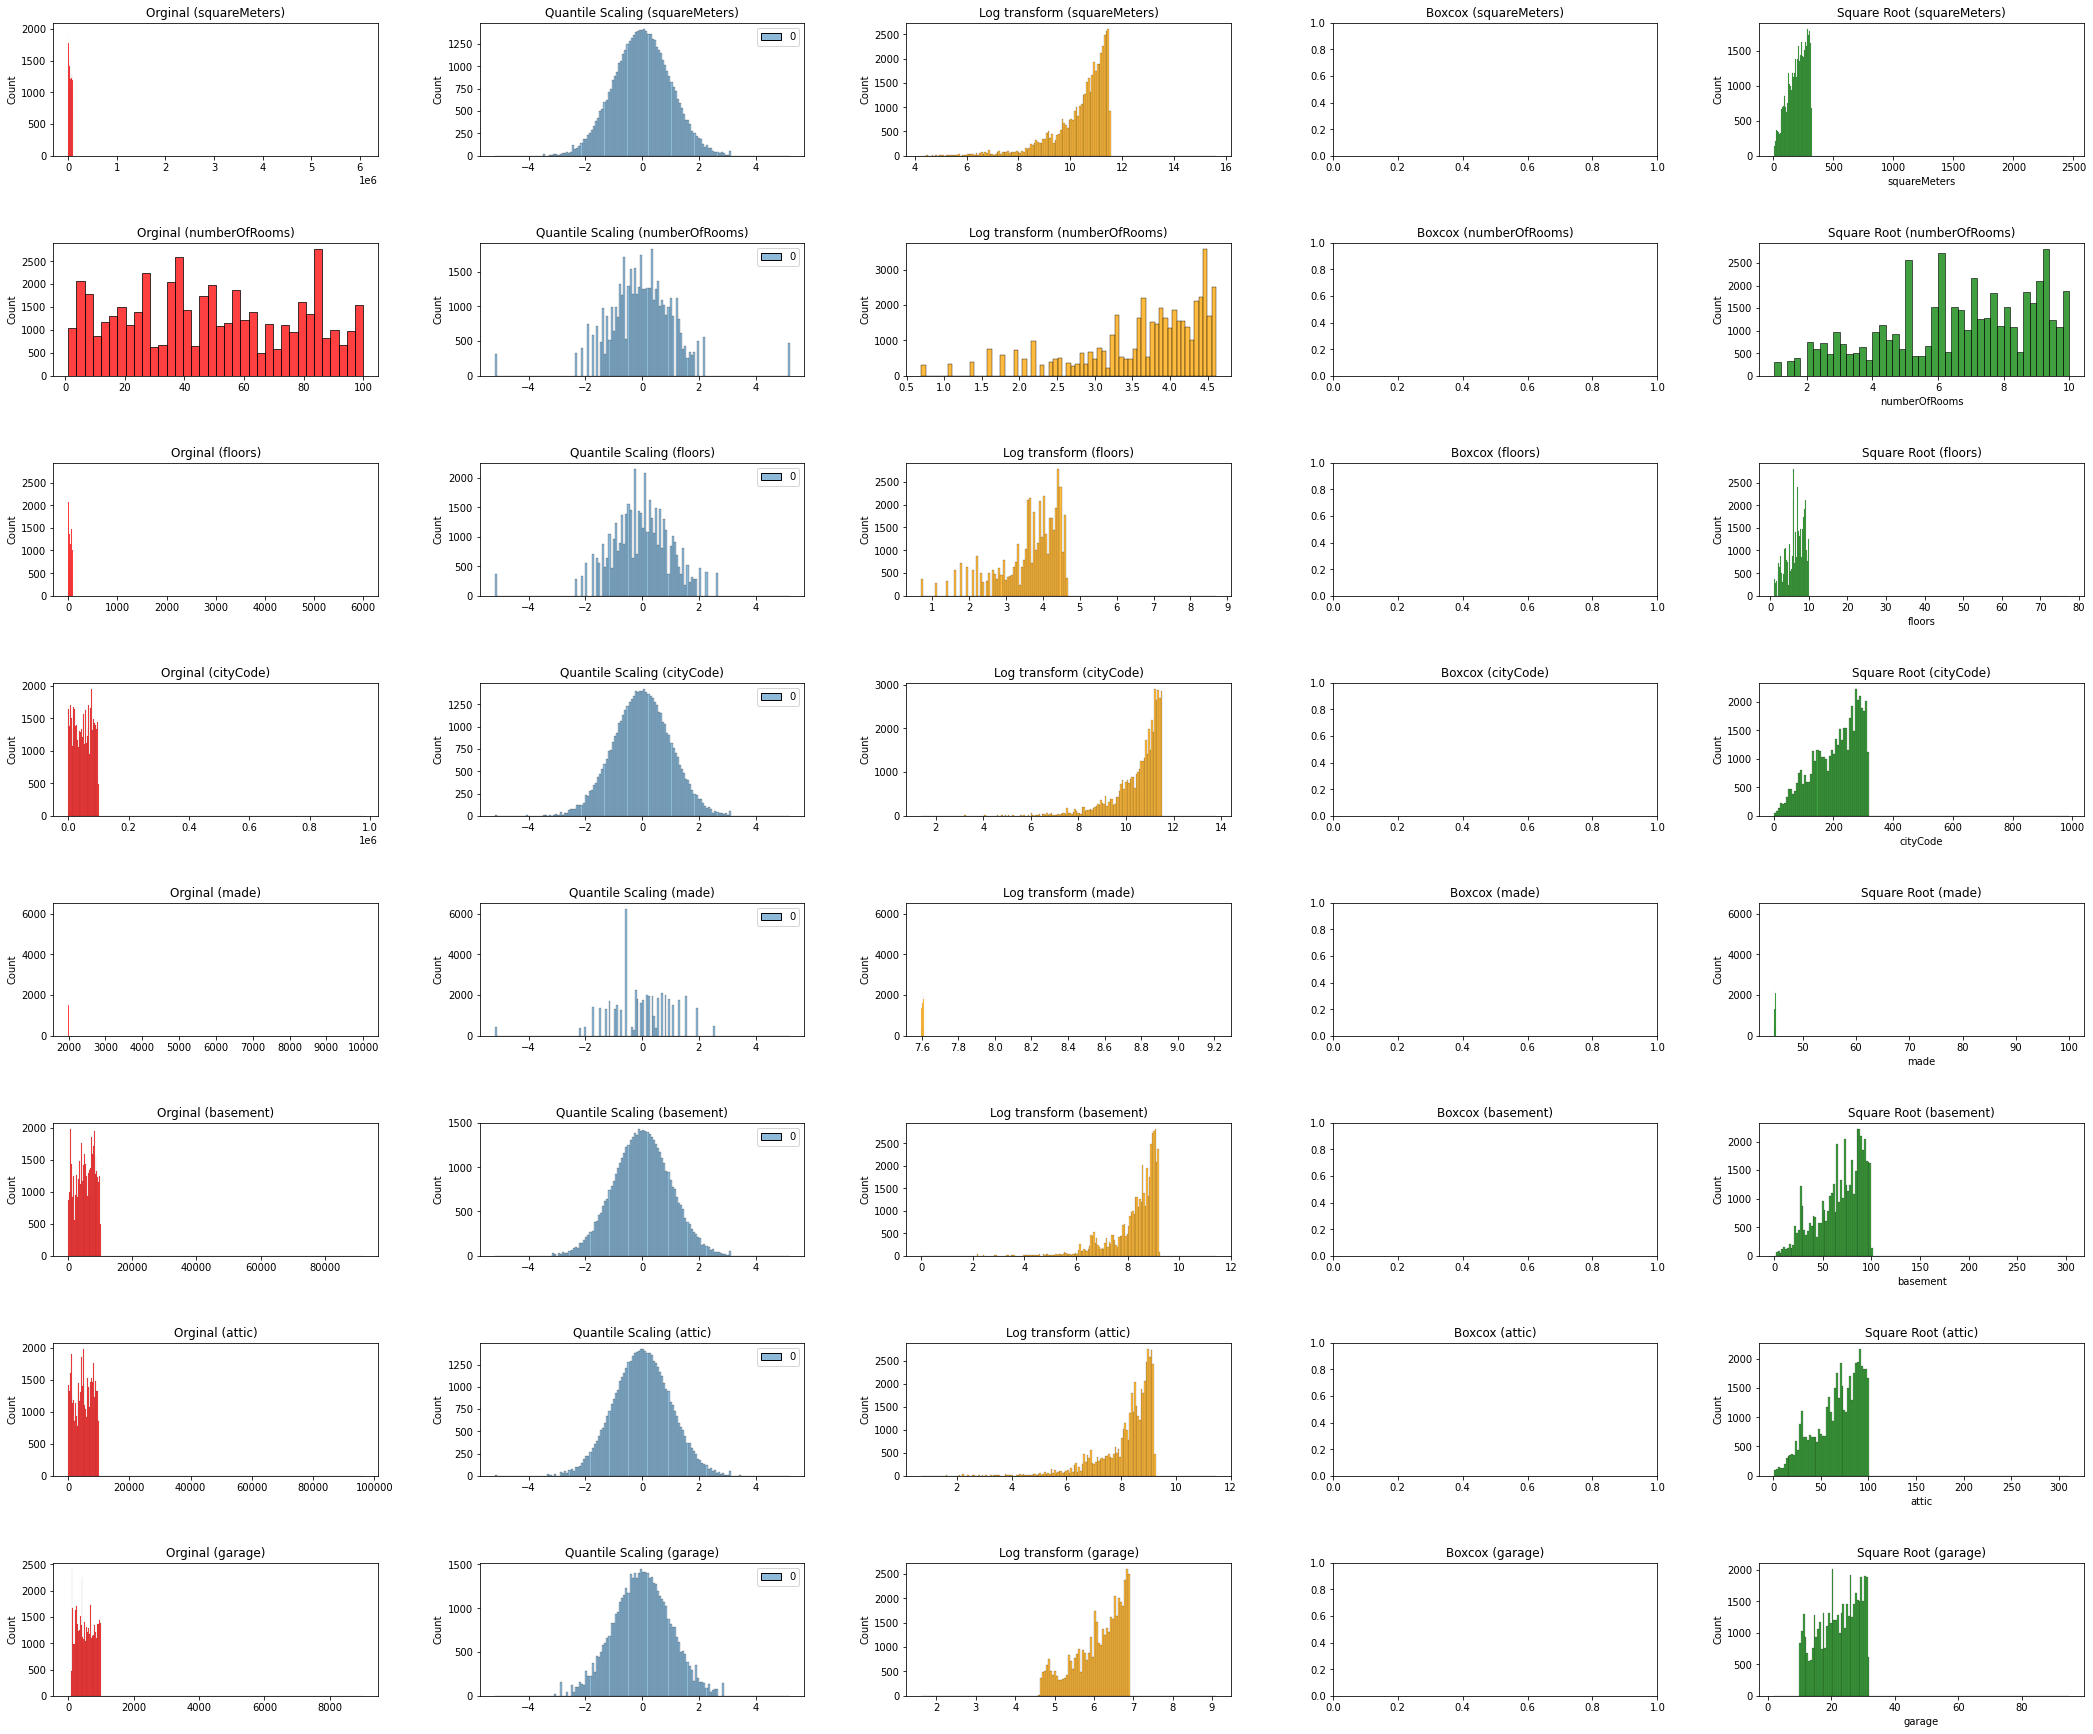

In [29]:
# 위에서 보인 비대칭 피처를 변환시키기 위해서는 어떤 방식으로 해야 될까
# 참고 : https://www.kaggle.com/code/slythe/1-eda-model-selection-pse3e6-regression

from scipy.stats import boxcox, median_abs_deviation 
from sklearn.preprocessing import QuantileTransformer

all_data = pd.concat([origin,train,test], ignore_index=True)

fig, axes = plt.subplots(len(features_cont),5, figsize = (30,25))

for i,col in enumerate(features_cont):
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(all_data[[col]])

    sns.histplot(x= all_data[col],ax= axes[i,0], color = "r")
    sns.histplot(quant_df,ax= axes[i,1] )
    sns.histplot(np.log1p(all_data[col]), ax = axes[i,2], color= "orange")

    try:
        sns.histplot(boxcox(all_data[col], 0.15)[0], ax = axes[i,3], color= "orange")

    except:
        pass

    sns.histplot(np.sqrt(all_data[col]), ax = axes[i,4], color= "green")

    axes[i,0].set_title(f"Orginal ({col})")
    axes[i,0].set(xlabel=None)
    axes[i,1].set_title(f"Quantile Scaling ({col})")
    axes[i,2].set_title(f"Log transform ({col})")
    axes[i,2].set(xlabel=None)
    axes[i,3].set_title(f"Boxcox ({col})")
    axes[i,4].set_title(f"Square Root ({col})")

plt.tight_layout(pad = 4)
plt.show()

# 확인 시 Quantile Scaling를 사용 시 정규분포 형태에 가까워 진다는 것을 알 수 있었다.

## Boxplot

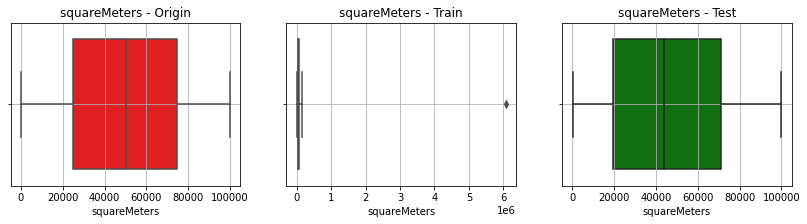

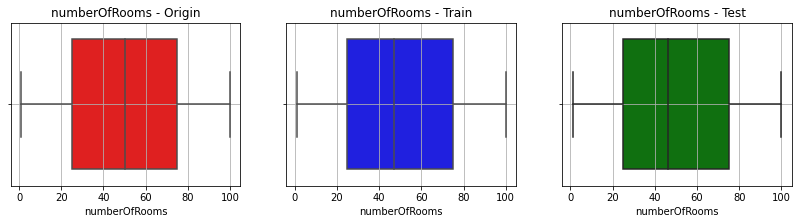

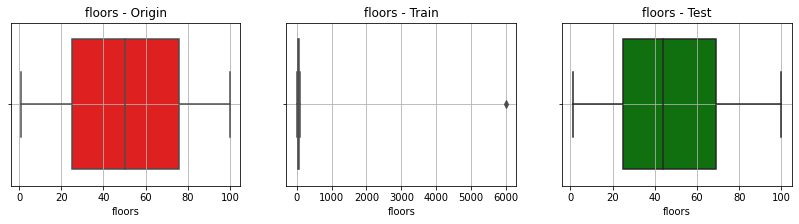

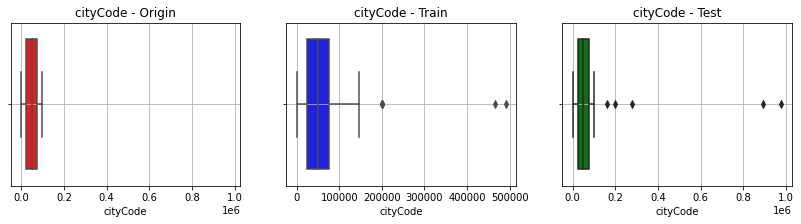

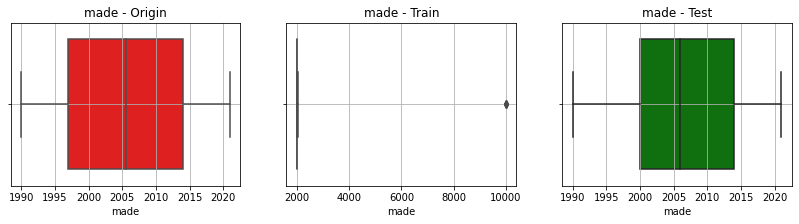

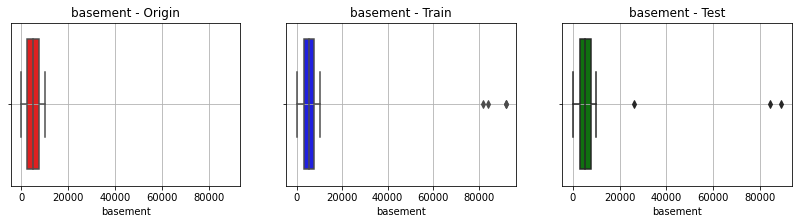

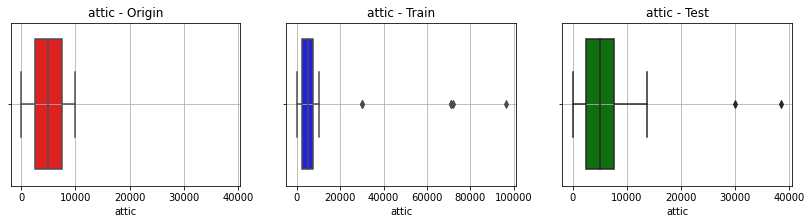

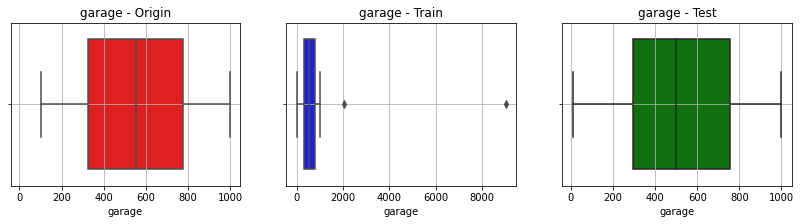

In [30]:
for f in features_cont:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.boxplot(x=origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.boxplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3, sharex=ax1)
  sns.boxplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 원본에는 이상치 X, train/test이상치가 존재하는 것이 확인 -> squareMeter, floors, citycode, made, basement, attic, garage
# 다만 test 데이터 셋에서는 citycode, basement, attic 만 해당 됨 

## Countplot 

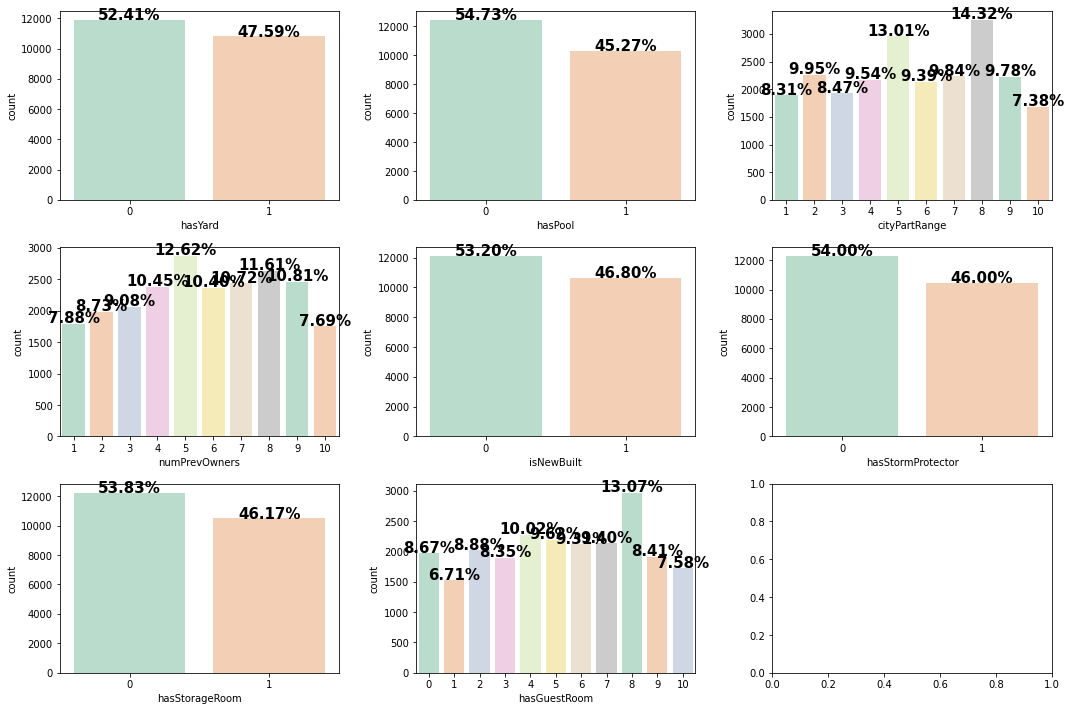

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for i, column in enumerate(features_cat):
    sns.countplot(x=train[column], ax=axes[i],palette='Pastel2')
    for j in axes[i].patches:
        height = j.get_height()
        axes[i].text(j.get_x() + j.get_width() / 2.,
                height + 20,
                '{:1.2f}%'.format(height / len(train) * 100),
                ha="center", fontsize=15,fontweight='bold')

plt.tight_layout()
plt.show()

## ScatterPlot

- **이상치 제거후 확인 시 선형관계 확인 가능**

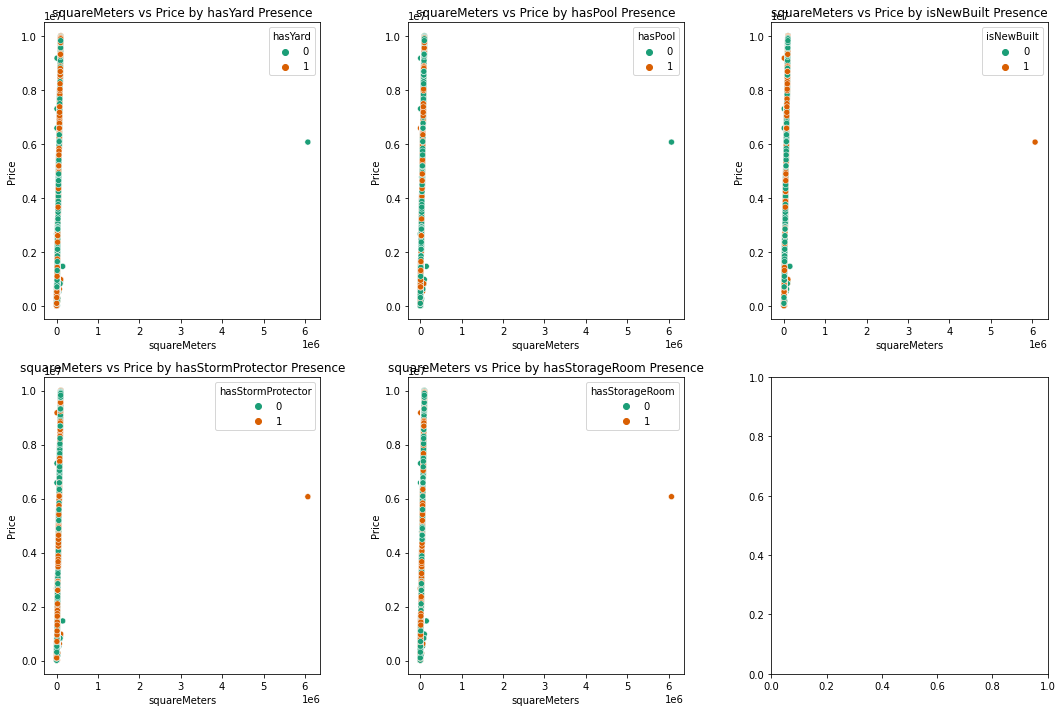

In [32]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()

for i, column in enumerate(features_bin ):
    sns.scatterplot( x= train['squareMeters'], y=train['price'], hue = train[column], ax=axs[i],palette='Dark2')
    axs[i].set_title('squareMeters vs Price by '+ column +' Presence')
    axs[i].set_xlabel('squareMeters')
    axs[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

## Regplot

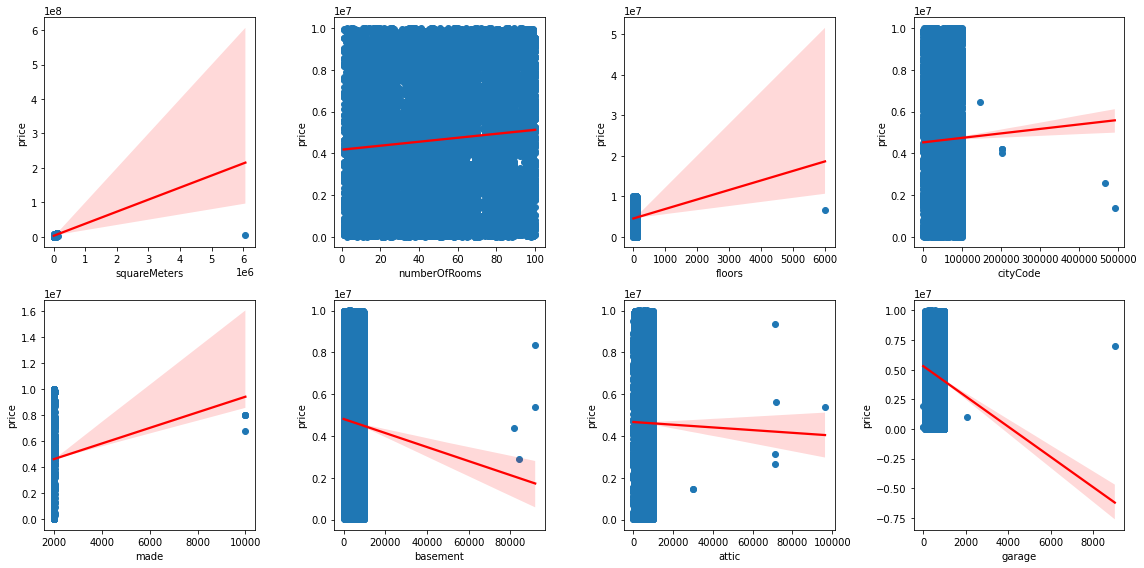

In [33]:
fig, axes = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

for i, feature in enumerate(features_cont):
    row = int(i/4) 
    col = int(i%4)
    sns.regplot(x=feature,y='price',data=train, ax=axes[row][col], line_kws={'color':'red'}, scatter_kws={'alpha':1.0})

plt.tight_layout()
plt.show()

# 연속형 확인 시 squareMeters, floor, made가 어느정도 선형이 보임

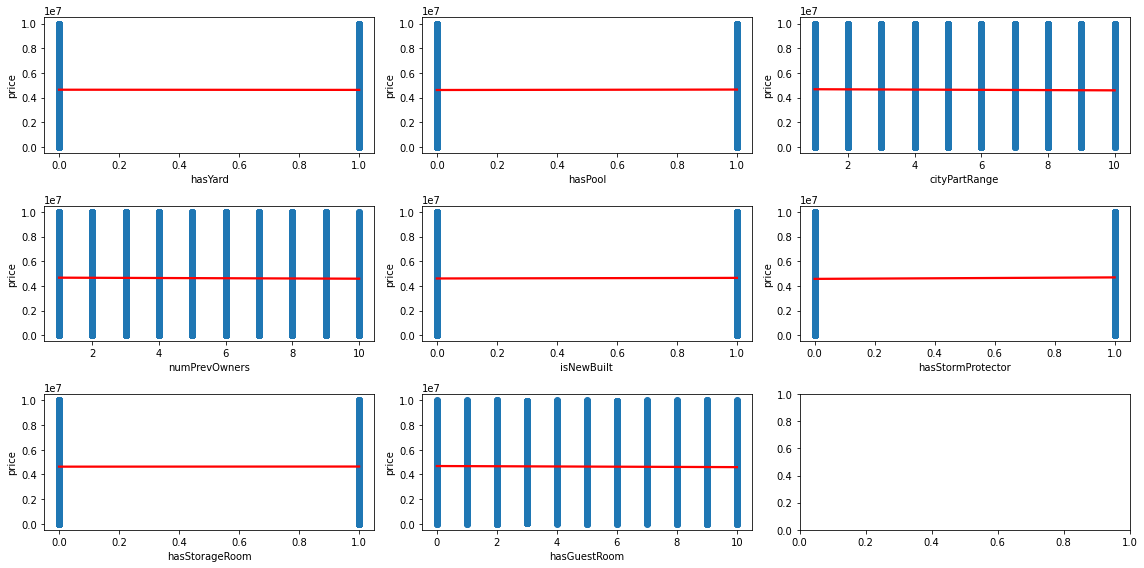

In [34]:
fig, axes = plt.subplots(figsize=(16,8), ncols=3, nrows=3)

for i, feature in enumerate(features_cat):
    row = int(i/3) 
    col = int(i%3)
    sns.regplot(x=feature, y='price',data=train, ax=axes[row][col], line_kws={'color':'red'}, scatter_kws={'alpha':1.0})
    
plt.tight_layout()
plt.show()

## Heatmap

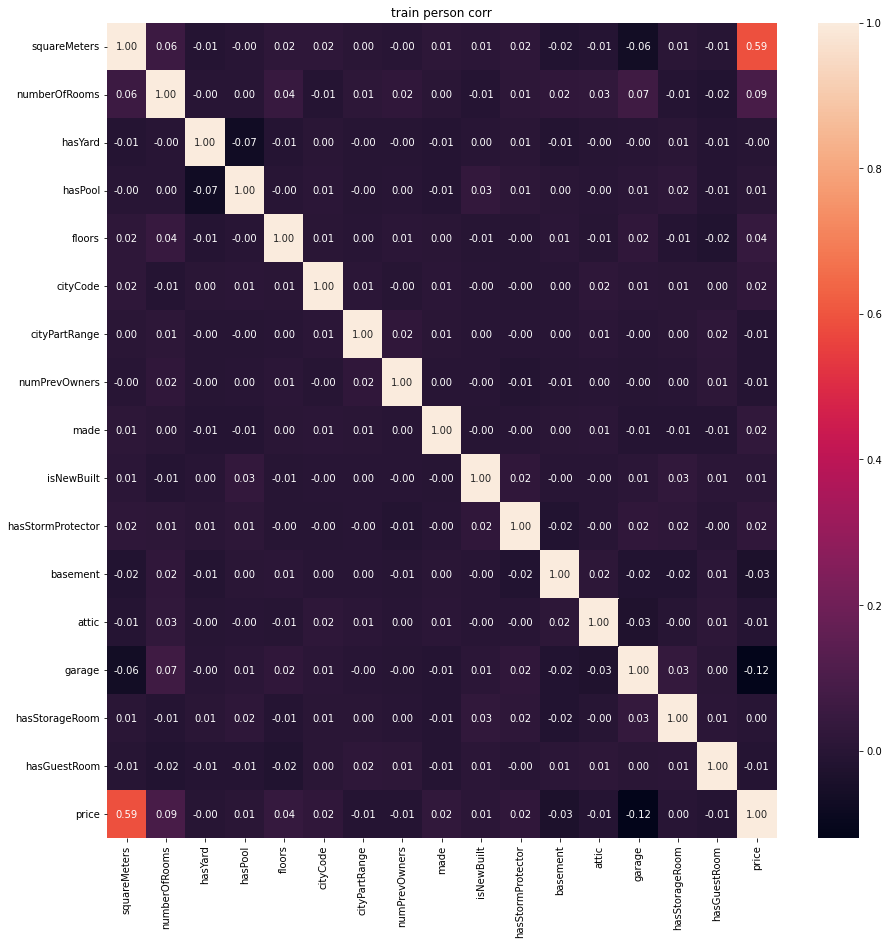

In [35]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("train person corr")
plt.show()

# squareMeter를 제외하고 대부분 약한 상관관계를 가지고 있다.

# EDA 결과

- origin/train/test 데이터 셋에서는 결측치는 X 
- Boxplot 확인 시, train/test 데이터 셋에서 이상치는 다음과 같다 : squareMeters, floors, cityCode, made, basement, attic, garage는 
- Heatmap 확인 시 squaremeter 제외하고 다 약한 상관관계를 가지고 있다.
- Regplot 확인 시, basement, attic, garage는 price을 예측 시 도움이 되지 않는다


# 피처 엔지니어링

In [36]:
# 기본 패키지 도구 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 데이터 경로
path = '/content/drive/MyDrive/cloud_ai/모듈_프로젝트_2/ep.6/'

origin = pd.read_csv(path + 'ParisHousing.csv')
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

origin.shape, train.shape, test.shape, submission.shape

((10000, 17), (22730, 18), (15154, 17), (15154, 2))

In [37]:
train = train.drop('id', axis=1)
test = test.drop('id',axis=1)

In [38]:
origin.shape, train.shape, test.shape, submission.shape

((10000, 17), (22730, 17), (15154, 16), (15154, 2))

## 이상치 탐지 

- 앞 선 boxplot을 통해서 이상치를 확인 할 수 있었다. -> 이상치가 있는 특성만 따로 뽑아서 확인
  -  함수화 처리 참고 :  [IQR을 이용하여 이상치를 탐색하고 처리하기](https://hong-yp-ml-records.tistory.com/15)

In [39]:
# 이상치 탐지 ( 전체 부분 )
from collections import Counter

features_out = ['squareMeters', 'floors', 'cityCode', 'made', 'basement', 'attic', 'garage']

def detect_outliers(df,features):
    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    print(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items())
    
        
    return multiple_outliers

In [40]:
Outliers_to_drop = detect_outliers(train, features_out)
print(f'이상치 총 개수 {len(Outliers_to_drop)} 개')
train.loc[Outliers_to_drop] 
# iqr 방식으로 모든 이상치를 확인 

Counter({15334: 1, 5659: 1, 299: 1, 1326: 1, 2425: 1, 10987: 1, 20735: 1, 22631: 1, 2113: 1, 3608: 1, 19124: 1, 19748: 1, 21400: 1, 2107: 1, 3995: 1, 15068: 1, 18926: 1, 3828: 1, 4909: 1, 12858: 1, 13633: 1, 13642: 1, 17168: 1, 19994: 1, 14878: 1, 17629: 1})
이상치 총 개수 26 개


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
15334,6071330,64,0,0,5,86523,10,8,2019,1,1,6361,2412,874,1,5,6071330.9
5659,65029,50,0,1,6000,79146,4,5,2012,0,1,5123,230,668,0,4,6507042.1
299,40200,44,1,1,19,201035,5,4,2006,0,0,2538,7437,985,0,0,4028239.6
1326,13591,6,0,1,20,491100,5,9,2000,0,1,8747,5840,675,0,8,1367021.0
2425,25594,35,1,0,50,465360,6,8,1997,0,0,4774,8779,612,1,4,2564288.7
10987,42211,78,0,1,52,200812,7,10,2008,0,1,7645,9349,902,0,0,4230896.8
20735,42211,85,1,1,34,200801,8,7,2008,0,0,8434,9238,798,1,9,4230896.8
22631,42211,84,0,0,56,200801,7,3,2008,0,1,9845,8224,985,1,10,4230896.8
2113,68038,41,0,0,54,87120,3,6,10000,1,1,6537,6304,366,0,0,6807415.1
3608,80062,81,1,0,35,67157,9,4,10000,0,1,732,6475,758,0,4,8007951.1


In [41]:
## 이상치 전부 제거 -> 오히려 떨어짐
#train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [42]:
Outliers_to_drop2 = detect_outliers(test, features_out)
print(f'이상치 총 개수 {len(Outliers_to_drop2)} 개')
test.loc[Outliers_to_drop2] 

# 테스트 셋 기준, iqr 방식으로 이상치는 cityCode, basement, attic에 있음 -> 제거 X 

Counter({4987: 1, 6503: 1, 8215: 1, 10525: 1, 13111: 1, 696: 1, 1789: 1, 11191: 1, 2838: 1, 9148: 1})
이상치 총 개수 10 개


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
4987,42211,51,0,1,13,200801,2,8,2008,1,0,874,9238,796,0,10
6503,95894,34,1,1,7,889795,6,9,2005,0,1,7381,75,582,0,6
8215,68824,8,0,1,34,977950,4,5,1990,0,0,6044,2097,665,1,7
10525,18368,22,0,1,71,279019,8,10,2000,0,1,6133,6642,289,1,4
13111,33156,35,1,0,77,162019,5,5,1994,0,0,1285,5075,814,1,6
696,28600,84,1,0,85,598,5,9,2017,1,1,26132,4831,874,1,7
1789,44838,49,0,1,85,19691,5,9,2009,0,0,84333,8252,865,0,2
11191,43906,58,0,0,79,98779,6,1,2013,1,1,89016,4409,675,0,5
2838,47982,81,1,1,38,52650,1,7,1994,1,1,9727,38535,327,1,10
9148,14588,39,0,1,2,35318,5,7,2003,0,0,3333,30000,357,1,4


In [43]:
# 이상치 탐지 함수 ( 특징 하나 씩 보도록 변경 )

def detect_outlier(df,feature):
  
  Q1 = np.percentile(df[feature], 25)
  Q3 = np.percentile(df[feature], 75)
  IQR = Q3 - Q1
        
  outlier_step = 1.5 * IQR
  
  return df[(df[feature] < Q1 - outlier_step) | (df[feature] > Q3 + outlier_step)]

#### squareMeters ( 방 면적 넓이 )
- Insight
  - [면적순 나라 목록](https://ko.wikipedia.org/wiki/%EB%A9%B4%EC%A0%81%EC%88%9C_%EB%82%98%EB%9D%BC_%EB%AA%A9%EB%A1%9D) 기준으로 보면 나라의 크기를 나타냄 -> <u>이상치 확실</u>
    - 6071330m^2 : 1836577.33 평 [ 평수 계산기 사용 시 ]


In [44]:
detect_outlier(train,'squareMeters')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
15334,6071330,64,0,0,5,86523,10,8,2019,1,1,6361,2412,874,1,5,6071330.9


In [45]:
train.squareMeters.sort_values(ascending=False)
# 확인 시 2개가 이상치가 있음

15334    6071330
4741      146181
17330      99985
14864      99985
5261       99985
          ...   
2356          89
14879         89
12130         89
14314         89
13338         89
Name: squareMeters, Length: 22730, dtype: int64

In [46]:
train[train['squareMeters'] > 146180]

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
4741,146181,38,0,0,88,10837,6,7,2000,0,0,5953,8529,1000,0,10,1468435.1
15334,6071330,64,0,0,5,86523,10,8,2019,1,1,6361,2412,874,1,5,6071330.9


In [47]:
# 최대치로 대체
train.loc[train.index.isin([4741]), 'squareMeters'] = 99985

In [48]:
# 15334번 같은 경우, squareMeters = price가 같음 -> 이상치 확실
train = train[train['squareMeters'] < 100000]

In [49]:
train.squareMeters.sort_values(ascending=False)

5261     99985
4741     99985
17330    99985
13686    99985
14864    99985
         ...  
14314       89
14879       89
13338       89
19926       89
6655        89
Name: squareMeters, Length: 22729, dtype: int64

#### floors ( 층 수 )
- Insight
  - [런던·파리·뉴욕… 세계도 건물 높이 규제](https://www.seouland.com/arti/society/society_general/1609.html) 확인 시 최대 높이 기준 : 1973년 200m가 넘는 몽파르나스 타워(59층) ->  59층 이상도 이상치 인가? -> 확인 필요
  - Boxplot 확인 시 현재 존재하는 건물 들 중 6000층은 말이 안됨 -> <u>이상치 확실</u> 

In [50]:
# train[train.floors > 59]
# 데이터가 제거 시 데이터가 너무 적어짐 ->  방식 X

In [51]:
detect_outlier(train,'floors')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
5659,65029,50,0,1,6000,79146,4,5,2012,0,1,5123,230,668,0,4,6507042.1


In [52]:
train.loc[train.index.isin([5659]), 'floors'] = 100

In [53]:
train.floors.sort_values(ascending=False)

19957    100
1456     100
15969    100
4812     100
6200     100
        ... 
4675       1
22377      1
16173      1
12783      1
14958      1
Name: floors, Length: 22729, dtype: int64

### CityCode ( 도시 코드 )

- [cityCode is Fake!](https://www.kaggle.com/competitions/playground-series-s3e6/discussion/384676) 
  - 임의로 만들어진 특성이므로 의미가 없다고 함 -> 열 자체 삭제 권장

In [54]:
detect_outlier(train,'cityCode')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
299,40200,44,1,1,19,201035,5,4,2006,0,0,2538,7437,985,0,0,4028239.6
1326,13591,6,0,1,20,491100,5,9,2000,0,1,8747,5840,675,0,8,1367021.0
2425,25594,35,1,0,50,465360,6,8,1997,0,0,4774,8779,612,1,4,2564288.7
10987,42211,78,0,1,52,200812,7,10,2008,0,1,7645,9349,902,0,0,4230896.8
20735,42211,85,1,1,34,200801,8,7,2008,0,0,8434,9238,798,1,9,4230896.8
22631,42211,84,0,0,56,200801,7,3,2008,0,1,9845,8224,985,1,10,4230896.8


### made (제작년도) 

- 데이터 셋 기준 확인 시, 2021년도 기준으로 초과 시 미래 시간 (존재하지 않음) -> <u>이상치 확실</u>
- 또한 2002년 부분이 하나만 있으므로, made의 평균으로 대체

In [55]:
train.made.value_counts().sort_index()

1990       77
1991       30
1992       59
1993      651
1994      628
1995      631
1996      822
1997      592
1998      719
1999      588
2000     3588
2001       59
2002        1
2003     1156
2004      915
2005      764
2006      921
2007     1021
2008      981
2009      972
2010      152
2011       68
2012       51
2013      934
2014     1070
2015     1036
2016      910
2017      741
2018      927
2019      955
2020      595
2021      110
10000       5
Name: made, dtype: int64

In [56]:
test.made.value_counts().sort_index()

1990      62
1991      17
1992      30
1993     464
1994     425
1995     402
1996     560
1997     447
1998     460
1999     385
2000    2337
2001      40
2002       1
2003     765
2004     602
2005     558
2006     565
2007     699
2008     682
2009     634
2010     128
2011      36
2012      50
2013     592
2014     711
2015     680
2016     605
2017     480
2018     520
2019     685
2020     445
2021      87
Name: made, dtype: int64

In [57]:
train[train['made'] == 2002]

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
8337,86383,95,0,0,8,98660,3,10,2002,1,1,4118,4349,877,1,7,8648031.0


In [58]:
test[test['made'] == 2002]

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
7912,67735,63,0,1,9,42204,4,7,2002,0,1,823,8144,735,1,7


In [59]:
mean_train_made = train['made'].mean()
print(mean_train_made)
mean_test_made = test['made'].mean()
print(mean_train_made)

2008.0045756522504
2008.0045756522504


In [60]:
train.loc[train.index.isin([8337]), 'made'] = 2008
test.loc[test.index.isin([7912]), 'made'] = 2008

In [61]:
detect_outlier(train,'made')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
2113,68038,41,0,0,54,87120,3,6,10000,1,1,6537,6304,366,0,0,6807415.1
3608,80062,81,1,0,35,67157,9,4,10000,0,1,732,6475,758,0,4,8007951.1
19124,80062,52,0,0,84,67099,9,4,10000,0,0,7677,5017,148,0,4,8007951.1
19748,80062,58,0,1,86,40408,7,8,10000,0,0,7059,7307,287,0,2,8007951.1
21400,80062,78,0,0,84,59457,4,7,10000,1,0,6382,9507,298,1,4,8007951.1


In [62]:
train.loc[train.index.isin([2113,3608,19124,19748,21400]), 'made'] = 2021

In [63]:
train.made.sort_values(ascending=False)

19064    2021
11366    2021
17800    2021
11517    2021
15117    2021
         ... 
13766    1990
21915    1990
21563    1990
8735     1990
4201     1990
Name: made, Length: 22729, dtype: int64

### basement( 지하실 면적 넓이 )

In [64]:
detect_outlier(train,'basement')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
2107,28956,100,0,1,35,39767,6,9,2000,0,1,84333,8777,655,0,1,2898953.1
3995,43758,14,0,0,93,62528,3,9,2008,0,0,81851,9179,243,0,2,4385098.8
15068,83358,35,1,0,83,22449,9,2,2015,0,0,91992,299,897,0,0,8341911.5
18926,53671,55,0,1,85,6249,7,6,2017,0,1,91978,959,515,1,2,5378022.7


In [65]:
detect_outlier(test,'basement')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
696,28600,84,1,0,85,598,5,9,2017,1,1,26132,4831,874,1,7
1789,44838,49,0,1,85,19691,5,9,2009,0,0,84333,8252,865,0,2
11191,43906,58,0,0,79,98779,6,1,2013,1,1,89016,4409,675,0,5


In [66]:
train.basement.sort_values(ascending=False)[:10]

15068    91992
18926    91978
2107     84333
3995     81851
816      10000
352      10000
21159    10000
4362     10000
18396    10000
8824     10000
Name: basement, dtype: int64

In [67]:
test.basement.sort_values(ascending=False)[:10]

11191    89016
1789     84333
696      26132
5048     10000
2073     10000
6748     10000
4892     10000
2733     10000
10189    10000
7414     10000
Name: basement, dtype: int64

In [68]:
train.loc[train.index.isin([2107,3995,15068,18926]), 'basement'] = 10000
test.loc[test.index.isin([696,1789,11191]), 'basement'] = 10000

In [69]:
train.basement.sort_values(ascending=False)[:10]

19389    10000
3995     10000
816      10000
352      10000
21159    10000
4362     10000
18396    10000
2107     10000
8824     10000
18005    10000
Name: basement, dtype: int64

In [70]:
test.basement.sort_values(ascending=False)[:10]

5048     10000
696      10000
6748     10000
4892     10000
2733     10000
10189    10000
7414     10000
2073     10000
6723     10000
10285    10000
Name: basement, dtype: int64

### attic ( 다락방 면적 넓이 )

In [71]:
detect_outlier(train,'attic')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
3828,31357,80,0,1,35,56962,9,4,2017,1,0,1284,71001,212,0,5,3141062.7
4909,26484,33,0,1,37,83634,5,3,1997,1,1,774,71001,663,0,1,2654798.7
12858,93278,41,1,1,56,46600,9,8,2015,0,1,4145,71024,473,0,3,9339538.5
13633,53708,81,0,0,84,12841,7,6,2006,1,1,759,96381,860,1,8,5378041.6
13642,14588,36,0,0,16,3578,5,2,2003,0,1,5361,30000,357,0,4,1459601.3
17168,56147,100,0,0,35,79570,7,7,2016,1,1,9631,71965,973,0,6,5621340.6
19994,14588,43,1,0,23,38270,10,7,2003,0,1,9789,30000,177,1,4,1459601.3


In [72]:
detect_outlier(test,'attic')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
2838,47982,81,1,1,38,52650,1,7,1994,1,1,9727,38535,327,1,10
9148,14588,39,0,1,2,35318,5,7,2003,0,0,3333,30000,357,1,4


In [73]:
train.attic.sort_values(ascending=False)[:10]

13633    96381
17168    71965
12858    71024
4909     71001
3828     71001
19994    30000
13642    30000
9864     10000
5991     10000
2014     10000
Name: attic, dtype: int64

In [74]:
test.attic.sort_values(ascending=False)[:10]

2838     38535
9148     30000
14769    13779
4892     10000
11506    10000
81       10000
10517     9999
11438     9985
6801      9985
13885     9985
Name: attic, dtype: int64

In [75]:
train.loc[train.index.isin([3828,4909,12858,13633,13642,17168,19994]), 'attic'] = 10000
test.loc[test.index.isin([2838,9148,14769]), 'attic'] = 10000

In [76]:
train.attic.sort_values(ascending=False)[:10]

14162    10000
13633    10000
5991     10000
2014     10000
9115     10000
13347    10000
4909     10000
17168    10000
8956     10000
9864     10000
Name: attic, dtype: int64

In [77]:
test.attic.sort_values(ascending=False)[:10]

4892     10000
11506    10000
2838     10000
81       10000
14769    10000
9148     10000
10517     9999
11438     9985
6801      9985
13885     9985
Name: attic, dtype: int64

### garage ( 주차 공간 크기 )

In [78]:
detect_outlier(train,'garage')

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
14878,10380,44,0,0,41,40504,1,4,2020,0,0,8876,803,2048,0,2,1049793.1
17629,70409,86,0,0,90,85476,5,6,2000,1,0,2522,9057,9017,1,3,7042999.2


In [79]:
train.garage.sort_values(ascending=False)[:10]

17629    9017
14878    2048
7458     1000
11892    1000
4391     1000
5525     1000
21171    1000
6940     1000
18329    1000
7696     1000
Name: garage, dtype: int64

In [80]:
train.loc[train.index.isin([14878,17629]), 'garage'] = 1000

In [81]:
train.garage.sort_values(ascending=False)[:10]

7458     1000
11892    1000
2996     1000
4391     1000
5525     1000
21171    1000
14878    1000
6940     1000
18329    1000
7696     1000
Name: garage, dtype: int64

## 데이터 합치기 -- 중간과정

In [ ]:
all_data = pd.concat([origin,train,test], ignore_index=True)
all_data

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47878,86184,74,1,1,73,14009,2,10,1993,1,0,3714,3894,665,1,1,NaN
47879,45885,41,1,1,64,84208,4,5,2008,0,0,783,7628,976,0,0,NaN
47880,73554,51,0,0,41,49263,10,5,2004,0,1,8207,1777,775,0,10,NaN
47881,77604,51,0,1,33,67056,4,3,2019,0,0,9578,9706,135,0,2,NaN


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47883 entries, 0 to 47882
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       47883 non-null  int64  
 1   numberOfRooms      47883 non-null  int64  
 2   hasYard            47883 non-null  int64  
 3   hasPool            47883 non-null  int64  
 4   floors             47883 non-null  int64  
 5   cityCode           47883 non-null  int64  
 6   cityPartRange      47883 non-null  int64  
 7   numPrevOwners      47883 non-null  int64  
 8   made               47883 non-null  int64  
 9   isNewBuilt         47883 non-null  int64  
 10  hasStormProtector  47883 non-null  int64  
 11  basement           47883 non-null  int64  
 12  attic              47883 non-null  int64  
 13  garage             47883 non-null  int64  
 14  hasStorageRoom     47883 non-null  int64  
 15  hasGuestRoom       47883 non-null  int64  
 16  price              327

In [ ]:
all_data.nunique().sort_values()

hasYard                  2
hasPool                  2
hasStorageRoom           2
isNewBuilt               2
hasStormProtector        2
cityPartRange           10
numPrevOwners           10
hasGuestRoom            11
made                    32
numberOfRooms          100
floors                 100
garage                 903
attic                 6757
basement              6856
squareMeters          9822
price                10000
cityCode             10581
dtype: int64

In [ ]:
all_data.isnull().sum()

squareMeters             0
numberOfRooms            0
hasYard                  0
hasPool                  0
floors                   0
cityCode                 0
cityPartRange            0
numPrevOwners            0
made                     0
isNewBuilt               0
hasStormProtector        0
basement                 0
attic                    0
garage                   0
hasStorageRoom           0
hasGuestRoom             0
price                15154
dtype: int64

In [ ]:
all_data.shape,all_data.drop_duplicates().shape

((47883, 17), (47882, 17))

## 파생 피처 생성 ( 제외 )

- 현재 특성에서 모델 성능 높이기 위해서 만들어보자 ( Kaggle 토론 참고 )

  - 파리 전체 면적에서 방 면적이 차지하는 비율 어떻게 되는가?

  - 방 가로 세로 길이 ( 정사각형 기준 )

  - 현재 방 면적 넓이의 1평 
    - [Convert pyeong to square Paris foot](https://www.convertunits.com/from/pyeong/to/square+Paris+foot)

  - 방 면적 너비와 방의 수 간의 상호 작용 -> 집에서 공간이 어떻게 사용되는 가?

  - 층 수에 따른 방의 수 -> 방이 많을 수록 손님이 많이 온다 -> 기격 영향에 미치는 가? 

  - 방의 수와 마당의 존재 사이의 상호 작용 ->  야외 공간이 가격에 영향을 미치는 가?

  - 부동산이 만들어진 연도와 신축 여부 사이의 상호 작용 -> 신축 건물이 가격이 영향에 미치는 가?

  - 지하실 크기와 다락방 크기 사이의 상호 작용: 거주 시 사용할 수 있는 추가 공간이 가격이 영향이 미치는 가? 
  
  - 창고의 존재와 객실의 존재 사이의 상호 작용 -> 얼마나 많은 공간이 창고와 손님에게 할당되는가?
    
  - 날짜에서 정보 추출 -> 집의 나이, 집이 지어진 후 경과된 시간과 같은 정보를 추출

In [ ]:
# 파생 피처 생성 함수 

def feature_interaction(df):
    df['squareMeters_sqrt'] = np.sqrt(df['squareMeters'])
    df['1_square'] =  df['squareMeters'] / 31.33446
    df['allSpace'] = df['squareMeters'] + df['basement'] + df['attic']

    city_code_count = df['cityCode'].value_counts()    
    df['numHousesInCityCode'] = df['cityCode'].map(city_code_count)
    city_code_space = df.groupby('cityCode')['squareMeters'].sum()
    df['sumAllSpaceInCityCode'] = df['cityCode'].map(city_code_space)

    df['squareMeters_numRooms'] = df['squareMeters'] * df['numberOfRooms']
    df['rooms_floor'] = df['numberOfRooms'] * df['floors']
    df['rooms_Per_Floor'] = df['numberOfRooms'] / df['floors']
    
    df['room_yard_interaction'] = df['numberOfRooms'] * df['hasYard']
    df['Basement_Attic_Interaction'] = df['basement'] * df['attic']
    df['storage_guest_interaction'] = df['hasStorageRoom'] * df['hasGuestRoom']

    df['age'] = 2021 - df['made']
    df['prevOwnersPerYear'] = df['numPrevOwners'] / df['age']
    df['made_isNewBuilt'] = df['made'] * df['isNewBuilt']

    return df

In [ ]:
all_data = feature_interaction(all_data)
all_data

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,...,sumAllSpaceInCityCode,squareMeters_numRooms,rooms_floor,rooms_Per_Floor,room_yard_interaction,Basement_Attic_Interaction,storage_guest_interaction,age,prevOwnersPerYear,made_isNewBuilt
0,75523,3,0,1,63,9373,3,8,2005,0,...,108087,226569,189,0.047619,0,38838565,0,16,0.500000,0
1,80771,39,1,1,98,39381,8,6,2015,1,...,267240,3150069,3822,0.397959,39,8898708,2,6,1.000000,2015
2,55712,58,0,1,19,34457,6,8,2021,0,...,280276,3231296,1102,3.052632,0,25998324,9,0,inf,0
3,32316,47,0,0,6,27939,10,4,2012,0,...,73682,1518852,282,7.833333,0,4705919,0,9,0.444444,0
4,70429,19,1,1,90,38045,3,7,1990,1,...,111945,1338151,1710,0.211111,19,20488615,4,31,0.225806,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47878,86184,74,1,1,73,14009,2,10,1993,1,...,593966,6377616,5402,1.013699,74,14462316,1,28,0.357143,1993
47879,45885,41,1,1,64,84208,4,5,2008,0,...,413170,1881285,2624,0.640625,41,5972724,0,13,0.384615,0
47880,73554,51,0,0,41,49263,10,5,2004,0,...,1271500,3751254,2091,1.243902,0,14583839,0,17,0.294118,0
47881,77604,51,0,1,33,67056,4,3,2019,0,...,1370674,3957804,1683,1.545455,0,92964068,0,2,1.500000,0


In [ ]:
all_data.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'squareMeters_sqrt', '1_square', 'allSpace',
       'numHousesInCityCode', 'sumAllSpaceInCityCode', 'squareMeters_numRooms',
       'rooms_floor', 'rooms_Per_Floor', 'room_yard_interaction',
       'Basement_Attic_Interaction', 'storage_guest_interaction', 'age',
       'prevOwnersPerYear', 'made_isNewBuilt'],
      dtype='object')

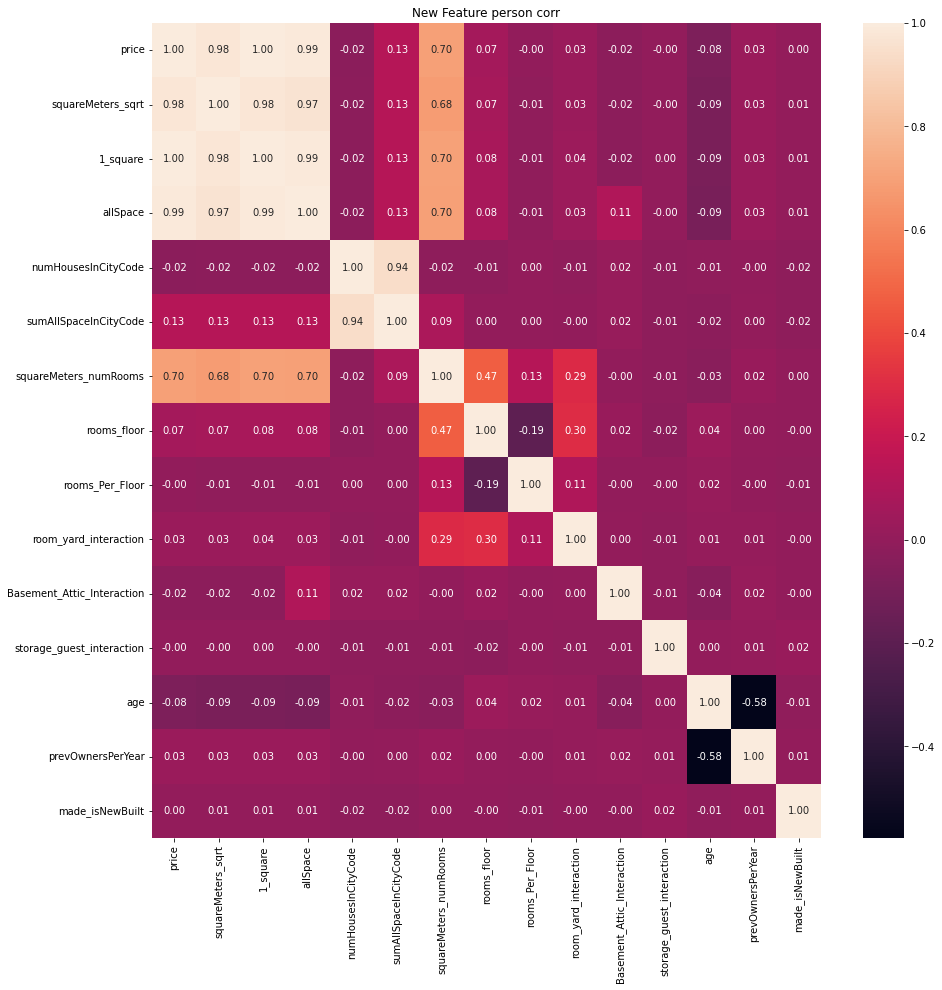

In [ ]:
new_feat = ['price', 'squareMeters_sqrt', '1_square', 'allSpace',
       'numHousesInCityCode', 'sumAllSpaceInCityCode', 'squareMeters_numRooms',
       'rooms_floor', 'rooms_Per_Floor', 'room_yard_interaction',
       'Basement_Attic_Interaction', 'storage_guest_interaction', 'age',
       'prevOwnersPerYear', 'made_isNewBuilt']

plt.figure(figsize=(15,15))
sns.heatmap(all_data[new_feat].corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("New Feature person corr")
plt.show()

# 

## 피쳐 제거 ( 제외 )

- 상관관계에서 가격 예측 시 필요한 특성만 사용하도록 하자

In [ ]:
# 앞 선 EDA결과와 상관관계에서 price 예측과 연관 없는 특성은 제거하자
feats_drop = ['cityCode','cityPartRange','squareMeters_sqrt', '1_square', 'allSpace',
       'numHousesInCityCode', 'sumAllSpaceInCityCode', 
       'rooms_Per_Floor', 'room_yard_interaction',
       'Basement_Attic_Interaction', 'storage_guest_interaction',
       'age', 'prevOwnersPerYear',
       'made_isNewBuilt']
all_data = all_data.drop(feats_drop, axis=1)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47883 entries, 0 to 47882
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   squareMeters           47883 non-null  int64  
 1   numberOfRooms          47883 non-null  int64  
 2   hasYard                47883 non-null  int64  
 3   hasPool                47883 non-null  int64  
 4   floors                 47883 non-null  int64  
 5   numPrevOwners          47883 non-null  int64  
 6   made                   47883 non-null  int64  
 7   isNewBuilt             47883 non-null  int64  
 8   hasStormProtector      47883 non-null  int64  
 9   basement               47883 non-null  int64  
 10  attic                  47883 non-null  int64  
 11  garage                 47883 non-null  int64  
 12  hasStorageRoom         47883 non-null  int64  
 13  hasGuestRoom           47883 non-null  int64  
 14  price                  32729 non-null  float64
 15  sq

In [ ]:
all_data.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'numPrevOwners', 'made', 'isNewBuilt', 'hasStormProtector', 'basement',
       'attic', 'garage', 'hasStorageRoom', 'hasGuestRoom', 'price',
       'squareMeters_numRooms', 'rooms_floor'],
      dtype='object')

## 데이터 인코딩

In [ ]:
all_data.nunique().sort_values()

hasStormProtector            2
hasYard                      2
hasPool                      2
isNewBuilt                   2
hasStorageRoom               2
numPrevOwners               10
hasGuestRoom                11
made                        32
numberOfRooms              100
floors                     100
garage                     903
rooms_floor               2865
attic                     6757
basement                  6856
squareMeters              9822
price                    10000
squareMeters_numRooms    39034
dtype: int64

In [ ]:
to_be_encoded = [col for col in all_data.columns 
                      if all_data[col].nunique() <= 33 and all_data[col].nunique() > 2]
to_be_encoded

['numPrevOwners', 'made', 'hasGuestRoom']

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ord = OrdinalEncoder()

all_data[to_be_encoded] = ord.fit_transform(all_data[to_be_encoded])
ord.categories_

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
        2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]

## 데이터 스케일링

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47883 entries, 0 to 47882
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   squareMeters           47883 non-null  int64  
 1   numberOfRooms          47883 non-null  int64  
 2   hasYard                47883 non-null  int64  
 3   hasPool                47883 non-null  int64  
 4   floors                 47883 non-null  int64  
 5   numPrevOwners          47883 non-null  float64
 6   made                   47883 non-null  float64
 7   isNewBuilt             47883 non-null  int64  
 8   hasStormProtector      47883 non-null  int64  
 9   basement               47883 non-null  int64  
 10  attic                  47883 non-null  int64  
 11  garage                 47883 non-null  int64  
 12  hasStorageRoom         47883 non-null  int64  
 13  hasGuestRoom           47883 non-null  float64
 14  price                  32729 non-null  float64
 15  sq

In [ ]:
# float -> int 형 변환
float_feat = ['numPrevOwners', 'made', 'hasGuestRoom']
all_data[float_feat] = all_data[float_feat].astype(int)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47883 entries, 0 to 47882
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   squareMeters           47883 non-null  int64  
 1   numberOfRooms          47883 non-null  int64  
 2   hasYard                47883 non-null  int64  
 3   hasPool                47883 non-null  int64  
 4   floors                 47883 non-null  int64  
 5   numPrevOwners          47883 non-null  int64  
 6   made                   47883 non-null  int64  
 7   isNewBuilt             47883 non-null  int64  
 8   hasStormProtector      47883 non-null  int64  
 9   basement               47883 non-null  int64  
 10  attic                  47883 non-null  int64  
 11  garage                 47883 non-null  int64  
 12  hasStorageRoom         47883 non-null  int64  
 13  hasGuestRoom           47883 non-null  int64  
 14  price                  32729 non-null  float64
 15  sq

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# price 제외하고 스케일링
num_features = ['squareMeters', 'numberOfRooms', 'floors', 'made', 'basement','attic', 'garage','squareMeters_numRooms','rooms_floor']

quantile = QuantileTransformer(output_distribution="normal")

all_data[num_features] = quantile.fit_transform(all_data[num_features])

In [ ]:
all_data

,squareMeters,numberOfRooms,hasYard,hasPool,floors,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,squareMeters_numRooms,rooms_floor
0,0.772252,-2.107953,0,1,0.475214,7,-0.047692,0,1,-0.260738,1.317426,1.629992,0,7,7559081.5,-1.135295,-1.362078
1,0.948423,-0.196979,1,1,2.023292,5,0.814401,1,0,-0.465560,-0.711981,-1.593219,1,2,8085989.5,0.529271,0.781626
2,0.252393,0.309743,0,1,-0.857097,7,5.199338,0,0,-0.664983,1.222909,-1.517545,1,9,5574642.1,0.555697,-0.346817
3,-0.350627,-0.005018,0,0,-1.606755,3,0.478025,0,1,-1.640559,0.516155,-0.493553,0,3,3232561.2,-0.068483,-1.140077
4,0.627376,-0.875354,1,1,1.533612,6,-5.199338,1,0,1.006211,-0.713531,-0.708752,1,4,7055052.0,-0.152366,-0.021329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47878,1.179402,0.650274,1,1,0.723343,9,-1.733071,1,0,-0.448230,-0.340285,0.365531,1,1,NaN,1.490384,1.215747
47879,0.013559,-0.162552,1,1,0.509202,4,0.247134,0,0,-1.425011,0.673253,1.865852,0,0,NaN,0.090573,0.360172
47880,0.719269,0.130848,0,0,-0.130848,4,-0.138444,0,1,0.915343,-0.877196,0.705530,0,10,NaN,0.726916,0.165095
47881,0.841626,0.130848,0,1,-0.475214,2,1.554270,0,0,1.744448,1.948253,-1.517545,0,2,NaN,0.784489,-0.030785


# 데이터 나누기

In [ ]:
# 정답의 결측 여부로 해결
X_sub = all_data[pd.isnull(all_data['price'])] # submisson용

# 훈련용
X = all_data[~pd.isnull(all_data['price'])] 
print(X.shape, X_sub.shape)
X.head() # Price 제거 필요

(32729, 17) (15154, 17)


,squareMeters,numberOfRooms,hasYard,hasPool,floors,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,squareMeters_numRooms,rooms_floor
0,0.772252,-2.107953,0,1,0.475214,7,-0.047692,0,1,-0.260738,1.317426,1.629992,0,7,7559081.5,-1.135295,-1.362078
1,0.948423,-0.196979,1,1,2.023292,5,0.814401,1,0,-0.465560,-0.711981,-1.593219,1,2,8085989.5,0.529271,0.781626
2,0.252393,0.309743,0,1,-0.857097,7,5.199338,0,0,-0.664983,1.222909,-1.517545,1,9,5574642.1,0.555697,-0.346817
3,-0.350627,-0.005018,0,0,-1.606755,3,0.478025,0,1,-1.640559,0.516155,-0.493553,0,3,3232561.2,-0.068483,-1.140077
4,0.627376,-0.875354,1,1,1.533612,6,-5.199338,1,0,1.006211,-0.713531,-0.708752,1,4,7055052.0,-0.152366,-0.021329


In [ ]:
y = X['price']
X = X.drop( ['price'], axis=1 )
X_sub = X_sub.drop( ['price'], axis=1 )

In [ ]:
print(X.shape, X_sub.shape, y.shape)

(32729, 16) (15154, 16) (32729,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22910, 16), (9819, 16), (22910,), (9819,))

# 베이스 모델 학습 및 평가

In [ ]:
from sklearn.linear_model import LinearRegression

# 모델 학습
lr_model = LinearRegression() # 선형회귀 
lr_model.fit(X_train,y_train)

LinearRegression()

In [ ]:
# 테스트 데이터로 예측
y_pred = lr_model.predict(X_test) 
y_pred.shape

(9819,)

In [ ]:
# 모델 평가 함수

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def show_reg_metric(true, preds):
  mae   = mean_absolute_error(true, preds)
  mse   = mean_squared_error(true, preds)
  rmse  = np.sqrt( mse )
  msle  = mean_squared_log_error(true, preds)
  rmsle = np.sqrt( msle )
  r2    = r2_score(true, preds)
  print('-'*30)
  print(f'mae \t {mae:.3f}' )
  print(f'mse \t {mse:.3f}' )
  print(f'rmse \t {rmse:.3f}' )
  print(f'msle \t {msle:.3f}' )
  print(f'rmsle \t {rmsle:.3f}' )
  print(f'r2 \t {r2:.3f}' )
  print('-'*30)

In [ ]:
#show_reg_metric(y_test, y_pred)

In [ ]:
# 테스트 데이터로 예측
lr_model.fit(X,y)
sub_y_pred = lr_model.predict(X_sub) 

submission['price'] = sub_y_pred
submission.to_csv('submission.csv', index=False) # 파일로 저장

# 모델 선정 및 비교

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

def RMSE(y, y_pred):
    rmse =  np.sqrt(mean_squared_error(y, y_pred))
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(X_train), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = model.fit(X_train1, y_train1)
        pred = clf.predict(X_test1)
        rmse = RMSE(y_test1, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
    print(f'\n{model_name} mean RMSE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


logistic = LogisticRegression()
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elstic = ElasticNet()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gb = GradientBoostingRegressor()
ada = AdaBoostRegressor() 
cat = CatBoostRegressor()
xgb = XGBRegressor()
lgbm = LGBMRegressor()

In [ ]:
models = []
scores = []
for model in [dt, rf, gb, cat, xgb, lgbm]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 26.96it/s]


1 FOLDS: LinearRegression RMSE: 721480.7650
2 FOLDS: LinearRegression RMSE: 663604.7548
3 FOLDS: LinearRegression RMSE: 666951.1234
4 FOLDS: LinearRegression RMSE: 742406.1713
5 FOLDS: LinearRegression RMSE: 642734.8304
6 FOLDS: LinearRegression RMSE: 613014.2261
7 FOLDS: LinearRegression RMSE: 668224.1398
8 FOLDS: LinearRegression RMSE: 626753.9010
9 FOLDS: LinearRegression RMSE: 633603.9967
10 FOLDS: LinearRegression RMSE: 633710.2379

LinearRegression mean RMSE: 661248.4147


Ridge Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 41.45it/s]


1 FOLDS: Ridge RMSE: 721139.2969
2 FOLDS: Ridge RMSE: 663646.8884
3 FOLDS: Ridge RMSE: 666925.4748
4 FOLDS: Ridge RMSE: 742398.3929
5 FOLDS: Ridge RMSE: 642733.9423
6 FOLDS: Ridge RMSE: 613034.3253
7 FOLDS: Ridge RMSE: 668195.7133
8 FOLDS: Ridge RMSE: 626790.2457
9 FOLDS: Ridge RMSE: 633618.7101
10 FOLDS: Ridge RMSE: 633714.6516

Ridge mean RMSE: 661219.7641


Lasso Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  8.56it/s]


1 FOLDS: Lasso RMSE: 721479.6554
2 FOLDS: Lasso RMSE: 663604.4264
3 FOLDS: Lasso RMSE: 666950.8745
4 FOLDS: Lasso RMSE: 742406.1520
5 FOLDS: Lasso RMSE: 642734.6475
6 FOLDS: Lasso RMSE: 613014.0793
7 FOLDS: Lasso RMSE: 668224.4494
8 FOLDS: Lasso RMSE: 626753.8529
9 FOLDS: Lasso RMSE: 633603.8418
10 FOLDS: Lasso RMSE: 633710.2895

Lasso mean RMSE: 661248.2269


DecisionTreeRegressor Cross Validations...: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


1 FOLDS: DecisionTreeRegressor RMSE: 203786.7122
2 FOLDS: DecisionTreeRegressor RMSE: 231910.1422
3 FOLDS: DecisionTreeRegressor RMSE: 312967.0779
4 FOLDS: DecisionTreeRegressor RMSE: 357528.6266
5 FOLDS: DecisionTreeRegressor RMSE: 295217.1143
6 FOLDS: DecisionTreeRegressor RMSE: 245656.6366
7 FOLDS: DecisionTreeRegressor RMSE: 186893.4757
8 FOLDS: DecisionTreeRegressor RMSE: 161490.9758
9 FOLDS: DecisionTreeRegressor RMSE: 231379.8578
10 FOLDS: DecisionTreeRegressor RMSE: 251551.5963

DecisionTreeRegressor mean RMSE: 247838.2215


RandomForestRegressor Cross Validations...: 100%|██████████| 10/10 [01:35<00:00,  9.51s/it]


1 FOLDS: RandomForestRegressor RMSE: 203299.8522
2 FOLDS: RandomForestRegressor RMSE: 192114.4850
3 FOLDS: RandomForestRegressor RMSE: 246517.1337
4 FOLDS: RandomForestRegressor RMSE: 302247.8501
5 FOLDS: RandomForestRegressor RMSE: 158887.7194
6 FOLDS: RandomForestRegressor RMSE: 153298.5614
7 FOLDS: RandomForestRegressor RMSE: 104832.2897
8 FOLDS: RandomForestRegressor RMSE: 55478.7008
9 FOLDS: RandomForestRegressor RMSE: 136926.7509
10 FOLDS: RandomForestRegressor RMSE: 192852.5019

RandomForestRegressor mean RMSE: 174645.5845


GradientBoostingRegressor Cross Validations...: 100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


1 FOLDS: GradientBoostingRegressor RMSE: 204544.3656
2 FOLDS: GradientBoostingRegressor RMSE: 192348.5689
3 FOLDS: GradientBoostingRegressor RMSE: 239414.0635
4 FOLDS: GradientBoostingRegressor RMSE: 307014.2153
5 FOLDS: GradientBoostingRegressor RMSE: 165904.3507
6 FOLDS: GradientBoostingRegressor RMSE: 173500.0708
7 FOLDS: GradientBoostingRegressor RMSE: 51018.5868
8 FOLDS: GradientBoostingRegressor RMSE: 30573.2415
9 FOLDS: GradientBoostingRegressor RMSE: 114380.0062
10 FOLDS: GradientBoostingRegressor RMSE: 191518.7359

GradientBoostingRegressor mean RMSE: 167021.6205


CatBoostRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.046001
0:	learn: 2815108.2749717	total: 2.82ms	remaining: 2.82s
1:	learn: 2696316.9047078	total: 6.36ms	remaining: 3.17s
2:	learn: 2581181.3788833	total: 8.79ms	remaining: 2.92s
3:	learn: 2470923.4215449	total: 11.3ms	remaining: 2.81s
4:	learn: 2366579.8696524	total: 13.6ms	remaining: 2.71s
5:	learn: 2271960.4880229	total: 16.1ms	remaining: 2.67s
6:	learn: 2178367.3177027	total: 18.6ms	remaining: 2.63s
7:	learn: 2084741.7698817	total: 21ms	remaining: 2.61s
8:	learn: 1998649.1797397	total: 23.4ms	remaining: 2.58s
9:	learn: 1916939.4374274	total: 26ms	remaining: 2.57s
10:	learn: 1837670.4579652	total: 28.4ms	remaining: 2.56s
11:	learn: 1768621.9566900	total: 30.9ms	remaining: 2.54s
12:	learn: 1695252.9350310	total: 33.3ms	remaining: 2.53s
13:	learn: 1631261.4389058	total: 35.8ms	remaining: 2.52s
14:	learn: 1566473.2191460	total: 38.3ms	remaining: 2.51s
15:	learn: 1502813.3505194	total: 40.8ms	remaining: 2.51s
16:	learn: 1443060.7450528	total: 43.3ms	remaining: 2.5s

CatBoostRegressor Cross Validations...:  10%|█         | 1/10 [00:02<00:26,  2.93s/it]

999:	learn: 18335.4251220	total: 2.69s	remaining: 0us
Learning rate set to 0.051309
0:	learn: 2781599.0482724	total: 3.16ms	remaining: 3.16s
1:	learn: 2649898.2255446	total: 6.28ms	remaining: 3.13s
2:	learn: 2523000.1759269	total: 9.39ms	remaining: 3.12s
3:	learn: 2401473.8900670	total: 12.1ms	remaining: 3.02s
4:	learn: 2287511.4055536	total: 15.1ms	remaining: 3.01s
5:	learn: 2181836.4147029	total: 18.1ms	remaining: 3s
6:	learn: 2078727.7385977	total: 21ms	remaining: 2.98s
7:	learn: 1977329.4644753	total: 23.9ms	remaining: 2.96s
8:	learn: 1885378.5504221	total: 26.8ms	remaining: 2.95s
9:	learn: 1798914.5272064	total: 29.9ms	remaining: 2.96s
10:	learn: 1713746.7402094	total: 32.9ms	remaining: 2.95s
11:	learn: 1640126.4681159	total: 35.6ms	remaining: 2.93s
12:	learn: 1562576.2198575	total: 38.6ms	remaining: 2.93s
13:	learn: 1490058.2189778	total: 41.8ms	remaining: 2.94s
14:	learn: 1421150.6698227	total: 44.5ms	remaining: 2.92s
15:	learn: 1357712.5648026	total: 47.5ms	remaining: 2.92s
16:

CatBoostRegressor Cross Validations...:  20%|██        | 2/10 [00:06<00:25,  3.17s/it]

988:	learn: 30188.1481990	total: 3.03s	remaining: 33.7ms
989:	learn: 30173.5550525	total: 3.04s	remaining: 30.7ms
990:	learn: 30160.8881050	total: 3.04s	remaining: 27.6ms
991:	learn: 30051.2733656	total: 3.04s	remaining: 24.5ms
992:	learn: 30045.7037533	total: 3.04s	remaining: 21.5ms
993:	learn: 30025.1171980	total: 3.05s	remaining: 18.4ms
994:	learn: 30018.4457228	total: 3.05s	remaining: 15.3ms
995:	learn: 29988.2580075	total: 3.05s	remaining: 12.3ms
996:	learn: 29960.0426455	total: 3.06s	remaining: 9.19ms
997:	learn: 29940.0488339	total: 3.06s	remaining: 6.13ms
998:	learn: 29927.4043904	total: 3.06s	remaining: 3.06ms
999:	learn: 29907.9856323	total: 3.06s	remaining: 0us
Learning rate set to 0.054698
0:	learn: 2782540.7897259	total: 3.05ms	remaining: 3.04s
1:	learn: 2641560.8951449	total: 8.8ms	remaining: 4.39s
2:	learn: 2507054.8286230	total: 14.3ms	remaining: 4.75s
3:	learn: 2377735.4055274	total: 18.4ms	remaining: 4.58s
4:	learn: 2256715.3981520	total: 21.4ms	remaining: 4.26s
5:	le

CatBoostRegressor Cross Validations...:  30%|███       | 3/10 [00:10<00:25,  3.66s/it]

990:	learn: 33512.9660103	total: 3.81s	remaining: 34.6ms
991:	learn: 33499.1615672	total: 3.82s	remaining: 30.8ms
992:	learn: 33488.3818803	total: 3.83s	remaining: 27ms
993:	learn: 33407.4215484	total: 3.84s	remaining: 23.2ms
994:	learn: 33383.0811085	total: 3.84s	remaining: 19.3ms
995:	learn: 33368.4252727	total: 3.86s	remaining: 15.5ms
996:	learn: 33325.4877239	total: 3.86s	remaining: 11.6ms
997:	learn: 33313.0187778	total: 3.87s	remaining: 7.76ms
998:	learn: 33287.4518532	total: 3.88s	remaining: 3.88ms
999:	learn: 33200.9957191	total: 3.89s	remaining: 0us
Learning rate set to 0.057239
0:	learn: 2769151.5628217	total: 9.77ms	remaining: 9.76s
1:	learn: 2620331.2262488	total: 27.5ms	remaining: 13.7s
2:	learn: 2479693.6701291	total: 39ms	remaining: 13s
3:	learn: 2346300.5662137	total: 50ms	remaining: 12.4s
4:	learn: 2221335.4857002	total: 60.4ms	remaining: 12s
5:	learn: 2102418.4276560	total: 70.5ms	remaining: 11.7s
6:	learn: 1990721.7528463	total: 80.5ms	remaining: 11.4s
7:	learn: 1882

CatBoostRegressor Cross Validations...:  40%|████      | 4/10 [00:16<00:27,  4.56s/it]

956:	learn: 49349.5446644	total: 5.26s	remaining: 236ms
957:	learn: 49328.1419948	total: 5.26s	remaining: 231ms
958:	learn: 49307.3356328	total: 5.27s	remaining: 225ms
959:	learn: 49288.1498761	total: 5.28s	remaining: 220ms
960:	learn: 49268.0193475	total: 5.28s	remaining: 214ms
961:	learn: 49256.7436886	total: 5.28s	remaining: 209ms
962:	learn: 49194.7491982	total: 5.29s	remaining: 203ms
963:	learn: 49174.9189563	total: 5.29s	remaining: 198ms
964:	learn: 49121.8424480	total: 5.29s	remaining: 192ms
965:	learn: 49081.4010137	total: 5.3s	remaining: 186ms
966:	learn: 49061.4076722	total: 5.3s	remaining: 181ms
967:	learn: 48994.0026530	total: 5.3s	remaining: 175ms
968:	learn: 48988.2253406	total: 5.31s	remaining: 170ms
969:	learn: 48969.4680338	total: 5.31s	remaining: 164ms
970:	learn: 48892.5472124	total: 5.31s	remaining: 159ms
971:	learn: 48874.5021507	total: 5.32s	remaining: 153ms
972:	learn: 48851.1878189	total: 5.32s	remaining: 148ms
973:	learn: 48821.1713316	total: 5.32s	remaining: 1

CatBoostRegressor Cross Validations...:  50%|█████     | 5/10 [00:20<00:22,  4.47s/it]

978:	learn: 57352.2761844	total: 3.93s	remaining: 84.2ms
979:	learn: 57346.3546193	total: 3.93s	remaining: 80.3ms
980:	learn: 57320.2348534	total: 3.94s	remaining: 76.3ms
981:	learn: 57295.7936833	total: 3.94s	remaining: 72.3ms
982:	learn: 57245.0146135	total: 3.95s	remaining: 68.3ms
983:	learn: 57217.7011769	total: 3.95s	remaining: 64.2ms
984:	learn: 57100.2025324	total: 3.95s	remaining: 60.2ms
985:	learn: 57047.0494189	total: 3.96s	remaining: 56.2ms
986:	learn: 57023.1285692	total: 3.96s	remaining: 52.2ms
987:	learn: 56976.9540691	total: 3.97s	remaining: 48.2ms
988:	learn: 56965.9980532	total: 3.97s	remaining: 44.2ms
989:	learn: 56841.8649656	total: 3.97s	remaining: 40.1ms
990:	learn: 56812.9360526	total: 3.98s	remaining: 36.1ms
991:	learn: 56775.4800543	total: 3.98s	remaining: 32.1ms
992:	learn: 56664.8270345	total: 3.98s	remaining: 28.1ms
993:	learn: 56555.8171250	total: 3.99s	remaining: 24.1ms
994:	learn: 56547.9175076	total: 3.99s	remaining: 20.1ms
995:	learn: 56526.9808728	total

CatBoostRegressor Cross Validations...:  60%|██████    | 6/10 [00:27<00:21,  5.30s/it]

999:	learn: 58287.0696247	total: 6.36s	remaining: 0us
Learning rate set to 0.062526
0:	learn: 2751004.2091645	total: 16.3ms	remaining: 16.3s
1:	learn: 2589210.8911424	total: 31.1ms	remaining: 15.5s
2:	learn: 2433414.3208479	total: 43.6ms	remaining: 14.5s
3:	learn: 2290199.4172085	total: 57.6ms	remaining: 14.3s
4:	learn: 2154099.4157637	total: 72.2ms	remaining: 14.4s
5:	learn: 2027616.4700055	total: 84.3ms	remaining: 14s
6:	learn: 1909310.7721999	total: 109ms	remaining: 15.4s
7:	learn: 1795380.4321994	total: 124ms	remaining: 15.4s
8:	learn: 1693148.2737550	total: 138ms	remaining: 15.2s
9:	learn: 1594582.7709704	total: 152ms	remaining: 15s
10:	learn: 1502613.5220277	total: 166ms	remaining: 14.9s
11:	learn: 1419169.4204925	total: 178ms	remaining: 14.7s
12:	learn: 1336609.8503798	total: 195ms	remaining: 14.8s
13:	learn: 1259598.6842931	total: 207ms	remaining: 14.6s
14:	learn: 1186137.8439878	total: 223ms	remaining: 14.7s
15:	learn: 1118133.7059382	total: 237ms	remaining: 14.5s
16:	learn: 1

CatBoostRegressor Cross Validations...:  70%|███████   | 7/10 [00:33<00:16,  5.43s/it]

995:	learn: 55554.7585094	total: 5.25s	remaining: 21.1ms
996:	learn: 55528.5188488	total: 5.27s	remaining: 15.8ms
997:	learn: 55518.4806814	total: 5.27s	remaining: 10.6ms
998:	learn: 55489.0921729	total: 5.28s	remaining: 5.28ms
999:	learn: 55283.1535997	total: 5.28s	remaining: 0us
Learning rate set to 0.063859
0:	learn: 2745323.6981915	total: 4.81ms	remaining: 4.8s
1:	learn: 2581268.4686623	total: 9.69ms	remaining: 4.83s
2:	learn: 2422474.9878554	total: 14.6ms	remaining: 4.84s
3:	learn: 2278577.0040018	total: 19.4ms	remaining: 4.83s
4:	learn: 2140020.5669334	total: 24.3ms	remaining: 4.84s
5:	learn: 2015815.0056535	total: 29.1ms	remaining: 4.81s
6:	learn: 1895555.2040722	total: 34ms	remaining: 4.83s
7:	learn: 1779832.6677957	total: 38.8ms	remaining: 4.81s
8:	learn: 1676268.1495089	total: 43.6ms	remaining: 4.8s
9:	learn: 1576496.6819873	total: 48.7ms	remaining: 4.83s
10:	learn: 1484104.6791817	total: 53.8ms	remaining: 4.83s
11:	learn: 1399750.7777167	total: 58.8ms	remaining: 4.84s
12:	le

CatBoostRegressor Cross Validations...:  80%|████████  | 8/10 [00:38<00:10,  5.40s/it]

974:	learn: 60263.7378011	total: 4.87s	remaining: 125ms
975:	learn: 60187.2310729	total: 4.88s	remaining: 120ms
976:	learn: 60140.2957653	total: 4.88s	remaining: 115ms
977:	learn: 60119.7016060	total: 4.89s	remaining: 110ms
978:	learn: 60088.2878872	total: 4.89s	remaining: 105ms
979:	learn: 60064.9091892	total: 4.9s	remaining: 100ms
980:	learn: 60042.0970532	total: 4.9s	remaining: 95ms
981:	learn: 59987.8236419	total: 4.91s	remaining: 90ms
982:	learn: 59913.7319401	total: 4.91s	remaining: 84.9ms
983:	learn: 59824.5041123	total: 4.92s	remaining: 79.9ms
984:	learn: 59752.2748408	total: 4.92s	remaining: 74.9ms
985:	learn: 59726.9847507	total: 4.92s	remaining: 69.9ms
986:	learn: 59685.8197589	total: 4.93s	remaining: 64.9ms
987:	learn: 59619.7267041	total: 4.93s	remaining: 59.9ms
988:	learn: 59600.7986673	total: 4.94s	remaining: 54.9ms
989:	learn: 59572.6463020	total: 4.94s	remaining: 49.9ms
990:	learn: 59547.8941988	total: 4.95s	remaining: 44.9ms
991:	learn: 59389.3737182	total: 4.95s	rema

CatBoostRegressor Cross Validations...:  90%|█████████ | 9/10 [00:47<00:06,  6.47s/it]

Learning rate set to 0.066149
0:	learn: 2732087.9756618	total: 5.67ms	remaining: 5.67s
1:	learn: 2559451.5863134	total: 10.8ms	remaining: 5.41s
2:	learn: 2399342.3237578	total: 16ms	remaining: 5.33s
3:	learn: 2251682.4330114	total: 21.3ms	remaining: 5.31s
4:	learn: 2109557.1733343	total: 27ms	remaining: 5.37s
5:	learn: 1981093.6807961	total: 32.4ms	remaining: 5.37s
6:	learn: 1859100.5604806	total: 38.5ms	remaining: 5.46s
7:	learn: 1741892.9582140	total: 44.2ms	remaining: 5.48s
8:	learn: 1635666.8675424	total: 49.6ms	remaining: 5.46s
9:	learn: 1533762.3604044	total: 55.2ms	remaining: 5.46s
10:	learn: 1440541.7100215	total: 60.7ms	remaining: 5.46s
11:	learn: 1353532.3312269	total: 66.2ms	remaining: 5.45s
12:	learn: 1269159.0670721	total: 71.9ms	remaining: 5.46s
13:	learn: 1190288.6542681	total: 77.7ms	remaining: 5.47s
14:	learn: 1116483.1076122	total: 83.5ms	remaining: 5.48s
15:	learn: 1049194.6037306	total: 89ms	remaining: 5.47s
16:	learn: 986802.6461584	total: 94.7ms	remaining: 5.48s
1

CatBoostRegressor Cross Validations...: 100%|██████████| 10/10 [00:53<00:00,  5.35s/it]


999:	learn: 56788.1614091	total: 5.61s	remaining: 0us
1 FOLDS: CatBoostRegressor RMSE: 207957.7227
2 FOLDS: CatBoostRegressor RMSE: 170274.9370
3 FOLDS: CatBoostRegressor RMSE: 242324.0901
4 FOLDS: CatBoostRegressor RMSE: 291541.5229
5 FOLDS: CatBoostRegressor RMSE: 215680.7370
6 FOLDS: CatBoostRegressor RMSE: 84960.1135
7 FOLDS: CatBoostRegressor RMSE: 105877.5942
8 FOLDS: CatBoostRegressor RMSE: 95933.8468
9 FOLDS: CatBoostRegressor RMSE: 136075.6387
10 FOLDS: CatBoostRegressor RMSE: 217407.9967

CatBoostRegressor mean RMSE: 176803.4199


XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:34<00:00,  3.42s/it]


1 FOLDS: XGBRegressor RMSE: 204181.2352
2 FOLDS: XGBRegressor RMSE: 213254.2551
3 FOLDS: XGBRegressor RMSE: 250221.8073
4 FOLDS: XGBRegressor RMSE: 292221.9962
5 FOLDS: XGBRegressor RMSE: 132682.8720
6 FOLDS: XGBRegressor RMSE: 208762.7316
7 FOLDS: XGBRegressor RMSE: 113086.1157
8 FOLDS: XGBRegressor RMSE: 54299.0565
9 FOLDS: XGBRegressor RMSE: 112901.6469
10 FOLDS: XGBRegressor RMSE: 202018.9468

XGBRegressor mean RMSE: 178363.0663


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]

1 FOLDS: LGBMRegressor RMSE: 203773.4353
2 FOLDS: LGBMRegressor RMSE: 156430.3050
3 FOLDS: LGBMRegressor RMSE: 233863.2343
4 FOLDS: LGBMRegressor RMSE: 283353.9419
5 FOLDS: LGBMRegressor RMSE: 168627.1773
6 FOLDS: LGBMRegressor RMSE: 50917.6664
7 FOLDS: LGBMRegressor RMSE: 53001.0408
8 FOLDS: LGBMRegressor RMSE: 52683.2486
9 FOLDS: LGBMRegressor RMSE: 114849.0229
10 FOLDS: LGBMRegressor RMSE: 201695.7436

LGBMRegressor mean RMSE: 151919.4816


In [ ]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,661248.414658
1,Ridge,661219.764139
2,Lasso,661248.226867
3,DecisionTreeRegressor,247838.221537
4,RandomForestRegressor,174645.584494
5,GradientBoostingRegressor,167021.620527
6,CatBoostRegressor,176803.419941
7,XGBRegressor,178363.066341
8,LGBMRegressor,151919.481615


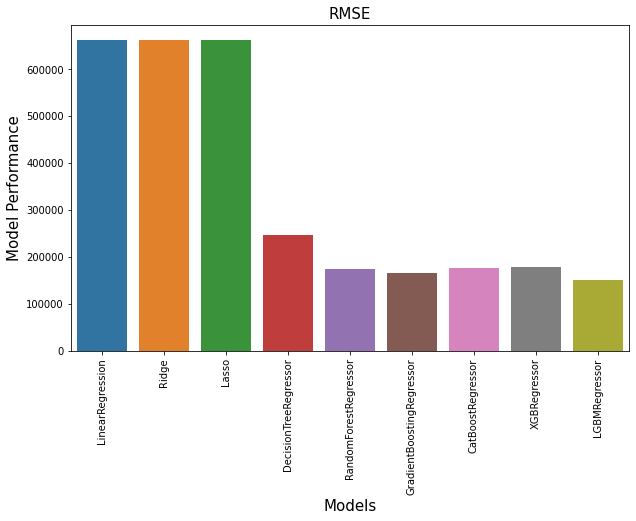

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.title('RMSE', fontsize=15)
plt.show()

## XGB + Optuna

- Discussions 이나 bestScore 확인 시, XGBRegressor 사용 시 가장 성능이 좋게 나오는 것을 알 수 있다
- [공식문서](https://xgboost.readthedocs.io/en/stable/parameter.html)
- [XGBoost 개념 이해](https://wooono.tistory.com/97)
- [XGBoost 주요 파라미터](https://zzinnam.tistory.com/entry/XGboost-%EC%A3%BC%EC%9A%94-%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-with-%ED%8C%8C%EC%9D%B4%EC%8D%AC)
- [XGBoost와 LightGBM 하이퍼파라미터 튜닝 가이드](https://psystat.tistory.com/131)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
sampler = TPESampler(seed=10)

def objectiveXGB(trial):

  param = {
  'objective' :'reg:linear', 
  'booster' :'gbtree',
  'metric': 'rmse',
  #'max_depth' : 3, 
  #'learning_rate' : 0.24 ,
  'max_depth':trial.suggest_int('max_depth',3,10),  
  'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
  'n_estimators':trial.suggest_int('n_estimators', 100, 10000),
  #'subsample':trial.suggest_float('subsample',0.5, 1),
  #'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
  #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
  #'lambda': trial.suggest_float('lambda', 0.001, 1.0),
  #'alpha': trial.suggest_float('alpha', 0.001, 1.0),
  #'random_state': 42
  }
  model = XGBRegressor(**param)
  model.fit(X_train, y_train, eval_set=[(X_test,y_test)], early_stopping_rounds=50)
  pred = model.predict(X_test)
  return RMSE(y_test, pred)


In [ ]:
# RMSE가 최소가 되는 방향으로 학습을 진행
studyXGB = optuna.create_study(direction='minimize',  sampler=sampler)

# n_trials 지정
studyXGB.optimize(objectiveXGB, n_trials=100)

[I 2023-02-17 08:09:08,191] A new study created in memory with name: no-name-d5454d8d-e7a4-472f-b35f-bd2c4382dcf4
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[08:09:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:09:08] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:5478565.45891
[1]	validation_0-rmse:5390977.54219
[2]	validation_0-rmse:5304785.04791
[3]	validation_0-rmse:5219995.92560
[4]	validation_0-rmse:5136579.92415
[5]	validation_0-rmse:5054477.04964
[6]	validation_0-rmse:4973711.08537
[7]	validation_0-rmse:4894235.68556
[8]	validation_0-rmse:4816033.53447
[9]	validation_0-rmse:4739078.10016
[10]	validation_0-rmse:4663380.67463
[11]	validation_0-rmse:4588890.32729
[12]	validation_0-rmse:4515602.88534
[13]	validation_0-rmse:4443473.94647
[14]	validation_0-rmse:4372490.18906
[15]	validation_0-rmse:4302655.15581
[16]	validation_0-rmse:4233925.91814
[17]	validation_0-rmse:4166315.13057
[18]	validation_0-rmse:4099764.17093
[19]	validation_0-rmse:4034309.79048
[20]	validation_0-rmse:3969890.57675
[21]	validation_0-rmse:3906507

[I 2023-02-17 08:10:20,893] Trial 0 finished with value: 135321.999403887 and parameters: {'max_depth': 9, 'learning_rate': 0.016018065314226435, 'n_estimators': 6373}. Best is trial 0 with value: 135321.999403887.


[08:10:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:20] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4708696.73570
[1]	validation_0-rmse:3982962.72366
[2]	validation_0-rmse:3369239.43983


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:2850611.52136
[4]	validation_0-rmse:2411683.39788
[5]	validation_0-rmse:2040847.98340
[6]	validation_0-rmse:1727502.74545
[7]	validation_0-rmse:1462713.02156
[8]	validation_0-rmse:1239301.84313
[9]	validation_0-rmse:1050666.75273
[10]	validation_0-rmse:891942.16946
[11]	validation_0-rmse:758131.89063
[12]	validation_0-rmse:645646.92250
[13]	validation_0-rmse:550401.29778
[14]	validation_0-rmse:471523.29007
[15]	validation_0-rmse:405668.66311
[16]	validation_0-rmse:351200.74063
[17]	validation_0-rmse:306517.11009
[18]	validation_0-rmse:267994.63056
[19]	validation_0-rmse:237761.91156
[20]	validation_0-rmse:214359.79049
[21]	validation_0-rmse:193966.42641
[22]	validation_0-rmse:177921.08204
[23]	validation_0-rmse:165425.58051
[24]	validation_0-rmse:156009.77819
[25]	validation_0-rmse:148814.59125
[26]	validation_0-rmse:143871.47602
[27]	validation_0-rmse:140227.01746
[28]	validation_0-rmse:137241.51454
[29]	validation_0-rmse:134182.22853
[30]	validation_0-rmse:13254

[I 2023-02-17 08:10:28,718] Trial 1 finished with value: 129059.54712845648 and parameters: {'max_depth': 8, 'learning_rate': 0.15456703356775123, 'n_estimators': 2325}. Best is trial 1 with value: 129059.54712845648.


[08:10:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:28] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.



/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-rmse:4287493.18249
[1]	validation_0-rmse:3302898.14334
[2]	validation_0-rmse:2545231.97487
[3]	validation_0-rmse:1962501.82489
[4]	validation_0-rmse:1515046.53953
[5]	validation_0-rmse:1171382.26477
[6]	validation_0-rmse:908486.30627
[7]	validation_0-rmse:707445.95181
[8]	validation_0-rmse:555795.35937
[9]	validation_0-rmse:441371.84609
[10]	validation_0-rmse:356576.01199
[11]	validation_0-rmse:294981.58958
[12]	validation_0-rmse:251440.36388
[13]	validation_0-rmse:221774.17489
[14]	validation_0-rmse:202305.01374
[15]	validation_0-rmse:189343.33313
[16]	validation_0-rmse:181201.07705
[17]	validation_0-rmse:176278.50832
[18]	validation_0-rmse:173329.64131
[19]	validation_0-rmse:171562.49562
[20]	validation_0-rmse:170330.08081
[21]	validation_0-rmse:154054.25108
[22]	validation_0-rmse:153592.64385
[23]	validation_0-rmse:153278.44344
[24]	validation_0-rmse:153054.43258
[25]	validation_0-rmse:152931.43173
[26]	validation_0-rmse:142171.74834
[27]	validation_0-rmse:141976.74

[I 2023-02-17 08:10:32,435] Trial 2 finished with value: 133481.13780837785 and parameters: {'max_depth': 4, 'learning_rate': 0.23055390653769803, 'n_estimators': 1774}. Best is trial 1 with value: 129059.54712845648.


[08:10:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:32] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4412051.51375
[1]	validation_0-rmse:3497487.23525
[2]	validation_0-rmse:2772976.48366
[3]	validation_0-rmse:2199953.46828
[4]	validation_0-rmse:1747064.94417
[5]	validation_0-rmse:1388660.78169
[6]	validation_0-rmse:1104986.79361


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[7]	validation_0-rmse:882011.36356
[8]	validation_0-rmse:706818.50075
[9]	validation_0-rmse:568404.50863
[10]	validation_0-rmse:461317.43410
[11]	validation_0-rmse:378909.08724
[12]	validation_0-rmse:316320.86997
[13]	validation_0-rmse:269782.89969
[14]	validation_0-rmse:236614.61960
[15]	validation_0-rmse:213374.31557
[16]	validation_0-rmse:196292.49109
[17]	validation_0-rmse:184826.19986
[18]	validation_0-rmse:177516.48141
[19]	validation_0-rmse:173200.39309
[20]	validation_0-rmse:169948.20022
[21]	validation_0-rmse:167763.30150
[22]	validation_0-rmse:166380.90966
[23]	validation_0-rmse:165602.83971
[24]	validation_0-rmse:165028.54125
[25]	validation_0-rmse:164508.16216
[26]	validation_0-rmse:163674.23963
[27]	validation_0-rmse:163470.29419
[28]	validation_0-rmse:162940.28325
[29]	validation_0-rmse:162840.33252
[30]	validation_0-rmse:162654.63407
[31]	validation_0-rmse:162594.59267
[32]	validation_0-rmse:162571.79444
[33]	validation_0-rmse:162486.07292
[34]	validation_0-rmse:155655.6

[I 2023-02-17 08:10:35,852] Trial 3 finished with value: 144273.06967764033 and parameters: {'max_depth': 3, 'learning_rate': 0.2087543473266612, 'n_estimators': 9539}. Best is trial 1 with value: 129059.54712845648.


[08:10:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:35] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4689865.32629
[1]	validation_0-rmse:3951690.53715
[2]	validation_0-rmse:3329787.30946
[3]	validation_0-rmse:2805922.07571
[4]	validation_0-rmse:2365444.07259
[5]	validation_0-rmse:1994787.00276


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[6]	validation_0-rmse:1682747.49804
[7]	validation_0-rmse:1420543.12309
[8]	validation_0-rmse:1200196.92071
[9]	validation_0-rmse:1015540.82583
[10]	validation_0-rmse:860605.09940
[11]	validation_0-rmse:730906.10363
[12]	validation_0-rmse:622527.77381
[13]	validation_0-rmse:532558.51273
[14]	validation_0-rmse:457924.14478
[15]	validation_0-rmse:397081.16077
[16]	validation_0-rmse:346834.72537
[17]	validation_0-rmse:306876.70929
[18]	validation_0-rmse:275108.24485
[19]	validation_0-rmse:249344.95766
[20]	validation_0-rmse:229635.20718
[21]	validation_0-rmse:214293.27182
[22]	validation_0-rmse:202960.77898
[23]	validation_0-rmse:194197.62829
[24]	validation_0-rmse:188022.31576
[25]	validation_0-rmse:183268.93934
[26]	validation_0-rmse:179807.07941
[27]	validation_0-rmse:177343.81689
[28]	validation_0-rmse:175516.48043
[29]	validation_0-rmse:173841.05778
[30]	validation_0-rmse:172863.73423
[31]	validation_0-rmse:171782.98726
[32]	validation_0-rmse:171122.06049
[33]	validation_0-rmse:17061

[I 2023-02-17 08:10:45,679] Trial 4 finished with value: 149191.30894143495 and parameters: {'max_depth': 3, 'learning_rate': 0.15853575638187523, 'n_estimators': 8145}. Best is trial 1 with value: 129059.54712845648.


[08:10:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:45] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4349012.98228
[1]	validation_0-rmse:3398693.50758
[2]	validation_0-rmse:2656338.13855


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:2076873.98571
[4]	validation_0-rmse:1624669.74610
[5]	validation_0-rmse:1271899.27425
[6]	validation_0-rmse:997579.45006
[7]	validation_0-rmse:784619.95801
[8]	validation_0-rmse:617652.66248
[9]	validation_0-rmse:490125.87660
[10]	validation_0-rmse:390636.88833
[11]	validation_0-rmse:314965.88530
[12]	validation_0-rmse:258915.25865
[13]	validation_0-rmse:216729.28068
[14]	validation_0-rmse:187113.71116
[15]	validation_0-rmse:166500.16374
[16]	validation_0-rmse:152550.10754
[17]	validation_0-rmse:142619.52926
[18]	validation_0-rmse:135972.90861
[19]	validation_0-rmse:132223.50911
[20]	validation_0-rmse:130369.05243
[21]	validation_0-rmse:128987.54645
[22]	validation_0-rmse:127998.80380
[23]	validation_0-rmse:127501.84801
[24]	validation_0-rmse:126887.45488
[25]	validation_0-rmse:126667.51091
[26]	validation_0-rmse:126526.67727
[27]	validation_0-rmse:126476.74211
[28]	validation_0-rmse:126559.68457
[29]	validation_0-rmse:126356.34299
[30]	validation_0-rmse:126183.86

[I 2023-02-17 08:10:49,901] Trial 5 finished with value: 126145.00493391177 and parameters: {'max_depth': 7, 'learning_rate': 0.21930904205522186, 'n_estimators': 2989}. Best is trial 5 with value: 126145.00493391177.


[08:10:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:10:49] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4360595.61375
[1]	validation_0-rmse:3416797.76422


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2677482.72149
[3]	validation_0-rmse:2098914.67775
[4]	validation_0-rmse:1646189.85033
[5]	validation_0-rmse:1292119.24402
[6]	validation_0-rmse:1016048.27399
[7]	validation_0-rmse:799565.55359
[8]	validation_0-rmse:632110.97476
[9]	validation_0-rmse:500796.73086
[10]	validation_0-rmse:400802.83794
[11]	validation_0-rmse:323381.27254
[12]	validation_0-rmse:266049.22057
[13]	validation_0-rmse:223048.89542
[14]	validation_0-rmse:192512.81429
[15]	validation_0-rmse:171862.85048
[16]	validation_0-rmse:157756.63915
[17]	validation_0-rmse:148603.52757
[18]	validation_0-rmse:142458.75165
[19]	validation_0-rmse:138536.27528
[20]	validation_0-rmse:136166.05373
[21]	validation_0-rmse:134156.97694
[22]	validation_0-rmse:132974.72701
[23]	validation_0-rmse:132280.14909
[24]	validation_0-rmse:131932.57940
[25]	validation_0-rmse:131692.18563
[26]	validation_0-rmse:131542.12111
[27]	validation_0-rmse:131374.65120
[28]	validation_0-rmse:131241.12666
[29]	validation_0-rmse:131184.1

[I 2023-02-17 08:11:18,042] Trial 6 finished with value: 131184.16203968652 and parameters: {'max_depth': 10, 'learning_rate': 0.21722697718533027, 'n_estimators': 5471}. Best is trial 5 with value: 126145.00493391177.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[08:11:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:18] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4910820.83891
[1]	validation_0-rmse:4331750.49367
[2]	validation_0-rmse:3821138.06360
[3]	validation_0-rmse:3371161.40731
[4]	validation_0-rmse:2974183.32662
[5]	validation_0-rmse:2624342.72188
[6]	validation_0-rmse:2315945.00537
[7]	validation_0-rmse:2044279.77861
[8]	validation_0-rmse:1804757.69449
[9]	validation_0-rmse:1593467.48077
[10]	validation_0-rmse:1407713.75991
[11]	validation_0-rmse:1243990.45646
[12]	validation_0-rmse:1100088.00667
[13]	validation_0-rmse:973390.52372
[14]	validation_0-rmse:862028.08728
[15]	validation_0-rmse:764498.66141
[16]	validation_0-rmse:678826.96728
[17]	validation_0-rmse:603781.49914
[18]	validation_0-rmse:538205.43905
[19]	validation_0-rmse:481119.23483
[20]	validation_0-rmse:431460.79420
[21]	validation_0-rmse:388554.32742
[2

[I 2023-02-17 08:11:31,409] Trial 7 finished with value: 130869.67592795452 and parameters: {'max_depth': 4, 'learning_rate': 0.11826882041492606, 'n_estimators': 6774}. Best is trial 5 with value: 126145.00493391177.


[08:11:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:31] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4812599.30941
[1]	validation_0-rmse:4160572.40031
[2]	validation_0-rmse:3596847.40875


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:3109691.23153
[4]	validation_0-rmse:2689058.67367
[5]	validation_0-rmse:2325394.54327
[6]	validation_0-rmse:2011383.22325
[7]	validation_0-rmse:1739909.78455
[8]	validation_0-rmse:1505603.34158
[9]	validation_0-rmse:1303378.98296
[10]	validation_0-rmse:1128803.52687
[11]	validation_0-rmse:978344.15168
[12]	validation_0-rmse:848746.84817
[13]	validation_0-rmse:737151.91941
[14]	validation_0-rmse:641217.28613
[15]	validation_0-rmse:558926.23070
[16]	validation_0-rmse:488636.86640
[17]	validation_0-rmse:428623.87509
[18]	validation_0-rmse:376646.82892
[19]	validation_0-rmse:333392.31743
[20]	validation_0-rmse:297014.24397
[21]	validation_0-rmse:266787.55144
[22]	validation_0-rmse:241739.36628
[23]	validation_0-rmse:219805.37663
[24]	validation_0-rmse:202937.61114
[25]	validation_0-rmse:189300.40884
[26]	validation_0-rmse:177228.15713
[27]	validation_0-rmse:168671.28821
[28]	validation_0-rmse:161943.51364
[29]	validation_0-rmse:156942.59427
[30]	validation_0-rmse:1531

[I 2023-02-17 08:11:37,297] Trial 8 finished with value: 131128.40957034583 and parameters: {'max_depth': 6, 'learning_rate': 0.13586405806665516, 'n_estimators': 6216}. Best is trial 5 with value: 126145.00493391177.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[08:11:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:37] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4463969.88180
[1]	validation_0-rmse:3580279.28283
[2]	validation_0-rmse:2871769.59342
[3]	validation_0-rmse:2304078.05738
[4]	validation_0-rmse:1849131.09420
[5]	validation_0-rmse:1485028.52756
[6]	validation_0-rmse:1193834.95339
[7]	validation_0-rmse:961575.02505
[8]	validation_0-rmse:776204.81336
[9]	validation_0-rmse:627132.26104
[10]	validation_0-rmse:509913.01754
[11]	validation_0-rmse:417072.28824
[12]	validation_0-rmse:342818.31615
[13]	validation_0-rmse:285441.51292
[14]	validation_0-rmse:242387.17837
[15]	validation_0-rmse:209998.70260
[16]	validation_0-rmse:186421.41298
[17]	validation_0-rmse:168323.13264
[18]	validation_0-rmse:156368.10175
[19]	validation_0-rmse:148080.40266
[20]	validation_0-rmse:142504.62477
[21]	validation_0-rmse:138277.77270
[22]	val

[I 2023-02-17 08:11:45,513] Trial 9 finished with value: 129619.57792960845 and parameters: {'max_depth': 7, 'learning_rate': 0.1986151827601255, 'n_estimators': 6050}. Best is trial 5 with value: 126145.00493391177.


[08:11:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:45] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3937734.25525
[1]	validation_0-rmse:2786841.05696
[2]	validation_0-rmse:1973421.80477


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1399092.25636
[4]	validation_0-rmse:994270.73740
[5]	validation_0-rmse:710328.70490
[6]	validation_0-rmse:512763.76345
[7]	validation_0-rmse:376568.18266
[8]	validation_0-rmse:282472.98057
[9]	validation_0-rmse:222714.63277
[10]	validation_0-rmse:185628.44607
[11]	validation_0-rmse:164287.83485
[12]	validation_0-rmse:152186.49026
[13]	validation_0-rmse:145847.89551
[14]	validation_0-rmse:142668.64886
[15]	validation_0-rmse:135286.73587
[16]	validation_0-rmse:131023.56581
[17]	validation_0-rmse:130046.99876
[18]	validation_0-rmse:129514.18182
[19]	validation_0-rmse:129127.75533
[20]	validation_0-rmse:127135.74743
[21]	validation_0-rmse:127125.96122
[22]	validation_0-rmse:126503.14914
[23]	validation_0-rmse:126428.85622
[24]	validation_0-rmse:124418.64115
[25]	validation_0-rmse:124412.18253
[26]	validation_0-rmse:124423.65398
[27]	validation_0-rmse:124438.53045
[28]	validation_0-rmse:124436.97240
[29]	validation_0-rmse:124507.18756
[30]	validation_0-rmse:124560.3161

[I 2023-02-17 08:11:54,810] Trial 10 finished with value: 124412.18237533647 and parameters: {'max_depth': 6, 'learning_rate': 0.29335675319614996, 'n_estimators': 240}. Best is trial 10 with value: 124412.18237533647.


[08:11:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:54] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3986803.98899
[1]	validation_0-rmse:2856654.51321
[2]	validation_0-rmse:2047749.28958


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1469442.20537
[4]	validation_0-rmse:1056523.32834
[5]	validation_0-rmse:763005.36371
[6]	validation_0-rmse:555688.77100
[7]	validation_0-rmse:410316.32710
[8]	validation_0-rmse:310618.96132
[9]	validation_0-rmse:244281.39464
[10]	validation_0-rmse:202458.53972
[11]	validation_0-rmse:172865.64500
[12]	validation_0-rmse:155111.20380
[13]	validation_0-rmse:146893.95377
[14]	validation_0-rmse:142715.15087
[15]	validation_0-rmse:138543.72227
[16]	validation_0-rmse:137699.33261
[17]	validation_0-rmse:133143.13884
[18]	validation_0-rmse:132896.95833
[19]	validation_0-rmse:130406.31375
[20]	validation_0-rmse:129965.94384
[21]	validation_0-rmse:129878.18834
[22]	validation_0-rmse:129399.99767
[23]	validation_0-rmse:129552.94506
[24]	validation_0-rmse:129636.88257
[25]	validation_0-rmse:129573.55915
[26]	validation_0-rmse:129703.47162
[27]	validation_0-rmse:129727.36180
[28]	validation_0-rmse:129717.52114
[29]	validation_0-rmse:129733.87738
[30]	validation_0-rmse:129687.224

[I 2023-02-17 08:11:57,866] Trial 11 finished with value: 129399.99753556102 and parameters: {'max_depth': 6, 'learning_rate': 0.2845210434283973, 'n_estimators': 191}. Best is trial 10 with value: 124412.18237533647.


[08:11:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:11:57] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3990534.06191
[1]	validation_0-rmse:2861994.83361
[2]	validation_0-rmse:2053504.49745


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1474966.13559
[4]	validation_0-rmse:1061494.35374
[5]	validation_0-rmse:767334.90061
[6]	validation_0-rmse:559222.55654
[7]	validation_0-rmse:413047.47140
[8]	validation_0-rmse:312859.81655
[9]	validation_0-rmse:246022.13279
[10]	validation_0-rmse:197205.49926
[11]	validation_0-rmse:170592.60273
[12]	validation_0-rmse:155469.89930
[13]	validation_0-rmse:146710.06279
[14]	validation_0-rmse:138046.90061
[15]	validation_0-rmse:133089.73043
[16]	validation_0-rmse:130150.48034
[17]	validation_0-rmse:129382.28014
[18]	validation_0-rmse:128002.43575
[19]	validation_0-rmse:127768.41161
[20]	validation_0-rmse:128158.46391
[21]	validation_0-rmse:128053.79586
[22]	validation_0-rmse:128015.28559
[23]	validation_0-rmse:126985.78577
[24]	validation_0-rmse:127062.66938
[25]	validation_0-rmse:127033.32408
[26]	validation_0-rmse:127018.75335
[27]	validation_0-rmse:127050.02894
[28]	validation_0-rmse:127090.10986
[29]	validation_0-rmse:127094.05858
[30]	validation_0-rmse:127144.427

[I 2023-02-17 08:12:01,503] Trial 12 finished with value: 126985.78727148897 and parameters: {'max_depth': 7, 'learning_rate': 0.28384931237674416, 'n_estimators': 3638}. Best is trial 10 with value: 124412.18237533647.


[08:12:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:01] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3987033.01990
[1]	validation_0-rmse:2856580.24169
[2]	validation_0-rmse:2047842.64134
[3]	validation_0-rmse:1469752.97860


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:1057213.03933
[5]	validation_0-rmse:764187.02104
[6]	validation_0-rmse:557217.87645
[7]	validation_0-rmse:412732.39392
[8]	validation_0-rmse:313898.51060
[9]	validation_0-rmse:248234.60102
[10]	validation_0-rmse:206762.54408
[11]	validation_0-rmse:182016.56990
[12]	validation_0-rmse:167835.30760
[13]	validation_0-rmse:160070.50055
[14]	validation_0-rmse:144221.89492
[15]	validation_0-rmse:134863.85890
[16]	validation_0-rmse:133689.81668
[17]	validation_0-rmse:131402.30305
[18]	validation_0-rmse:131218.69084
[19]	validation_0-rmse:131211.65862
[20]	validation_0-rmse:131207.21258
[21]	validation_0-rmse:131509.81871
[22]	validation_0-rmse:131686.49833
[23]	validation_0-rmse:131714.58712
[24]	validation_0-rmse:131627.58540
[25]	validation_0-rmse:131709.10501
[26]	validation_0-rmse:131850.77597
[27]	validation_0-rmse:130886.05718
[28]	validation_0-rmse:130819.69515
[29]	validation_0-rmse:130752.63386
[30]	validation_0-rmse:130943.68835
[31]	validation_0-rmse:131045.004

[I 2023-02-17 08:12:07,870] Trial 13 finished with value: 130742.82175929054 and parameters: {'max_depth': 5, 'learning_rate': 0.28449496826080045, 'n_estimators': 142}. Best is trial 10 with value: 124412.18237533647.


[08:12:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:07] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4189619.13841
[1]	validation_0-rmse:3154313.77825
[2]	validation_0-rmse:2375338.15828


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1789796.96371
[4]	validation_0-rmse:1349975.36741
[5]	validation_0-rmse:1020169.01617
[6]	validation_0-rmse:773507.95978
[7]	validation_0-rmse:590019.33454
[8]	validation_0-rmse:451741.33162
[9]	validation_0-rmse:350376.33177
[10]	validation_0-rmse:278640.08117
[11]	validation_0-rmse:228128.50948
[12]	validation_0-rmse:192038.88747
[13]	validation_0-rmse:170139.43040
[14]	validation_0-rmse:157039.28546
[15]	validation_0-rmse:148248.71093
[16]	validation_0-rmse:141832.89565
[17]	validation_0-rmse:138152.06956
[18]	validation_0-rmse:136330.37634
[19]	validation_0-rmse:135147.98068
[20]	validation_0-rmse:134667.73204
[21]	validation_0-rmse:134361.56034
[22]	validation_0-rmse:133699.24552
[23]	validation_0-rmse:133596.45925
[24]	validation_0-rmse:133457.30107
[25]	validation_0-rmse:133188.11871
[26]	validation_0-rmse:133111.42560
[27]	validation_0-rmse:133000.24423
[28]	validation_0-rmse:133008.69998
[29]	validation_0-rmse:132204.37250
[30]	validation_0-rmse:132198.47

[I 2023-02-17 08:12:12,426] Trial 14 finished with value: 132191.51701330036 and parameters: {'max_depth': 8, 'learning_rate': 0.24800782082972356, 'n_estimators': 3743}. Best is trial 10 with value: 124412.18237533647.


[08:12:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:12] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3901686.15595
[1]	validation_0-rmse:2735775.14634
[2]	validation_0-rmse:1919858.50669
[3]	validation_0-rmse:1349208.26006


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:950957.84088
[5]	validation_0-rmse:674812.42984
[6]	validation_0-rmse:484904.35268
[7]	validation_0-rmse:356512.82794
[8]	validation_0-rmse:272107.02606
[9]	validation_0-rmse:219048.24473
[10]	validation_0-rmse:182304.20486
[11]	validation_0-rmse:164094.61275
[12]	validation_0-rmse:154335.46244
[13]	validation_0-rmse:149258.13377
[14]	validation_0-rmse:146698.93896
[15]	validation_0-rmse:146203.70530
[16]	validation_0-rmse:147395.53469
[17]	validation_0-rmse:147089.01976
[18]	validation_0-rmse:147634.10588
[19]	validation_0-rmse:147515.83367
[20]	validation_0-rmse:137985.78997
[21]	validation_0-rmse:137978.53031
[22]	validation_0-rmse:137848.43233
[23]	validation_0-rmse:138065.82714
[24]	validation_0-rmse:137934.81676
[25]	validation_0-rmse:137914.15468
[26]	validation_0-rmse:137937.82508
[27]	validation_0-rmse:137853.09141
[28]	validation_0-rmse:138473.88004
[29]	validation_0-rmse:138638.88378
[30]	validation_0-rmse:138609.92547
[31]	validation_0-rmse:138609.5732

[I 2023-02-17 08:12:15,850] Trial 15 finished with value: 133511.19755228458 and parameters: {'max_depth': 5, 'learning_rate': 0.2998641559983713, 'n_estimators': 1895}. Best is trial 10 with value: 124412.18237533647.


[08:12:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:15] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4209837.86630
[1]	validation_0-rmse:3184877.31576


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2409918.09995
[3]	validation_0-rmse:1824457.44027
[4]	validation_0-rmse:1382631.56437
[5]	validation_0-rmse:1049563.80494
[6]	validation_0-rmse:799182.70982
[7]	validation_0-rmse:611833.34227
[8]	validation_0-rmse:469878.58582
[9]	validation_0-rmse:365135.93145
[10]	validation_0-rmse:289798.53875
[11]	validation_0-rmse:234901.22937
[12]	validation_0-rmse:196714.80704
[13]	validation_0-rmse:171573.07936
[14]	validation_0-rmse:155574.31178
[15]	validation_0-rmse:145321.26275
[16]	validation_0-rmse:138950.12067
[17]	validation_0-rmse:135253.04110
[18]	validation_0-rmse:132679.46293
[19]	validation_0-rmse:131436.48304
[20]	validation_0-rmse:130833.50685
[21]	validation_0-rmse:130471.00156
[22]	validation_0-rmse:130169.94168
[23]	validation_0-rmse:129941.56546
[24]	validation_0-rmse:129950.38107
[25]	validation_0-rmse:130004.01451
[26]	validation_0-rmse:129849.96954
[27]	validation_0-rmse:129882.71735
[28]	validation_0-rmse:129892.12609
[29]	validation_0-rmse:129931.62

[I 2023-02-17 08:12:23,794] Trial 16 finished with value: 129742.79925446183 and parameters: {'max_depth': 8, 'learning_rate': 0.24436769114366863, 'n_estimators': 3888}. Best is trial 10 with value: 124412.18237533647.


[08:12:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:23] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4127888.25929
[1]	validation_0-rmse:3062122.38967
[2]	validation_0-rmse:2272126.54644


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1687111.15018
[4]	validation_0-rmse:1254416.88492
[5]	validation_0-rmse:934945.29084
[6]	validation_0-rmse:698966.78580
[7]	validation_0-rmse:526573.88216
[8]	validation_0-rmse:401469.96195
[9]	validation_0-rmse:310775.86954
[10]	validation_0-rmse:248133.74450
[11]	validation_0-rmse:205934.87365
[12]	validation_0-rmse:178214.74666
[13]	validation_0-rmse:156948.40308
[14]	validation_0-rmse:146299.22640
[15]	validation_0-rmse:140172.60739
[16]	validation_0-rmse:136427.83999
[17]	validation_0-rmse:134440.13639
[18]	validation_0-rmse:130543.40900
[19]	validation_0-rmse:129897.88690
[20]	validation_0-rmse:127997.20520
[21]	validation_0-rmse:127738.54885
[22]	validation_0-rmse:127646.23003
[23]	validation_0-rmse:127629.87288
[24]	validation_0-rmse:127273.49460
[25]	validation_0-rmse:127246.10682
[26]	validation_0-rmse:127215.04348
[27]	validation_0-rmse:127398.20265
[28]	validation_0-rmse:127476.33180
[29]	validation_0-rmse:127463.47343
[30]	validation_0-rmse:127484.572

[I 2023-02-17 08:12:27,338] Trial 17 finished with value: 125997.51921833529 and parameters: {'max_depth': 6, 'learning_rate': 0.25911851092546484, 'n_estimators': 1548}. Best is trial 10 with value: 124412.18237533647.


[08:12:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:27] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4180031.78060
[1]	validation_0-rmse:3139501.56872
[2]	validation_0-rmse:2358918.64111


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1773424.91615
[4]	validation_0-rmse:1334712.40672
[5]	validation_0-rmse:1006899.37508
[6]	validation_0-rmse:762506.27308
[7]	validation_0-rmse:581130.77170
[8]	validation_0-rmse:447789.07510
[9]	validation_0-rmse:351132.60093
[10]	validation_0-rmse:281731.59005
[11]	validation_0-rmse:234321.54884
[12]	validation_0-rmse:202665.57667
[13]	validation_0-rmse:182522.89795
[14]	validation_0-rmse:164927.29515
[15]	validation_0-rmse:157540.68941
[16]	validation_0-rmse:149379.74060
[17]	validation_0-rmse:146620.76759
[18]	validation_0-rmse:145378.92531
[19]	validation_0-rmse:137305.62348
[20]	validation_0-rmse:136816.26913
[21]	validation_0-rmse:136587.85384
[22]	validation_0-rmse:136367.66034
[23]	validation_0-rmse:136184.73505
[24]	validation_0-rmse:134636.20298
[25]	validation_0-rmse:134829.98689
[26]	validation_0-rmse:134623.31364
[27]	validation_0-rmse:134811.53306
[28]	validation_0-rmse:134855.64413
[29]	validation_0-rmse:134895.48139
[30]	validation_0-rmse:135012.19

[I 2023-02-17 08:12:31,874] Trial 18 finished with value: 131029.96370708317 and parameters: {'max_depth': 5, 'learning_rate': 0.24974347720968734, 'n_estimators': 836}. Best is trial 10 with value: 124412.18237533647.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[08:12:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:31] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4104248.66424
[1]	validation_0-rmse:3027267.47064
[2]	validation_0-rmse:2233499.64670
[3]	validation_0-rmse:1649172.66186
[4]	validation_0-rmse:1219447.68235
[5]	validation_0-rmse:904155.76436
[6]	validation_0-rmse:673662.21843
[7]	validation_0-rmse:504688.57267
[8]	validation_0-rmse:382836.56541
[9]	validation_0-rmse:297288.08181
[10]	validation_0-rmse:238012.25636
[11]	validation_0-rmse:197378.27631
[12]	validation_0-rmse:172202.53652
[13]	validation_0-rmse:156986.10572
[14]	validation_0-rmse:148944.66207
[15]	validation_0-rmse:143995.70457
[16]	validation_0-rmse:141038.93187
[17]	validation_0-rmse:135763.65078
[18]	validation_0-rmse:134994.02471
[19]	validation_0-rmse:134509.89049
[20]	validation_0-rmse:134255.67950
[21]	validation_0-rmse:132009.79909
[22]	valid

[I 2023-02-17 08:12:37,054] Trial 19 finished with value: 132009.79995416536 and parameters: {'max_depth': 6, 'learning_rate': 0.26337467218968824, 'n_estimators': 1503}. Best is trial 10 with value: 124412.18237533647.


[08:12:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:37] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3915759.28069
[1]	validation_0-rmse:2755821.35677
[2]	validation_0-rmse:1941098.02436
[3]	validation_0-rmse:1370476.61093


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:969794.60772
[5]	validation_0-rmse:691622.12963
[6]	validation_0-rmse:499052.53173
[7]	validation_0-rmse:368583.70577
[8]	validation_0-rmse:282511.44231
[9]	validation_0-rmse:228686.45987
[10]	validation_0-rmse:196368.10976
[11]	validation_0-rmse:178562.30801
[12]	validation_0-rmse:168172.15922
[13]	validation_0-rmse:162720.91386
[14]	validation_0-rmse:159998.16501
[15]	validation_0-rmse:158336.84931
[16]	validation_0-rmse:158569.69929
[17]	validation_0-rmse:158109.31738
[18]	validation_0-rmse:157899.22090
[19]	validation_0-rmse:157688.72308
[20]	validation_0-rmse:157575.85323
[21]	validation_0-rmse:157742.06583
[22]	validation_0-rmse:157852.18127
[23]	validation_0-rmse:157997.15898
[24]	validation_0-rmse:150264.20240
[25]	validation_0-rmse:147887.46290
[26]	validation_0-rmse:148101.79603
[27]	validation_0-rmse:148017.11134
[28]	validation_0-rmse:148001.76593
[29]	validation_0-rmse:148015.68319
[30]	validation_0-rmse:145345.68483
[31]	validation_0-rmse:145367.4818

[I 2023-02-17 08:12:43,092] Trial 20 finished with value: 141696.3629204464 and parameters: {'max_depth': 4, 'learning_rate': 0.2975420424389197, 'n_estimators': 1136}. Best is trial 10 with value: 124412.18237533647.


[08:12:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:43] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4139884.75093
[1]	validation_0-rmse:3079924.24251


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2291965.65622
[3]	validation_0-rmse:1706799.11447
[4]	validation_0-rmse:1272571.36609
[5]	validation_0-rmse:951035.18545
[6]	validation_0-rmse:712113.83257
[7]	validation_0-rmse:537340.85150
[8]	validation_0-rmse:409642.22513
[9]	validation_0-rmse:315993.45453
[10]	validation_0-rmse:249777.28858
[11]	validation_0-rmse:204777.30756
[12]	validation_0-rmse:174156.21056
[13]	validation_0-rmse:155100.05831
[14]	validation_0-rmse:143545.24248
[15]	validation_0-rmse:136786.04986
[16]	validation_0-rmse:133248.15887
[17]	validation_0-rmse:130942.01067
[18]	validation_0-rmse:129779.06551
[19]	validation_0-rmse:129180.02406
[20]	validation_0-rmse:128731.41519
[21]	validation_0-rmse:128099.17938
[22]	validation_0-rmse:127960.92755
[23]	validation_0-rmse:127743.90253
[24]	validation_0-rmse:127680.35959
[25]	validation_0-rmse:127660.56836
[26]	validation_0-rmse:127668.34649
[27]	validation_0-rmse:127628.09860
[28]	validation_0-rmse:127679.37474
[29]	validation_0-rmse:128091.369

[I 2023-02-17 08:12:50,050] Trial 21 finished with value: 127628.0982903721 and parameters: {'max_depth': 7, 'learning_rate': 0.2569585363229261, 'n_estimators': 2813}. Best is trial 10 with value: 124412.18237533647.


[08:12:50] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:50] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4084417.34165
[1]	validation_0-rmse:2998081.39161
[2]	validation_0-rmse:2201344.72222


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1617697.63455
[4]	validation_0-rmse:1190618.01460
[5]	validation_0-rmse:878852.60869
[6]	validation_0-rmse:652225.56988
[7]	validation_0-rmse:487061.13063
[8]	validation_0-rmse:368611.43818
[9]	validation_0-rmse:286182.44335
[10]	validation_0-rmse:229842.41389
[11]	validation_0-rmse:192859.49275
[12]	validation_0-rmse:169575.16233
[13]	validation_0-rmse:151252.60455
[14]	validation_0-rmse:143169.09137
[15]	validation_0-rmse:138795.13981
[16]	validation_0-rmse:136306.29926
[17]	validation_0-rmse:134790.80904
[18]	validation_0-rmse:134049.85032
[19]	validation_0-rmse:134154.29514
[20]	validation_0-rmse:134005.35015
[21]	validation_0-rmse:131793.45149
[22]	validation_0-rmse:132254.62862
[23]	validation_0-rmse:132204.49869
[24]	validation_0-rmse:132122.65730
[25]	validation_0-rmse:132093.07733
[26]	validation_0-rmse:132400.14028
[27]	validation_0-rmse:131184.94578
[28]	validation_0-rmse:131370.26172
[29]	validation_0-rmse:131409.23385
[30]	validation_0-rmse:131450.726

[I 2023-02-17 08:12:53,470] Trial 22 finished with value: 131184.94570223833 and parameters: {'max_depth': 6, 'learning_rate': 0.26694526109412564, 'n_estimators': 2885}. Best is trial 10 with value: 124412.18237533647.


[08:12:53] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:12:53] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4345865.15612
[1]	validation_0-rmse:3393857.27358
[2]	validation_0-rmse:2650645.12238


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:2070942.57009
[4]	validation_0-rmse:1618895.58494
[5]	validation_0-rmse:1266492.90899
[6]	validation_0-rmse:992677.98663
[7]	validation_0-rmse:780280.60141
[8]	validation_0-rmse:613881.01003
[9]	validation_0-rmse:486879.63120
[10]	validation_0-rmse:387666.82900
[11]	validation_0-rmse:313763.98036
[12]	validation_0-rmse:257056.57065
[13]	validation_0-rmse:216313.54088
[14]	validation_0-rmse:186445.98181
[15]	validation_0-rmse:166127.79066
[16]	validation_0-rmse:151435.25060
[17]	validation_0-rmse:141861.53992
[18]	validation_0-rmse:135903.75351
[19]	validation_0-rmse:132128.54446
[20]	validation_0-rmse:129908.92624
[21]	validation_0-rmse:128417.31873
[22]	validation_0-rmse:127530.58585
[23]	validation_0-rmse:126548.51111
[24]	validation_0-rmse:126704.54727
[25]	validation_0-rmse:126239.72008
[26]	validation_0-rmse:126064.81455
[27]	validation_0-rmse:126004.77921
[28]	validation_0-rmse:125887.07196
[29]	validation_0-rmse:125971.42980
[30]	validation_0-rmse:125943.84

[I 2023-02-17 08:13:02,787] Trial 23 finished with value: 125705.11479674837 and parameters: {'max_depth': 7, 'learning_rate': 0.21987572716655635, 'n_estimators': 4568}. Best is trial 10 with value: 124412.18237533647.


[08:13:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:02] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4504956.26163
[1]	validation_0-rmse:3646223.71706


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2951440.12657
[3]	validation_0-rmse:2389536.60315
[4]	validation_0-rmse:1935129.19405
[5]	validation_0-rmse:1568189.52434
[6]	validation_0-rmse:1271618.06782
[7]	validation_0-rmse:1032392.59242
[8]	validation_0-rmse:839806.57251
[9]	validation_0-rmse:683379.88821
[10]	validation_0-rmse:559212.46766
[11]	validation_0-rmse:458140.55946
[12]	validation_0-rmse:377768.97875
[13]	validation_0-rmse:314310.07805
[14]	validation_0-rmse:265479.56909
[15]	validation_0-rmse:227872.98880
[16]	validation_0-rmse:199938.53701
[17]	validation_0-rmse:178161.59089
[18]	validation_0-rmse:163545.75366
[19]	validation_0-rmse:153741.21888
[20]	validation_0-rmse:146417.84305
[21]	validation_0-rmse:141900.91076
[22]	validation_0-rmse:138809.87766
[23]	validation_0-rmse:136905.64149
[24]	validation_0-rmse:135872.48730
[25]	validation_0-rmse:134816.13536
[26]	validation_0-rmse:134343.12040
[27]	validation_0-rmse:133900.30061
[28]	validation_0-rmse:133626.33494
[29]	validation_0-rmse:133491.

[I 2023-02-17 08:13:09,775] Trial 24 finished with value: 132380.8553116121 and parameters: {'max_depth': 9, 'learning_rate': 0.1912400427483195, 'n_estimators': 4702}. Best is trial 10 with value: 124412.18237533647.


[08:13:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:09] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4078982.51940
[1]	validation_0-rmse:2989779.86946
[2]	validation_0-rmse:2192501.72762


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1609218.49206
[4]	validation_0-rmse:1183167.99441
[5]	validation_0-rmse:872625.61488
[6]	validation_0-rmse:647336.27995
[7]	validation_0-rmse:485594.89339
[8]	validation_0-rmse:370636.91379
[9]	validation_0-rmse:290764.13558
[10]	validation_0-rmse:233023.31834
[11]	validation_0-rmse:197723.18660
[12]	validation_0-rmse:172529.04915
[13]	validation_0-rmse:159210.44224
[14]	validation_0-rmse:151800.15738
[15]	validation_0-rmse:147689.19096
[16]	validation_0-rmse:145465.61262
[17]	validation_0-rmse:144183.95047
[18]	validation_0-rmse:144451.67612
[19]	validation_0-rmse:144395.82095
[20]	validation_0-rmse:144362.63658
[21]	validation_0-rmse:137333.16485
[22]	validation_0-rmse:137323.21172
[23]	validation_0-rmse:137444.43375
[24]	validation_0-rmse:137573.35263
[25]	validation_0-rmse:138118.54293
[26]	validation_0-rmse:137900.46825
[27]	validation_0-rmse:137759.24525
[28]	validation_0-rmse:137778.47892
[29]	validation_0-rmse:133910.69602
[30]	validation_0-rmse:133900.372

[I 2023-02-17 08:13:16,868] Trial 25 finished with value: 131968.52387872234 and parameters: {'max_depth': 5, 'learning_rate': 0.26793789604791707, 'n_estimators': 4811}. Best is trial 10 with value: 124412.18237533647.


[08:13:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:16] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4287119.35439
[1]	validation_0-rmse:3302815.63696
[2]	validation_0-rmse:2544952.48840


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1961859.63264
[4]	validation_0-rmse:1513300.86206
[5]	validation_0-rmse:1168637.89791
[6]	validation_0-rmse:904601.63704
[7]	validation_0-rmse:702851.15579
[8]	validation_0-rmse:549333.01890
[9]	validation_0-rmse:431563.79178
[10]	validation_0-rmse:344416.98945
[11]	validation_0-rmse:280321.35927
[12]	validation_0-rmse:234165.27100
[13]	validation_0-rmse:202032.20109
[14]	validation_0-rmse:180342.75286
[15]	validation_0-rmse:166877.46626
[16]	validation_0-rmse:158002.96461
[17]	validation_0-rmse:152769.40956
[18]	validation_0-rmse:149349.53586
[19]	validation_0-rmse:141774.79439
[20]	validation_0-rmse:136611.78581
[21]	validation_0-rmse:135972.11330
[22]	validation_0-rmse:132884.66938
[23]	validation_0-rmse:132534.50706
[24]	validation_0-rmse:132398.67728
[25]	validation_0-rmse:132215.10101
[26]	validation_0-rmse:130458.61487
[27]	validation_0-rmse:130552.47442
[28]	validation_0-rmse:129619.02653
[29]	validation_0-rmse:129569.95457
[30]	validation_0-rmse:130016.04

[I 2023-02-17 08:13:20,665] Trial 26 finished with value: 128901.99543729176 and parameters: {'max_depth': 6, 'learning_rate': 0.23045135368539435, 'n_estimators': 7610}. Best is trial 10 with value: 124412.18237533647.


[08:13:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:20] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4247836.58127
[1]	validation_0-rmse:3242566.89845


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2475697.50158
[3]	validation_0-rmse:1891196.07895
[4]	validation_0-rmse:1445690.15874
[5]	validation_0-rmse:1106573.58591
[6]	validation_0-rmse:849469.15483
[7]	validation_0-rmse:654916.64775
[8]	validation_0-rmse:508558.35238
[9]	validation_0-rmse:399452.74927
[10]	validation_0-rmse:317722.86324
[11]	validation_0-rmse:255985.10840
[12]	validation_0-rmse:214663.87367
[13]	validation_0-rmse:186708.13497
[14]	validation_0-rmse:168808.15797
[15]	validation_0-rmse:158004.18642
[16]	validation_0-rmse:150858.68002
[17]	validation_0-rmse:144293.48258
[18]	validation_0-rmse:141761.09122
[19]	validation_0-rmse:140194.69903
[20]	validation_0-rmse:139231.66091
[21]	validation_0-rmse:136675.11145
[22]	validation_0-rmse:134788.87450
[23]	validation_0-rmse:134553.49578
[24]	validation_0-rmse:133213.51579
[25]	validation_0-rmse:132417.45039
[26]	validation_0-rmse:132490.90803
[27]	validation_0-rmse:131796.93614
[28]	validation_0-rmse:131694.61727
[29]	validation_0-rmse:131669.13

[I 2023-02-17 08:13:51,458] Trial 27 finished with value: 130585.14422101736 and parameters: {'max_depth': 8, 'learning_rate': 0.2375266122218543, 'n_estimators': 734}. Best is trial 10 with value: 124412.18237533647.


[08:13:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:51] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4027804.36272
[1]	validation_0-rmse:2915584.92860


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2111239.80874
[3]	validation_0-rmse:1530366.24527
[4]	validation_0-rmse:1111287.32807
[5]	validation_0-rmse:809958.32368
[6]	validation_0-rmse:592437.68218
[7]	validation_0-rmse:438580.16413
[8]	validation_0-rmse:330913.68409
[9]	validation_0-rmse:254932.99672
[10]	validation_0-rmse:203873.71433
[11]	validation_0-rmse:171704.34055
[12]	validation_0-rmse:152148.14026
[13]	validation_0-rmse:140837.28209
[14]	validation_0-rmse:134567.42781
[15]	validation_0-rmse:132136.38792
[16]	validation_0-rmse:130387.58607
[17]	validation_0-rmse:129180.68969
[18]	validation_0-rmse:128592.95033
[19]	validation_0-rmse:128421.88931
[20]	validation_0-rmse:128335.58529
[21]	validation_0-rmse:128235.87156
[22]	validation_0-rmse:128161.95666
[23]	validation_0-rmse:128163.88699
[24]	validation_0-rmse:128138.04732
[25]	validation_0-rmse:128103.39125
[26]	validation_0-rmse:128161.27197
[27]	validation_0-rmse:128057.36707
[28]	validation_0-rmse:127999.73071
[29]	validation_0-rmse:127994.133

[I 2023-02-17 08:13:55,831] Trial 28 finished with value: 127873.01596778954 and parameters: {'max_depth': 7, 'learning_rate': 0.2771384840979785, 'n_estimators': 2081}. Best is trial 10 with value: 124412.18237533647.


[08:13:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:13:55] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:5503766.68389
[1]	validation_0-rmse:5440690.41533


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:5378327.16153
[3]	validation_0-rmse:5316699.49525
[4]	validation_0-rmse:5255774.35733
[5]	validation_0-rmse:5195543.54254
[6]	validation_0-rmse:5136014.08423
[7]	validation_0-rmse:5077167.31415
[8]	validation_0-rmse:5019005.81977
[9]	validation_0-rmse:4961508.46628
[10]	validation_0-rmse:4904676.84559
[11]	validation_0-rmse:4848504.62527
[12]	validation_0-rmse:4792970.13563
[13]	validation_0-rmse:4738072.96103
[14]	validation_0-rmse:4683813.16855
[15]	validation_0-rmse:4630177.08194
[16]	validation_0-rmse:4577153.86521
[17]	validation_0-rmse:4524737.83763
[18]	validation_0-rmse:4472950.06378
[19]	validation_0-rmse:4421730.69869
[20]	validation_0-rmse:4371083.48427
[21]	validation_0-rmse:4321010.38021
[22]	validation_0-rmse:4271536.75401
[23]	validation_0-rmse:4222620.22413
[24]	validation_0-rmse:4174278.98952
[25]	validation_0-rmse:4126482.21028
[26]	validation_0-rmse:4079244.27845
[27]	validation_0-rmse:4032547.75884
[28]	validation_0-rmse:3986368.30088
[29]	vali

[I 2023-02-17 08:14:52,377] Trial 29 finished with value: 135480.96735748815 and parameters: {'max_depth': 9, 'learning_rate': 0.011483311596565515, 'n_estimators': 9860}. Best is trial 10 with value: 124412.18237533647.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[08:14:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:52] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3903849.29958
[1]	validation_0-rmse:2738767.66904
[2]	validation_0-rmse:1923034.61692
[3]	validation_0-rmse:1352168.89436
[4]	validation_0-rmse:953824.41988
[5]	validation_0-rmse:677031.37856
[6]	validation_0-rmse:486755.53530
[7]	validation_0-rmse:357887.84130
[8]	validation_0-rmse:273147.34401
[9]	validation_0-rmse:219881.34534
[10]	validation_0-rmse:188278.10567
[11]	validation_0-rmse:170881.73860
[12]	validation_0-rmse:161618.62739
[13]	validation_0-rmse:144111.38929
[14]	validation_0-rmse:134270.90668
[15]	validation_0-rmse:133502.51834
[16]	validation_0-rmse:129223.24736
[17]	validation_0-rmse:129003.88409
[18]	validation_0-rmse:130018.79564
[19]	validation_0-rmse:129851.25724
[20]	validation_0-rmse:129818.81670
[21]	validation_0-rmse:129813.61051
[22]	valida

[I 2023-02-17 08:14:57,615] Trial 30 finished with value: 129003.88490300503 and parameters: {'max_depth': 5, 'learning_rate': 0.2994745904636694, 'n_estimators': 4254}. Best is trial 10 with value: 124412.18237533647.


[08:14:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:14:57] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4343962.27443
[1]	validation_0-rmse:3390752.07011


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2647078.38087
[3]	validation_0-rmse:2067346.85461
[4]	validation_0-rmse:1615352.16754
[5]	validation_0-rmse:1263242.81106
[6]	validation_0-rmse:989694.17038
[7]	validation_0-rmse:775995.53786
[8]	validation_0-rmse:611123.53908
[9]	validation_0-rmse:484266.11445
[10]	validation_0-rmse:387454.32562
[11]	validation_0-rmse:314122.99551
[12]	validation_0-rmse:259658.72147
[13]	validation_0-rmse:220305.55387
[14]	validation_0-rmse:189657.56705
[15]	validation_0-rmse:167770.20818
[16]	validation_0-rmse:154522.45388
[17]	validation_0-rmse:145968.63962
[18]	validation_0-rmse:140482.29146
[19]	validation_0-rmse:136807.63535
[20]	validation_0-rmse:134552.58324
[21]	validation_0-rmse:133291.79021
[22]	validation_0-rmse:131093.16527
[23]	validation_0-rmse:130539.46872
[24]	validation_0-rmse:130202.61014
[25]	validation_0-rmse:128925.68177
[26]	validation_0-rmse:128013.39040
[27]	validation_0-rmse:128353.38251
[28]	validation_0-rmse:128168.75975
[29]	validation_0-rmse:128046.99

[I 2023-02-17 08:15:02,002] Trial 31 finished with value: 127026.09716454126 and parameters: {'max_depth': 7, 'learning_rate': 0.2202182687523284, 'n_estimators': 2962}. Best is trial 10 with value: 124412.18237533647.


[08:15:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:02] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4511657.62988
[1]	validation_0-rmse:3657037.27456


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2964617.68637
[3]	validation_0-rmse:2403780.80103
[4]	validation_0-rmse:1949563.73135
[5]	validation_0-rmse:1582004.56861
[6]	validation_0-rmse:1284733.65397
[7]	validation_0-rmse:1043298.33251
[8]	validation_0-rmse:849228.89186
[9]	validation_0-rmse:692856.03836
[10]	validation_0-rmse:567431.46253
[11]	validation_0-rmse:466920.31383
[12]	validation_0-rmse:385058.03957
[13]	validation_0-rmse:321026.19340
[14]	validation_0-rmse:270096.45369
[15]	validation_0-rmse:231671.22675
[16]	validation_0-rmse:202546.10186
[17]	validation_0-rmse:181179.63647
[18]	validation_0-rmse:164089.61943
[19]	validation_0-rmse:153039.66043
[20]	validation_0-rmse:145354.00453
[21]	validation_0-rmse:138937.08301
[22]	validation_0-rmse:135480.33260
[23]	validation_0-rmse:133133.72375
[24]	validation_0-rmse:131747.63152
[25]	validation_0-rmse:130068.18292
[26]	validation_0-rmse:128963.20019
[27]	validation_0-rmse:128282.60903
[28]	validation_0-rmse:127910.01600
[29]	validation_0-rmse:127888.

[I 2023-02-17 08:15:09,341] Trial 32 finished with value: 127683.57217376021 and parameters: {'max_depth': 7, 'learning_rate': 0.19003108302800428, 'n_estimators': 2405}. Best is trial 10 with value: 124412.18237533647.


[08:15:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:09] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4131115.38371
[1]	validation_0-rmse:3066886.74381


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2277444.91574
[3]	validation_0-rmse:1692433.46323
[4]	validation_0-rmse:1259230.57498
[5]	validation_0-rmse:939257.02797
[6]	validation_0-rmse:702026.71160
[7]	validation_0-rmse:528945.25101
[8]	validation_0-rmse:402875.12109
[9]	validation_0-rmse:310849.44879
[10]	validation_0-rmse:246095.16370
[11]	validation_0-rmse:202597.37799
[12]	validation_0-rmse:174091.81998
[13]	validation_0-rmse:156144.15183
[14]	validation_0-rmse:145114.16141
[15]	validation_0-rmse:138862.00385
[16]	validation_0-rmse:135245.42022
[17]	validation_0-rmse:133448.50283
[18]	validation_0-rmse:131981.12927
[19]	validation_0-rmse:131239.48123
[20]	validation_0-rmse:130650.59425
[21]	validation_0-rmse:130434.53951
[22]	validation_0-rmse:130521.36130
[23]	validation_0-rmse:130454.96885
[24]	validation_0-rmse:130364.81646
[25]	validation_0-rmse:130302.66602
[26]	validation_0-rmse:130338.63430
[27]	validation_0-rmse:130322.21574
[28]	validation_0-rmse:130448.09281
[29]	validation_0-rmse:130435.208

[I 2023-02-17 08:15:13,814] Trial 33 finished with value: 130302.66459249996 and parameters: {'max_depth': 8, 'learning_rate': 0.2585409704443338, 'n_estimators': 1308}. Best is trial 10 with value: 124412.18237533647.


[08:15:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:13] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4299397.62189
[1]	validation_0-rmse:3321723.59286
[2]	validation_0-rmse:2566687.24222


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1984235.90843
[4]	validation_0-rmse:1534630.99918
[5]	validation_0-rmse:1188393.07574
[6]	validation_0-rmse:922413.47953
[7]	validation_0-rmse:718484.85989
[8]	validation_0-rmse:562592.58678
[9]	validation_0-rmse:444463.12748
[10]	validation_0-rmse:355870.25308
[11]	validation_0-rmse:287852.60439
[12]	validation_0-rmse:240497.82521
[13]	validation_0-rmse:204406.42123
[14]	validation_0-rmse:181615.27277
[15]	validation_0-rmse:166758.03133
[16]	validation_0-rmse:157193.73660
[17]	validation_0-rmse:146006.31032
[18]	validation_0-rmse:142082.96973
[19]	validation_0-rmse:139475.18171
[20]	validation_0-rmse:134757.19214
[21]	validation_0-rmse:132057.91649
[22]	validation_0-rmse:131525.81271
[23]	validation_0-rmse:129963.96680
[24]	validation_0-rmse:129730.99622
[25]	validation_0-rmse:128812.05236
[26]	validation_0-rmse:128665.22680
[27]	validation_0-rmse:128548.38351
[28]	validation_0-rmse:128627.54240
[29]	validation_0-rmse:128586.93698
[30]	validation_0-rmse:128539.50

[I 2023-02-17 08:15:17,538] Trial 34 finished with value: 128487.82444396419 and parameters: {'max_depth': 6, 'learning_rate': 0.2282409675059936, 'n_estimators': 2990}. Best is trial 10 with value: 124412.18237533647.


[08:15:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:17] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4416061.23439
[1]	validation_0-rmse:3503922.10691


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2780486.86366
[3]	validation_0-rmse:2207151.80732
[4]	validation_0-rmse:1752677.09676
[5]	validation_0-rmse:1392565.53874
[6]	validation_0-rmse:1108040.10306
[7]	validation_0-rmse:883336.28273
[8]	validation_0-rmse:704701.88386
[9]	validation_0-rmse:565467.15781
[10]	validation_0-rmse:454847.84438
[11]	validation_0-rmse:368739.08849
[12]	validation_0-rmse:302550.15283
[13]	validation_0-rmse:252831.00659
[14]	validation_0-rmse:215723.07781
[15]	validation_0-rmse:188843.70485
[16]	validation_0-rmse:169765.77392
[17]	validation_0-rmse:156640.36308
[18]	validation_0-rmse:147742.47771
[19]	validation_0-rmse:140960.02618
[20]	validation_0-rmse:136845.43171
[21]	validation_0-rmse:134262.33053
[22]	validation_0-rmse:132539.94859
[23]	validation_0-rmse:131477.97607
[24]	validation_0-rmse:130854.05375
[25]	validation_0-rmse:130389.07170
[26]	validation_0-rmse:130117.89126
[27]	validation_0-rmse:130173.69543
[28]	validation_0-rmse:130096.51293
[29]	validation_0-rmse:129845.9

[I 2023-02-17 08:15:26,332] Trial 35 finished with value: 129476.59131378886 and parameters: {'max_depth': 8, 'learning_rate': 0.207242153738651, 'n_estimators': 551}. Best is trial 10 with value: 124412.18237533647.


[08:15:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:26] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4238963.35079
[1]	validation_0-rmse:3229068.15857
[2]	validation_0-rmse:2460268.08979


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1875596.90635
[4]	validation_0-rmse:1430881.72152
[5]	validation_0-rmse:1093073.87984
[6]	validation_0-rmse:837494.97304
[7]	validation_0-rmse:644605.89233
[8]	validation_0-rmse:499825.50010
[9]	validation_0-rmse:392316.57738
[10]	validation_0-rmse:310143.77451
[11]	validation_0-rmse:252783.20056
[12]	validation_0-rmse:212663.23283
[13]	validation_0-rmse:185690.20116
[14]	validation_0-rmse:164252.26098
[15]	validation_0-rmse:153010.13389
[16]	validation_0-rmse:145768.68137
[17]	validation_0-rmse:138984.04967
[18]	validation_0-rmse:136408.22679
[19]	validation_0-rmse:135052.68833
[20]	validation_0-rmse:133069.16601
[21]	validation_0-rmse:130827.95849
[22]	validation_0-rmse:130509.79137
[23]	validation_0-rmse:130889.25365
[24]	validation_0-rmse:129971.71732
[25]	validation_0-rmse:129319.51675
[26]	validation_0-rmse:129571.01679
[27]	validation_0-rmse:129525.71794
[28]	validation_0-rmse:129286.02891
[29]	validation_0-rmse:128573.98076
[30]	validation_0-rmse:128526.43

[I 2023-02-17 08:15:31,062] Trial 36 finished with value: 127693.34145196549 and parameters: {'max_depth': 7, 'learning_rate': 0.23912076314470587, 'n_estimators': 5417}. Best is trial 10 with value: 124412.18237533647.


[08:15:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:31] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4602595.53253
[1]	validation_0-rmse:3805416.48206


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:3146757.66033
[3]	validation_0-rmse:2602601.91490
[4]	validation_0-rmse:2152768.24952
[5]	validation_0-rmse:1781052.33497
[6]	validation_0-rmse:1474141.13636
[7]	validation_0-rmse:1220950.03515
[8]	validation_0-rmse:1012185.99817
[9]	validation_0-rmse:840317.51364
[10]	validation_0-rmse:698993.45169
[11]	validation_0-rmse:583021.03780
[12]	validation_0-rmse:488428.33234
[13]	validation_0-rmse:411262.41222
[14]	validation_0-rmse:348950.15082
[15]	validation_0-rmse:297613.96404
[16]	validation_0-rmse:257864.13304
[17]	validation_0-rmse:226858.31808
[18]	validation_0-rmse:201516.74461
[19]	validation_0-rmse:183358.44842
[20]	validation_0-rmse:169903.48306
[21]	validation_0-rmse:158635.57013
[22]	validation_0-rmse:151438.98513
[23]	validation_0-rmse:146317.99119
[24]	validation_0-rmse:143019.08250
[25]	validation_0-rmse:140487.25545
[26]	validation_0-rmse:136059.10764
[27]	validation_0-rmse:132863.14915
[28]	validation_0-rmse:130545.52646
[29]	validation_0-rmse:130044

[I 2023-02-17 08:15:37,805] Trial 37 finished with value: 128590.0029932736 and parameters: {'max_depth': 6, 'learning_rate': 0.17366224232102645, 'n_estimators': 3491}. Best is trial 10 with value: 124412.18237533647.


[08:15:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:37] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4346264.34409
[1]	validation_0-rmse:3393971.68138
[2]	validation_0-rmse:2651045.87501
[3]	validation_0-rmse:2071726.04690


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:1620250.40576
[5]	validation_0-rmse:1269177.88859
[6]	validation_0-rmse:995880.66815
[7]	validation_0-rmse:784806.13585
[8]	validation_0-rmse:621537.74571
[9]	validation_0-rmse:496095.43729
[10]	validation_0-rmse:401080.25113
[11]	validation_0-rmse:330518.32130
[12]	validation_0-rmse:278496.64526
[13]	validation_0-rmse:241489.97290
[14]	validation_0-rmse:215846.74574
[15]	validation_0-rmse:198727.98781
[16]	validation_0-rmse:187618.51522
[17]	validation_0-rmse:171109.71498
[18]	validation_0-rmse:165970.02470
[19]	validation_0-rmse:162917.88616
[20]	validation_0-rmse:160907.54046
[21]	validation_0-rmse:158048.09970
[22]	validation_0-rmse:151166.00258
[23]	validation_0-rmse:150761.41458
[24]	validation_0-rmse:150573.89578
[25]	validation_0-rmse:150695.39596
[26]	validation_0-rmse:150492.50729
[27]	validation_0-rmse:150382.83472
[28]	validation_0-rmse:150290.72457
[29]	validation_0-rmse:150391.46860
[30]	validation_0-rmse:150501.42664
[31]	validation_0-rmse:150490.18

[I 2023-02-17 08:15:45,210] Trial 38 finished with value: 135787.05600478084 and parameters: {'max_depth': 4, 'learning_rate': 0.21996499059419422, 'n_estimators': 2399}. Best is trial 10 with value: 124412.18237533647.


[08:15:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:45] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4403629.85841
[1]	validation_0-rmse:3484261.10944


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2757119.33070
[3]	validation_0-rmse:2182439.84898
[4]	validation_0-rmse:1728234.86891
[5]	validation_0-rmse:1369500.78878
[6]	validation_0-rmse:1086777.99240
[7]	validation_0-rmse:862936.55209
[8]	validation_0-rmse:686651.41991
[9]	validation_0-rmse:549220.34096
[10]	validation_0-rmse:441823.61794
[11]	validation_0-rmse:357539.47440
[12]	validation_0-rmse:293859.36279
[13]	validation_0-rmse:246190.44552
[14]	validation_0-rmse:210739.96258
[15]	validation_0-rmse:185598.19762
[16]	validation_0-rmse:166583.30997
[17]	validation_0-rmse:154770.49433
[18]	validation_0-rmse:146696.99127
[19]	validation_0-rmse:140608.85243
[20]	validation_0-rmse:137370.19082
[21]	validation_0-rmse:134813.10380
[22]	validation_0-rmse:132997.28303
[23]	validation_0-rmse:132041.46438
[24]	validation_0-rmse:131911.01433
[25]	validation_0-rmse:131591.37910
[26]	validation_0-rmse:131368.63861
[27]	validation_0-rmse:131037.72511
[28]	validation_0-rmse:130818.74011
[29]	validation_0-rmse:130685.5

[I 2023-02-17 08:15:54,522] Trial 39 finished with value: 130287.60406579345 and parameters: {'max_depth': 9, 'learning_rate': 0.2094799974163541, 'n_estimators': 1736}. Best is trial 10 with value: 124412.18237533647.


[08:15:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:15:54] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4039115.56705
[1]	validation_0-rmse:2932044.45641


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2129085.36138
[3]	validation_0-rmse:1547630.16628
[4]	validation_0-rmse:1126898.16618
[5]	validation_0-rmse:823504.29254
[6]	validation_0-rmse:605649.67210
[7]	validation_0-rmse:447682.55596
[8]	validation_0-rmse:338078.39744
[9]	validation_0-rmse:260295.36264
[10]	validation_0-rmse:208263.67071
[11]	validation_0-rmse:174834.01925
[12]	validation_0-rmse:155408.17316
[13]	validation_0-rmse:144019.81180
[14]	validation_0-rmse:137081.98657
[15]	validation_0-rmse:133239.92430
[16]	validation_0-rmse:131271.15847
[17]	validation_0-rmse:130669.90088
[18]	validation_0-rmse:130408.71690
[19]	validation_0-rmse:130145.80080
[20]	validation_0-rmse:130335.05588
[21]	validation_0-rmse:130256.38745
[22]	validation_0-rmse:130111.50279
[23]	validation_0-rmse:130102.61282
[24]	validation_0-rmse:130065.00707
[25]	validation_0-rmse:130034.92858
[26]	validation_0-rmse:129889.65265
[27]	validation_0-rmse:129888.02009
[28]	validation_0-rmse:129884.13541
[29]	validation_0-rmse:129864.175

[I 2023-02-17 08:16:03,229] Trial 40 finished with value: 129841.45923240483 and parameters: {'max_depth': 10, 'learning_rate': 0.27510563958025824, 'n_estimators': 6896}. Best is trial 10 with value: 124412.18237533647.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[08:16:03] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:03] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3991390.71891
[1]	validation_0-rmse:2863223.77180
[2]	validation_0-rmse:2054772.71975
[3]	validation_0-rmse:1476203.35075
[4]	validation_0-rmse:1062599.14647
[5]	validation_0-rmse:768269.58580
[6]	validation_0-rmse:557813.01603
[7]	validation_0-rmse:410687.16582
[8]	validation_0-rmse:309150.28800
[9]	validation_0-rmse:240955.98418
[10]	validation_0-rmse:193642.26809
[11]	validation_0-rmse:164232.89313
[12]	validation_0-rmse:148056.95616
[13]	validation_0-rmse:138986.22041
[14]	validation_0-rmse:133886.91677
[15]	validation_0-rmse:131201.46283
[16]	validation_0-rmse:129285.74576
[17]	validation_0-rmse:127886.80562
[18]	validation_0-rmse:127422.02413
[19]	validation_0-rmse:127424.64590
[20]	validation_0-rmse:127290.40222
[21]	validation_0-rmse:127269.17854
[22]	valid

[I 2023-02-17 08:16:08,987] Trial 41 finished with value: 125754.09377591581 and parameters: {'max_depth': 7, 'learning_rate': 0.2836950538780081, 'n_estimators': 4338}. Best is trial 10 with value: 124412.18237533647.


[08:16:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:09] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4160943.16437
[1]	validation_0-rmse:3111296.89554


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2327015.64603
[3]	validation_0-rmse:1741542.91808
[4]	validation_0-rmse:1304830.61399
[5]	validation_0-rmse:979684.16549
[6]	validation_0-rmse:736819.21137
[7]	validation_0-rmse:558152.30500
[8]	validation_0-rmse:426629.10450
[9]	validation_0-rmse:329391.09372
[10]	validation_0-rmse:261264.24890
[11]	validation_0-rmse:213896.26325
[12]	validation_0-rmse:182160.84702
[13]	validation_0-rmse:162165.02133
[14]	validation_0-rmse:147502.42036
[15]	validation_0-rmse:140084.87660
[16]	validation_0-rmse:135971.76236
[17]	validation_0-rmse:132428.05450
[18]	validation_0-rmse:130356.73114
[19]	validation_0-rmse:128992.84461
[20]	validation_0-rmse:128483.27858
[21]	validation_0-rmse:128096.46507
[22]	validation_0-rmse:127989.68965
[23]	validation_0-rmse:127867.11220
[24]	validation_0-rmse:127543.08337
[25]	validation_0-rmse:127523.15016
[26]	validation_0-rmse:127000.63279
[27]	validation_0-rmse:126808.60855
[28]	validation_0-rmse:126783.26317
[29]	validation_0-rmse:126808.642

[I 2023-02-17 08:16:39,735] Trial 42 finished with value: 125223.96073466598 and parameters: {'max_depth': 7, 'learning_rate': 0.2531671467095323, 'n_estimators': 4356}. Best is trial 10 with value: 124412.18237533647.


[08:16:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:39] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4160689.37355
[1]	validation_0-rmse:3110904.03832


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2326587.46259
[3]	validation_0-rmse:1741085.36351
[4]	validation_0-rmse:1304473.90535
[5]	validation_0-rmse:979407.94450
[6]	validation_0-rmse:737231.55796
[7]	validation_0-rmse:558821.73447
[8]	validation_0-rmse:427674.56223
[9]	validation_0-rmse:331675.63983
[10]	validation_0-rmse:264444.69211
[11]	validation_0-rmse:217781.50464
[12]	validation_0-rmse:186940.10447
[13]	validation_0-rmse:167103.01107
[14]	validation_0-rmse:155375.34423
[15]	validation_0-rmse:146923.80250
[16]	validation_0-rmse:142776.88260
[17]	validation_0-rmse:140630.74917
[18]	validation_0-rmse:139207.17314
[19]	validation_0-rmse:135215.59010
[20]	validation_0-rmse:134871.34966
[21]	validation_0-rmse:134997.33196
[22]	validation_0-rmse:135444.89027
[23]	validation_0-rmse:135502.58871
[24]	validation_0-rmse:135562.86505
[25]	validation_0-rmse:136340.69051
[26]	validation_0-rmse:136303.53829
[27]	validation_0-rmse:136354.74859
[28]	validation_0-rmse:136281.04604
[29]	validation_0-rmse:136268.506

[I 2023-02-17 08:16:46,122] Trial 43 finished with value: 134871.3515303383 and parameters: {'max_depth': 6, 'learning_rate': 0.25321293167760334, 'n_estimators': 5724}. Best is trial 10 with value: 124412.18237533647.


[08:16:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:46] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4065773.56271
[1]	validation_0-rmse:2970790.90651


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2171396.57701
[3]	validation_0-rmse:1588591.72231
[4]	validation_0-rmse:1163892.94172
[5]	validation_0-rmse:855536.96491
[6]	validation_0-rmse:632494.08000
[7]	validation_0-rmse:472516.69083
[8]	validation_0-rmse:359322.48832
[9]	validation_0-rmse:280761.21938
[10]	validation_0-rmse:228331.02402
[11]	validation_0-rmse:195038.38561
[12]	validation_0-rmse:168879.51343
[13]	validation_0-rmse:156459.53969
[14]	validation_0-rmse:149325.90443
[15]	validation_0-rmse:145439.63441
[16]	validation_0-rmse:143542.73463
[17]	validation_0-rmse:142432.99037
[18]	validation_0-rmse:139009.13837
[19]	validation_0-rmse:136440.50201
[20]	validation_0-rmse:135546.84954
[21]	validation_0-rmse:135463.18841
[22]	validation_0-rmse:134601.16900
[23]	validation_0-rmse:134693.15133
[24]	validation_0-rmse:134659.49454
[25]	validation_0-rmse:134665.47089
[26]	validation_0-rmse:134673.72539
[27]	validation_0-rmse:134488.17168
[28]	validation_0-rmse:134481.23136
[29]	validation_0-rmse:133039.059

[I 2023-02-17 08:16:56,263] Trial 44 finished with value: 132617.74825756805 and parameters: {'max_depth': 8, 'learning_rate': 0.27030571867066455, 'n_estimators': 4919}. Best is trial 10 with value: 124412.18237533647.
/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[08:16:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:16:56] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4004335.71639
[1]	validation_0-rmse:2881808.38253
[2]	validation_0-rmse:2074756.64336
[3]	validation_0-rmse:1495292.16830
[4]	validation_0-rmse:1079626.01012
[5]	validation_0-rmse:782821.31892
[6]	validation_0-rmse:569892.58683
[7]	validation_0-rmse:420373.15772
[8]	validation_0-rmse:316650.04847
[9]	validation_0-rmse:246377.42050
[10]	validation_0-rmse:200727.79772
[11]	validation_0-rmse:172340.98548
[12]	validation_0-rmse:156201.35959
[13]	validation_0-rmse:147483.02216
[14]	validation_0-rmse:141911.17195
[15]	validation_0-rmse:136150.66065
[16]	validation_0-rmse:133014.16941
[17]	validation_0-rmse:132427.95855
[18]	validation_0-rmse:130656.62114
[19]	validation_0-rmse:129696.40871
[20]	validation_0-rmse:129186.49151
[21]	validation_0-rmse:128993.99220
[22]	valid

[I 2023-02-17 08:17:02,008] Trial 45 finished with value: 128989.02801470827 and parameters: {'max_depth': 7, 'learning_rate': 0.28136416798802305, 'n_estimators': 8873}. Best is trial 10 with value: 124412.18237533647.


[08:17:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:02] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3965700.68649
[1]	validation_0-rmse:2826544.07015


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2015600.46091
[3]	validation_0-rmse:1438891.73752
[4]	validation_0-rmse:1029393.76171
[5]	validation_0-rmse:739982.05624
[6]	validation_0-rmse:535374.80291
[7]	validation_0-rmse:393538.41654
[8]	validation_0-rmse:296676.21565
[9]	validation_0-rmse:232705.77404
[10]	validation_0-rmse:192301.02065
[11]	validation_0-rmse:165774.52556
[12]	validation_0-rmse:151804.07297
[13]	validation_0-rmse:144167.30489
[14]	validation_0-rmse:135494.78716
[15]	validation_0-rmse:133537.05549
[16]	validation_0-rmse:132449.75482
[17]	validation_0-rmse:129476.33644
[18]	validation_0-rmse:129188.81636
[19]	validation_0-rmse:128858.36402
[20]	validation_0-rmse:128890.22619
[21]	validation_0-rmse:128909.42737
[22]	validation_0-rmse:128891.54652
[23]	validation_0-rmse:128851.10945
[24]	validation_0-rmse:128799.90437
[25]	validation_0-rmse:128981.04959
[26]	validation_0-rmse:128937.75546
[27]	validation_0-rmse:129012.05558
[28]	validation_0-rmse:129009.08418
[29]	validation_0-rmse:129045.809

[I 2023-02-17 08:17:05,518] Trial 46 finished with value: 128799.90376876321 and parameters: {'max_depth': 6, 'learning_rate': 0.28832094889216003, 'n_estimators': 4296}. Best is trial 10 with value: 124412.18237533647.


[08:17:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:05] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4139484.46047
[1]	validation_0-rmse:3079315.27836


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2291265.35730
[3]	validation_0-rmse:1706079.02166
[4]	validation_0-rmse:1271864.20263
[5]	validation_0-rmse:950387.02173
[6]	validation_0-rmse:711523.81676
[7]	validation_0-rmse:536845.73608
[8]	validation_0-rmse:409182.51906
[9]	validation_0-rmse:315521.25439
[10]	validation_0-rmse:249447.80955
[11]	validation_0-rmse:204571.40845
[12]	validation_0-rmse:174160.58498
[13]	validation_0-rmse:155189.90357
[14]	validation_0-rmse:143263.45810
[15]	validation_0-rmse:136746.79693
[16]	validation_0-rmse:132863.24269
[17]	validation_0-rmse:130531.47401
[18]	validation_0-rmse:129333.42987
[19]	validation_0-rmse:128557.19480
[20]	validation_0-rmse:128489.88137
[21]	validation_0-rmse:128245.57739
[22]	validation_0-rmse:128438.05628
[23]	validation_0-rmse:128119.02214
[24]	validation_0-rmse:127872.48492
[25]	validation_0-rmse:127859.29629
[26]	validation_0-rmse:127834.75205
[27]	validation_0-rmse:127787.17799
[28]	validation_0-rmse:127747.41603
[29]	validation_0-rmse:127739.721

[I 2023-02-17 08:17:17,538] Trial 47 finished with value: 127687.50355626247 and parameters: {'max_depth': 7, 'learning_rate': 0.2570306087868588, 'n_estimators': 6810}. Best is trial 10 with value: 124412.18237533647.


[08:17:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:17] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4220066.15044
[1]	validation_0-rmse:3199929.31992
[2]	validation_0-rmse:2427207.38847


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1841990.05910
[4]	validation_0-rmse:1399378.72601
[5]	validation_0-rmse:1065021.35952
[6]	validation_0-rmse:813020.62916
[7]	validation_0-rmse:624540.69424
[8]	validation_0-rmse:483737.29878
[9]	validation_0-rmse:377634.32262
[10]	validation_0-rmse:301985.23435
[11]	validation_0-rmse:245922.79490
[12]	validation_0-rmse:208766.86049
[13]	validation_0-rmse:184080.77128
[14]	validation_0-rmse:168169.93843
[15]	validation_0-rmse:158296.96815
[16]	validation_0-rmse:152658.78056
[17]	validation_0-rmse:141785.78185
[18]	validation_0-rmse:139700.81320
[19]	validation_0-rmse:138880.61357
[20]	validation_0-rmse:138674.51934
[21]	validation_0-rmse:138199.51103
[22]	validation_0-rmse:138223.58512
[23]	validation_0-rmse:138141.85101
[24]	validation_0-rmse:140570.65573
[25]	validation_0-rmse:140007.91590
[26]	validation_0-rmse:138601.50478
[27]	validation_0-rmse:134660.74692
[28]	validation_0-rmse:134533.89420
[29]	validation_0-rmse:134798.23917
[30]	validation_0-rmse:135101.30

[I 2023-02-17 08:17:21,178] Trial 48 finished with value: 132836.9518163319 and parameters: {'max_depth': 5, 'learning_rate': 0.242535425623123, 'n_estimators': 5379}. Best is trial 10 with value: 124412.18237533647.


[08:17:21] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:21] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3963965.49711
[1]	validation_0-rmse:2824075.35239


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2012894.87287
[3]	validation_0-rmse:1436378.08823
[4]	validation_0-rmse:1027213.72054
[5]	validation_0-rmse:738249.01844
[6]	validation_0-rmse:533069.57987
[7]	validation_0-rmse:391082.18915
[8]	validation_0-rmse:294363.41574
[9]	validation_0-rmse:228684.72428
[10]	validation_0-rmse:187294.92212
[11]	validation_0-rmse:162326.04084
[12]	validation_0-rmse:146846.85441
[13]	validation_0-rmse:136869.26709
[14]	validation_0-rmse:132617.55837
[15]	validation_0-rmse:130578.20148
[16]	validation_0-rmse:129133.01976
[17]	validation_0-rmse:128457.74380
[18]	validation_0-rmse:128168.58573
[19]	validation_0-rmse:126975.88584
[20]	validation_0-rmse:126805.56383
[21]	validation_0-rmse:126755.34178
[22]	validation_0-rmse:126751.43642
[23]	validation_0-rmse:126770.30495
[24]	validation_0-rmse:126283.69990
[25]	validation_0-rmse:126239.90356
[26]	validation_0-rmse:126058.62151
[27]	validation_0-rmse:126027.62778
[28]	validation_0-rmse:126083.17076
[29]	validation_0-rmse:126096.540

[I 2023-02-17 08:17:28,385] Trial 49 finished with value: 126027.62699591245 and parameters: {'max_depth': 7, 'learning_rate': 0.2886332763499145, 'n_estimators': 4475}. Best is trial 10 with value: 124412.18237533647.


[08:17:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:28] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4080308.73714
[1]	validation_0-rmse:2992103.29948


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2194756.72652
[3]	validation_0-rmse:1611253.38654
[4]	validation_0-rmse:1184726.12878
[5]	validation_0-rmse:873710.74855
[6]	validation_0-rmse:647881.20534
[7]	validation_0-rmse:483483.16485
[8]	validation_0-rmse:365814.81321
[9]	validation_0-rmse:283906.75088
[10]	validation_0-rmse:228216.74714
[11]	validation_0-rmse:191733.81183
[12]	validation_0-rmse:167295.55515
[13]	validation_0-rmse:153478.04865
[14]	validation_0-rmse:145838.49257
[15]	validation_0-rmse:137676.88561
[16]	validation_0-rmse:135119.91814
[17]	validation_0-rmse:131753.68569
[18]	validation_0-rmse:131172.38039
[19]	validation_0-rmse:130754.90993
[20]	validation_0-rmse:130447.04341
[21]	validation_0-rmse:129790.49152
[22]	validation_0-rmse:129770.94222
[23]	validation_0-rmse:130143.44086
[24]	validation_0-rmse:130110.05473
[25]	validation_0-rmse:130075.05626
[26]	validation_0-rmse:130084.67737
[27]	validation_0-rmse:130222.93675
[28]	validation_0-rmse:130298.89815
[29]	validation_0-rmse:130327.964

[I 2023-02-17 08:17:31,824] Trial 50 finished with value: 129770.94224271798 and parameters: {'max_depth': 6, 'learning_rate': 0.26768501645531, 'n_estimators': 3990}. Best is trial 10 with value: 124412.18237533647.


[08:17:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:31] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3969646.00271
[1]	validation_0-rmse:2832157.16073


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2021472.17881
[3]	validation_0-rmse:1444497.67078
[4]	validation_0-rmse:1034363.62366
[5]	validation_0-rmse:744052.71734
[6]	validation_0-rmse:540117.06573
[7]	validation_0-rmse:398450.85858
[8]	validation_0-rmse:299211.10346
[9]	validation_0-rmse:234708.60883
[10]	validation_0-rmse:194588.85961
[11]	validation_0-rmse:165754.52081
[12]	validation_0-rmse:151214.51076
[13]	validation_0-rmse:143317.27662
[14]	validation_0-rmse:139020.08552
[15]	validation_0-rmse:136725.57047
[16]	validation_0-rmse:132609.13957
[17]	validation_0-rmse:130335.41067
[18]	validation_0-rmse:130091.89503
[19]	validation_0-rmse:129094.78468
[20]	validation_0-rmse:128927.37855
[21]	validation_0-rmse:128888.80927
[22]	validation_0-rmse:128854.37263
[23]	validation_0-rmse:128882.46041
[24]	validation_0-rmse:128873.55041
[25]	validation_0-rmse:128551.09228
[26]	validation_0-rmse:127472.13252
[27]	validation_0-rmse:127501.72481
[28]	validation_0-rmse:127511.35892
[29]	validation_0-rmse:127453.476

[I 2023-02-17 08:17:36,200] Trial 51 finished with value: 126629.3256712087 and parameters: {'max_depth': 7, 'learning_rate': 0.28761044140092606, 'n_estimators': 3356}. Best is trial 10 with value: 124412.18237533647.


[08:17:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:36] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3948996.26715
[1]	validation_0-rmse:2802833.20150


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1990331.53390
[3]	validation_0-rmse:1415023.92677
[4]	validation_0-rmse:1008351.79592
[5]	validation_0-rmse:722280.85239
[6]	validation_0-rmse:522362.55551
[7]	validation_0-rmse:381068.54903
[8]	validation_0-rmse:286574.66273
[9]	validation_0-rmse:224839.07852
[10]	validation_0-rmse:186105.04830
[11]	validation_0-rmse:159555.31600
[12]	validation_0-rmse:144444.38555
[13]	validation_0-rmse:137035.80082
[14]	validation_0-rmse:133281.71323
[15]	validation_0-rmse:131044.08768
[16]	validation_0-rmse:129916.48280
[17]	validation_0-rmse:129469.77686
[18]	validation_0-rmse:128607.97770
[19]	validation_0-rmse:127992.76911
[20]	validation_0-rmse:127970.31156
[21]	validation_0-rmse:127873.95202
[22]	validation_0-rmse:127825.14747
[23]	validation_0-rmse:127870.03457
[24]	validation_0-rmse:127925.55930
[25]	validation_0-rmse:127952.72960
[26]	validation_0-rmse:127973.71018
[27]	validation_0-rmse:128010.08828
[28]	validation_0-rmse:128033.65639
[29]	validation_0-rmse:127934.253

[I 2023-02-17 08:17:44,397] Trial 52 finished with value: 127668.99672497195 and parameters: {'max_depth': 7, 'learning_rate': 0.29132872183378516, 'n_estimators': 4673}. Best is trial 10 with value: 124412.18237533647.


[08:17:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:44] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4031351.53692
[1]	validation_0-rmse:2920757.27123


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2116803.73810
[3]	validation_0-rmse:1535769.21361
[4]	validation_0-rmse:1116176.96895
[5]	validation_0-rmse:814199.76536
[6]	validation_0-rmse:595847.74633
[7]	validation_0-rmse:441423.45251
[8]	validation_0-rmse:333170.80110
[9]	validation_0-rmse:256888.85679
[10]	validation_0-rmse:205679.88474
[11]	validation_0-rmse:172946.48941
[12]	validation_0-rmse:153490.34292
[13]	validation_0-rmse:141888.80181
[14]	validation_0-rmse:135582.10051
[15]	validation_0-rmse:132689.91249
[16]	validation_0-rmse:130695.16502
[17]	validation_0-rmse:129999.92470
[18]	validation_0-rmse:129379.54995
[19]	validation_0-rmse:129099.65408
[20]	validation_0-rmse:128851.50579
[21]	validation_0-rmse:128922.69200
[22]	validation_0-rmse:128849.18540
[23]	validation_0-rmse:128830.75028
[24]	validation_0-rmse:129137.50412
[25]	validation_0-rmse:129115.56073
[26]	validation_0-rmse:129157.66573
[27]	validation_0-rmse:129172.82460
[28]	validation_0-rmse:129174.45900
[29]	validation_0-rmse:129162.229

[I 2023-02-17 08:17:48,895] Trial 53 finished with value: 128830.74728440939 and parameters: {'max_depth': 8, 'learning_rate': 0.27650359873848085, 'n_estimators': 4325}. Best is trial 10 with value: 124412.18237533647.


[08:17:48] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:48] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3900863.27479
[1]	validation_0-rmse:2734924.46757


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1918661.95704
[3]	validation_0-rmse:1347806.19727
[4]	validation_0-rmse:949501.69143
[5]	validation_0-rmse:672927.13419
[6]	validation_0-rmse:482317.96156
[7]	validation_0-rmse:353040.80572
[8]	validation_0-rmse:263596.20860
[9]	validation_0-rmse:208772.00969
[10]	validation_0-rmse:175746.67910
[11]	validation_0-rmse:157520.40464
[12]	validation_0-rmse:144120.48084
[13]	validation_0-rmse:138603.84503
[14]	validation_0-rmse:133728.57513
[15]	validation_0-rmse:131540.32495
[16]	validation_0-rmse:130457.28895
[17]	validation_0-rmse:129511.77150
[18]	validation_0-rmse:129300.86957
[19]	validation_0-rmse:129050.17541
[20]	validation_0-rmse:129141.15023
[21]	validation_0-rmse:129077.79042
[22]	validation_0-rmse:129191.34279
[23]	validation_0-rmse:129148.01412
[24]	validation_0-rmse:129138.95473
[25]	validation_0-rmse:129248.05468
[26]	validation_0-rmse:129509.01875
[27]	validation_0-rmse:129487.38874
[28]	validation_0-rmse:129520.43661
[29]	validation_0-rmse:129517.6588

[I 2023-02-17 08:17:55,719] Trial 54 finished with value: 129050.17684045216 and parameters: {'max_depth': 7, 'learning_rate': 0.2999959890864441, 'n_estimators': 106}. Best is trial 10 with value: 124412.18237533647.


[08:17:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:55] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4176332.81292
[1]	validation_0-rmse:3134349.36781
[2]	validation_0-rmse:2352896.28677


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1767294.28841
[4]	validation_0-rmse:1328971.15511
[5]	validation_0-rmse:1001271.59135
[6]	validation_0-rmse:757046.16948
[7]	validation_0-rmse:576042.61424
[8]	validation_0-rmse:442577.55377
[9]	validation_0-rmse:345913.01858
[10]	validation_0-rmse:277081.90120
[11]	validation_0-rmse:229595.55089
[12]	validation_0-rmse:194214.94621
[13]	validation_0-rmse:171045.55855
[14]	validation_0-rmse:158395.15568
[15]	validation_0-rmse:148589.84765
[16]	validation_0-rmse:144488.16860
[17]	validation_0-rmse:142084.64535
[18]	validation_0-rmse:140570.79602
[19]	validation_0-rmse:135687.31867
[20]	validation_0-rmse:132594.30054
[21]	validation_0-rmse:132481.23256
[22]	validation_0-rmse:133143.90622
[23]	validation_0-rmse:132841.97255
[24]	validation_0-rmse:132982.62912
[25]	validation_0-rmse:132990.68367
[26]	validation_0-rmse:132938.76883
[27]	validation_0-rmse:131510.06153
[28]	validation_0-rmse:131544.03100
[29]	validation_0-rmse:131535.60355
[30]	validation_0-rmse:132285.20

[I 2023-02-17 08:17:59,362] Trial 55 finished with value: 131510.06031689243 and parameters: {'max_depth': 6, 'learning_rate': 0.2503964843364358, 'n_estimators': 5851}. Best is trial 10 with value: 124412.18237533647.


[08:17:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:17:59] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4103167.29551
[1]	validation_0-rmse:3025667.03929


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2231767.90744
[3]	validation_0-rmse:1647555.72292
[4]	validation_0-rmse:1217893.55390
[5]	validation_0-rmse:902827.66610
[6]	validation_0-rmse:672742.90833
[7]	validation_0-rmse:503740.34538
[8]	validation_0-rmse:381262.44732
[9]	validation_0-rmse:295488.75516
[10]	validation_0-rmse:236439.85847
[11]	validation_0-rmse:196966.92803
[12]	validation_0-rmse:171812.06082
[13]	validation_0-rmse:154285.68550
[14]	validation_0-rmse:143588.88668
[15]	validation_0-rmse:137917.84056
[16]	validation_0-rmse:134437.81570
[17]	validation_0-rmse:132678.59735
[18]	validation_0-rmse:131499.28295
[19]	validation_0-rmse:130782.52020
[20]	validation_0-rmse:130440.27318
[21]	validation_0-rmse:130250.89588
[22]	validation_0-rmse:130157.20506
[23]	validation_0-rmse:130242.16064
[24]	validation_0-rmse:130252.70356
[25]	validation_0-rmse:130216.61851
[26]	validation_0-rmse:130054.37833
[27]	validation_0-rmse:129978.22893
[28]	validation_0-rmse:130035.58711
[29]	validation_0-rmse:130033.052

[I 2023-02-17 08:18:04,854] Trial 56 finished with value: 129885.60393867435 and parameters: {'max_depth': 8, 'learning_rate': 0.2635729199909109, 'n_estimators': 3235}. Best is trial 10 with value: 124412.18237533647.


[08:18:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:04] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.



/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[0]	validation_0-rmse:3999147.62117
[1]	validation_0-rmse:2873910.65234
[2]	validation_0-rmse:2066536.54079
[3]	validation_0-rmse:1487598.54216
[4]	validation_0-rmse:1073130.20164
[5]	validation_0-rmse:777788.09123
[6]	validation_0-rmse:568407.99359
[7]	validation_0-rmse:421540.31367
[8]	validation_0-rmse:320795.38320
[9]	validation_0-rmse:253689.97089
[10]	validation_0-rmse:210540.35857
[11]	validation_0-rmse:184690.56604
[12]	validation_0-rmse:169765.19056
[13]	validation_0-rmse:149893.86525
[14]	validation_0-rmse:137941.93411
[15]	validation_0-rmse:131414.86009
[16]	validation_0-rmse:128179.33579
[17]	validation_0-rmse:127354.72520
[18]	validation_0-rmse:127396.28189
[19]	validation_0-rmse:127060.05372
[20]	validation_0-rmse:126694.95550
[21]	validation_0-rmse:126647.41788
[22]	validation_0-rmse:126569.53717
[23]	validation_0-rmse:126504.40408
[24]	validation_0-rmse:126499.69389
[25]	validation_0-rmse:126435.05789
[26]	validation_0-rmse:127012.81786
[27]	validation_0-rmse:126976.215

[I 2023-02-17 08:18:10,842] Trial 57 finished with value: 126435.05895430993 and parameters: {'max_depth': 5, 'learning_rate': 0.2823134704383764, 'n_estimators': 6306}. Best is trial 10 with value: 124412.18237533647.


[08:18:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:10] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4056116.11469
[1]	validation_0-rmse:2956738.94852


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2156057.89133
[3]	validation_0-rmse:1573632.46610
[4]	validation_0-rmse:1150550.10369
[5]	validation_0-rmse:843985.21058
[6]	validation_0-rmse:622983.16120
[7]	validation_0-rmse:462982.66178
[8]	validation_0-rmse:350778.20377
[9]	validation_0-rmse:271543.61035
[10]	validation_0-rmse:216023.57993
[11]	validation_0-rmse:181627.56711
[12]	validation_0-rmse:159616.77135
[13]	validation_0-rmse:146633.84630
[14]	validation_0-rmse:139724.95980
[15]	validation_0-rmse:135888.90144
[16]	validation_0-rmse:134019.13571
[17]	validation_0-rmse:131460.80232
[18]	validation_0-rmse:130702.22911
[19]	validation_0-rmse:130276.74128
[20]	validation_0-rmse:130021.94729
[21]	validation_0-rmse:129499.38653
[22]	validation_0-rmse:129852.41747
[23]	validation_0-rmse:130087.05980
[24]	validation_0-rmse:129733.25662
[25]	validation_0-rmse:129595.65507
[26]	validation_0-rmse:129459.53402
[27]	validation_0-rmse:129407.38986
[28]	validation_0-rmse:129490.26234
[29]	validation_0-rmse:129554.930

[I 2023-02-17 08:18:14,673] Trial 58 finished with value: 129002.71256520072 and parameters: {'max_depth': 6, 'learning_rate': 0.27204093073800073, 'n_estimators': 5125}. Best is trial 10 with value: 124412.18237533647.


[08:18:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:14] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3959452.92212
[1]	validation_0-rmse:2817659.08623


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2006068.84917
[3]	validation_0-rmse:1429897.51047
[4]	validation_0-rmse:1021459.82722
[5]	validation_0-rmse:733367.20480
[6]	validation_0-rmse:531166.95711
[7]	validation_0-rmse:391336.10564
[8]	validation_0-rmse:296366.28842
[9]	validation_0-rmse:228830.10201
[10]	validation_0-rmse:188919.06426
[11]	validation_0-rmse:161435.03283
[12]	validation_0-rmse:145171.05866
[13]	validation_0-rmse:137483.71188
[14]	validation_0-rmse:133387.95016
[15]	validation_0-rmse:131093.46602
[16]	validation_0-rmse:128786.55623
[17]	validation_0-rmse:127647.52083
[18]	validation_0-rmse:127275.53315
[19]	validation_0-rmse:126651.15255
[20]	validation_0-rmse:126536.75789
[21]	validation_0-rmse:126681.04864
[22]	validation_0-rmse:126640.53699
[23]	validation_0-rmse:126593.96967
[24]	validation_0-rmse:126584.85014
[25]	validation_0-rmse:126551.14304
[26]	validation_0-rmse:126504.63640
[27]	validation_0-rmse:126501.77748
[28]	validation_0-rmse:126535.45824
[29]	validation_0-rmse:126512.102

[I 2023-02-17 08:18:22,411] Trial 59 finished with value: 126488.91618674705 and parameters: {'max_depth': 7, 'learning_rate': 0.28944584575477506, 'n_estimators': 1043}. Best is trial 10 with value: 124412.18237533647.


[08:18:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:22] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4205243.72098
[1]	validation_0-rmse:3178258.24135
[2]	validation_0-rmse:2402561.56774
[3]	validation_0-rmse:1818488.16211


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[4]	validation_0-rmse:1379201.36995
[5]	validation_0-rmse:1048468.64074
[6]	validation_0-rmse:800182.47563
[7]	validation_0-rmse:615640.52122
[8]	validation_0-rmse:479090.00979
[9]	validation_0-rmse:379996.68858
[10]	validation_0-rmse:305262.38528
[11]	validation_0-rmse:256190.52979
[12]	validation_0-rmse:221991.60841
[13]	validation_0-rmse:200053.35915
[14]	validation_0-rmse:186210.42632
[15]	validation_0-rmse:177664.64559
[16]	validation_0-rmse:172754.72008
[17]	validation_0-rmse:169722.77592
[18]	validation_0-rmse:167882.58155
[19]	validation_0-rmse:166700.69270
[20]	validation_0-rmse:165436.86559
[21]	validation_0-rmse:164723.85593
[22]	validation_0-rmse:157466.47864
[23]	validation_0-rmse:157292.00161
[24]	validation_0-rmse:157072.69040
[25]	validation_0-rmse:156983.81050
[26]	validation_0-rmse:156502.02098
[27]	validation_0-rmse:156151.44882
[28]	validation_0-rmse:156134.13309
[29]	validation_0-rmse:156106.50448
[30]	validation_0-rmse:156198.30252
[31]	validation_0-rmse:156181.97

[I 2023-02-17 08:18:27,638] Trial 60 finished with value: 140597.3881134783 and parameters: {'max_depth': 3, 'learning_rate': 0.24615386487384033, 'n_estimators': 548}. Best is trial 10 with value: 124412.18237533647.


[08:18:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:27] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4296041.05486
[1]	validation_0-rmse:3316638.54227


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2560781.10979
[3]	validation_0-rmse:1978134.62414
[4]	validation_0-rmse:1528973.75546
[5]	validation_0-rmse:1183047.02601
[6]	validation_0-rmse:917453.33490
[7]	validation_0-rmse:714110.06162
[8]	validation_0-rmse:558932.14266
[9]	validation_0-rmse:441178.95524
[10]	validation_0-rmse:349693.85785
[11]	validation_0-rmse:283955.43121
[12]	validation_0-rmse:236324.77485
[13]	validation_0-rmse:203392.57079
[14]	validation_0-rmse:181043.02713
[15]	validation_0-rmse:164349.09220
[16]	validation_0-rmse:154569.72365
[17]	validation_0-rmse:145138.25136
[18]	validation_0-rmse:141007.26689
[19]	validation_0-rmse:135996.32916
[20]	validation_0-rmse:132867.05892
[21]	validation_0-rmse:131297.40558
[22]	validation_0-rmse:129637.58748
[23]	validation_0-rmse:129411.40801
[24]	validation_0-rmse:129235.22161
[25]	validation_0-rmse:129163.45769
[26]	validation_0-rmse:129544.99909
[27]	validation_0-rmse:129106.08993
[28]	validation_0-rmse:128942.69213
[29]	validation_0-rmse:128990.00

[I 2023-02-17 08:18:45,205] Trial 61 finished with value: 127165.33384256925 and parameters: {'max_depth': 7, 'learning_rate': 0.22884517226491238, 'n_estimators': 3736}. Best is trial 10 with value: 124412.18237533647.


[08:18:45] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:45] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4143973.98987
[1]	validation_0-rmse:3085966.67643


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2298712.73273
[3]	validation_0-rmse:1713477.09690
[4]	validation_0-rmse:1278773.23476
[5]	validation_0-rmse:956561.20431
[6]	validation_0-rmse:716933.59181
[7]	validation_0-rmse:541466.51537
[8]	validation_0-rmse:413073.03321
[9]	validation_0-rmse:318840.48797
[10]	validation_0-rmse:252016.93317
[11]	validation_0-rmse:205893.83604
[12]	validation_0-rmse:175599.88544
[13]	validation_0-rmse:155952.02963
[14]	validation_0-rmse:144241.98201
[15]	validation_0-rmse:137306.13516
[16]	validation_0-rmse:133058.69537
[17]	validation_0-rmse:130903.24147
[18]	validation_0-rmse:129731.74206
[19]	validation_0-rmse:129110.29438
[20]	validation_0-rmse:129134.40979
[21]	validation_0-rmse:128863.95621
[22]	validation_0-rmse:129077.91941
[23]	validation_0-rmse:129234.39796
[24]	validation_0-rmse:129130.74918
[25]	validation_0-rmse:129114.18207
[26]	validation_0-rmse:129144.57327
[27]	validation_0-rmse:129178.62708
[28]	validation_0-rmse:129156.39969
[29]	validation_0-rmse:129139.235

[I 2023-02-17 08:18:52,712] Trial 62 finished with value: 128863.95703347778 and parameters: {'max_depth': 8, 'learning_rate': 0.25622586194841346, 'n_estimators': 4517}. Best is trial 10 with value: 124412.18237533647.


[08:18:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:18:52] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4093487.42708
[1]	validation_0-rmse:3011439.20693


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2216040.24330
[3]	validation_0-rmse:1632123.21929
[4]	validation_0-rmse:1203730.12327
[5]	validation_0-rmse:890362.68646
[6]	validation_0-rmse:661928.15515
[7]	validation_0-rmse:494570.02089
[8]	validation_0-rmse:373707.80156
[9]	validation_0-rmse:289155.60271
[10]	validation_0-rmse:230766.38291
[11]	validation_0-rmse:192219.88794
[12]	validation_0-rmse:166598.34678
[13]	validation_0-rmse:150423.13456
[14]	validation_0-rmse:141312.07603
[15]	validation_0-rmse:136518.23640
[16]	validation_0-rmse:133555.50334
[17]	validation_0-rmse:131953.59054
[18]	validation_0-rmse:131003.66873
[19]	validation_0-rmse:130484.02684
[20]	validation_0-rmse:130400.10989
[21]	validation_0-rmse:129746.20056
[22]	validation_0-rmse:129946.85879
[23]	validation_0-rmse:129529.41610
[24]	validation_0-rmse:129257.53751
[25]	validation_0-rmse:129232.88396
[26]	validation_0-rmse:129077.13910
[27]	validation_0-rmse:129074.17921
[28]	validation_0-rmse:129049.21518
[29]	validation_0-rmse:129082.703

[I 2023-02-17 08:19:04,636] Trial 63 finished with value: 128695.9330822374 and parameters: {'max_depth': 7, 'learning_rate': 0.26531213978668655, 'n_estimators': 2692}. Best is trial 10 with value: 124412.18237533647.


[08:19:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:04] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4252934.32659
[1]	validation_0-rmse:3250429.49591


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2484622.19026
[3]	validation_0-rmse:1900265.88193
[4]	validation_0-rmse:1454329.78353
[5]	validation_0-rmse:1114496.20837
[6]	validation_0-rmse:856392.18884
[7]	validation_0-rmse:660809.54802
[8]	validation_0-rmse:513607.41376
[9]	validation_0-rmse:401539.89700
[10]	validation_0-rmse:320047.49038
[11]	validation_0-rmse:259496.04644
[12]	validation_0-rmse:217692.72227
[13]	validation_0-rmse:189089.63038
[14]	validation_0-rmse:170203.60916
[15]	validation_0-rmse:158234.71375
[16]	validation_0-rmse:150949.01349
[17]	validation_0-rmse:146281.88785
[18]	validation_0-rmse:144180.08852
[19]	validation_0-rmse:142717.14654
[20]	validation_0-rmse:137403.79665
[21]	validation_0-rmse:136849.83475
[22]	validation_0-rmse:136612.33173
[23]	validation_0-rmse:133419.06468
[24]	validation_0-rmse:131734.24294
[25]	validation_0-rmse:131557.64869
[26]	validation_0-rmse:131446.99693
[27]	validation_0-rmse:132090.61357
[28]	validation_0-rmse:132060.98330
[29]	validation_0-rmse:132019.66

[I 2023-02-17 08:19:08,915] Trial 64 finished with value: 131119.41966177445 and parameters: {'max_depth': 6, 'learning_rate': 0.2366056136704591, 'n_estimators': 4001}. Best is trial 10 with value: 124412.18237533647.


[08:19:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:08] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4024457.27188
[1]	validation_0-rmse:2910748.53770


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2106002.21957
[3]	validation_0-rmse:1525328.41632
[4]	validation_0-rmse:1106751.91745
[5]	validation_0-rmse:806045.70156
[6]	validation_0-rmse:589169.25095
[7]	validation_0-rmse:435940.41322
[8]	validation_0-rmse:328843.82938
[9]	validation_0-rmse:253252.45344
[10]	validation_0-rmse:202730.60411
[11]	validation_0-rmse:171023.33200
[12]	validation_0-rmse:151551.12310
[13]	validation_0-rmse:140790.18758
[14]	validation_0-rmse:134540.82412
[15]	validation_0-rmse:131631.70282
[16]	validation_0-rmse:130127.53037
[17]	validation_0-rmse:129983.12659
[18]	validation_0-rmse:129876.09130
[19]	validation_0-rmse:129715.63776
[20]	validation_0-rmse:129563.98152
[21]	validation_0-rmse:129795.98712
[22]	validation_0-rmse:129704.85766
[23]	validation_0-rmse:129692.93966
[24]	validation_0-rmse:129715.27793
[25]	validation_0-rmse:129678.08155
[26]	validation_0-rmse:129654.63493
[27]	validation_0-rmse:129698.84404
[28]	validation_0-rmse:129653.91767
[29]	validation_0-rmse:129638.170

[I 2023-02-17 08:19:12,781] Trial 65 finished with value: 129563.98086132442 and parameters: {'max_depth': 7, 'learning_rate': 0.2777411212623493, 'n_estimators': 1521}. Best is trial 10 with value: 124412.18237533647.


[08:19:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:12] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3956114.42713
[1]	validation_0-rmse:2812913.17888


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2001070.83670
[3]	validation_0-rmse:1425147.07405
[4]	validation_0-rmse:1017208.58623
[5]	validation_0-rmse:729672.81094
[6]	validation_0-rmse:528418.79059
[7]	validation_0-rmse:386924.32438
[8]	validation_0-rmse:291752.47584
[9]	validation_0-rmse:229491.88551
[10]	validation_0-rmse:190450.81278
[11]	validation_0-rmse:164891.53891
[12]	validation_0-rmse:151554.77238
[13]	validation_0-rmse:144514.83771
[14]	validation_0-rmse:141378.47614
[15]	validation_0-rmse:139515.24523
[16]	validation_0-rmse:134036.77858
[17]	validation_0-rmse:134225.21843
[18]	validation_0-rmse:134163.76013
[19]	validation_0-rmse:134095.49766
[20]	validation_0-rmse:134212.40933
[21]	validation_0-rmse:134107.54218
[22]	validation_0-rmse:134218.84145
[23]	validation_0-rmse:134276.02337
[24]	validation_0-rmse:134240.02885
[25]	validation_0-rmse:134280.22453
[26]	validation_0-rmse:134290.72995
[27]	validation_0-rmse:134326.12243
[28]	validation_0-rmse:134243.18050
[29]	validation_0-rmse:134259.529

[I 2023-02-17 08:19:31,703] Trial 66 finished with value: 129233.91942208885 and parameters: {'max_depth': 6, 'learning_rate': 0.29004710060955713, 'n_estimators': 2032}. Best is trial 10 with value: 124412.18237533647.


[08:19:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:31] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4118052.12266
[1]	validation_0-rmse:3047553.90974


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2255953.76893
[3]	validation_0-rmse:1671244.20066
[4]	validation_0-rmse:1239605.55513
[5]	validation_0-rmse:922359.12380
[6]	validation_0-rmse:689385.43633
[7]	validation_0-rmse:519750.59101
[8]	validation_0-rmse:397066.00060
[9]	validation_0-rmse:307693.34204
[10]	validation_0-rmse:247480.85549
[11]	validation_0-rmse:202831.54216
[12]	validation_0-rmse:174259.04267
[13]	validation_0-rmse:157438.69920
[14]	validation_0-rmse:147497.96894
[15]	validation_0-rmse:141767.73777
[16]	validation_0-rmse:139713.22282
[17]	validation_0-rmse:136003.81817
[18]	validation_0-rmse:133907.96758
[19]	validation_0-rmse:132613.66143
[20]	validation_0-rmse:132276.93252
[21]	validation_0-rmse:132012.01513
[22]	validation_0-rmse:131907.27620
[23]	validation_0-rmse:131858.95259
[24]	validation_0-rmse:131761.72939
[25]	validation_0-rmse:132255.17833
[26]	validation_0-rmse:132230.61440
[27]	validation_0-rmse:132185.76853
[28]	validation_0-rmse:132169.22187
[29]	validation_0-rmse:132290.990

[I 2023-02-17 08:19:35,830] Trial 67 finished with value: 131761.72876133432 and parameters: {'max_depth': 7, 'learning_rate': 0.2608893539504877, 'n_estimators': 5153}. Best is trial 10 with value: 124412.18237533647.


[08:19:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:35] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4205932.52589
[1]	validation_0-rmse:3178935.25496


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2403155.64979
[3]	validation_0-rmse:1817666.79529
[4]	validation_0-rmse:1375987.55456
[5]	validation_0-rmse:1043618.20529
[6]	validation_0-rmse:794272.92762
[7]	validation_0-rmse:607533.13321
[8]	validation_0-rmse:469427.30168
[9]	validation_0-rmse:367841.34702
[10]	validation_0-rmse:292620.19676
[11]	validation_0-rmse:236537.57690
[12]	validation_0-rmse:201046.71917
[13]	validation_0-rmse:177347.47953
[14]	validation_0-rmse:162308.61513
[15]	validation_0-rmse:152861.41827
[16]	validation_0-rmse:147958.16060
[17]	validation_0-rmse:144631.74272
[18]	validation_0-rmse:142739.42553
[19]	validation_0-rmse:141555.04830
[20]	validation_0-rmse:138811.82757
[21]	validation_0-rmse:138423.44373
[22]	validation_0-rmse:136666.67281
[23]	validation_0-rmse:135517.49039
[24]	validation_0-rmse:135431.52575
[25]	validation_0-rmse:135185.45169
[26]	validation_0-rmse:135103.76768
[27]	validation_0-rmse:135355.92154
[28]	validation_0-rmse:135140.94288
[29]	validation_0-rmse:135149.11

[I 2023-02-17 08:19:41,306] Trial 68 finished with value: 134178.29759395242 and parameters: {'max_depth': 8, 'learning_rate': 0.24507079797534104, 'n_estimators': 2622}. Best is trial 10 with value: 124412.18237533647.


[08:19:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:41] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4259336.63355


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[1]	validation_0-rmse:3260185.42504
[2]	validation_0-rmse:2495893.30645
[3]	validation_0-rmse:1911734.15504
[4]	validation_0-rmse:1465273.64594
[5]	validation_0-rmse:1124506.60363
[6]	validation_0-rmse:865312.82410
[7]	validation_0-rmse:668586.36046
[8]	validation_0-rmse:520201.77913
[9]	validation_0-rmse:407028.30912
[10]	validation_0-rmse:324511.15843
[11]	validation_0-rmse:263128.35603
[12]	validation_0-rmse:220530.45645
[13]	validation_0-rmse:191126.03594
[14]	validation_0-rmse:171632.54770
[15]	validation_0-rmse:159130.54744
[16]	validation_0-rmse:151486.86617
[17]	validation_0-rmse:146983.54105
[18]	validation_0-rmse:144180.06019
[19]	validation_0-rmse:137927.22009
[20]	validation_0-rmse:135226.04469
[21]	validation_0-rmse:134736.79512
[22]	validation_0-rmse:134411.53500
[23]	validation_0-rmse:134696.13960
[24]	validation_0-rmse:135287.17920
[25]	validation_0-rmse:134722.17471
[26]	validation_0-rmse:134679.87768
[27]	validation_0-rmse:134635.66318
[28]	validation_0-rmse:134604.31

[I 2023-02-17 08:19:49,701] Trial 69 finished with value: 131138.92876928046 and parameters: {'max_depth': 6, 'learning_rate': 0.23545301681885827, 'n_estimators': 3136}. Best is trial 10 with value: 124412.18237533647.


[08:19:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:49] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4046316.48927
[1]	validation_0-rmse:2942491.16197


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2140532.22909
[3]	validation_0-rmse:1558640.80055
[4]	validation_0-rmse:1136828.59351
[5]	validation_0-rmse:832095.90376
[6]	validation_0-rmse:613071.14764
[7]	validation_0-rmse:453746.81631
[8]	validation_0-rmse:342885.48455
[9]	validation_0-rmse:263991.22770
[10]	validation_0-rmse:210944.86754
[11]	validation_0-rmse:177226.41435
[12]	validation_0-rmse:155585.88434
[13]	validation_0-rmse:143192.01039
[14]	validation_0-rmse:136213.37872
[15]	validation_0-rmse:132272.17031
[16]	validation_0-rmse:130228.68582
[17]	validation_0-rmse:129142.03289
[18]	validation_0-rmse:128884.41831
[19]	validation_0-rmse:128543.87471
[20]	validation_0-rmse:128574.60457
[21]	validation_0-rmse:128797.15914
[22]	validation_0-rmse:128687.25160
[23]	validation_0-rmse:128627.55011
[24]	validation_0-rmse:128583.15533
[25]	validation_0-rmse:128555.57638
[26]	validation_0-rmse:128527.40102
[27]	validation_0-rmse:128549.49251
[28]	validation_0-rmse:128527.61702
[29]	validation_0-rmse:128625.650

[I 2023-02-17 08:19:54,682] Trial 70 finished with value: 127711.61603321366 and parameters: {'max_depth': 7, 'learning_rate': 0.27380527884071837, 'n_estimators': 4084}. Best is trial 10 with value: 124412.18237533647.


[08:19:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:19:54] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4002507.91741
[1]	validation_0-rmse:2878765.51493
[2]	validation_0-rmse:2071761.40790


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1492588.41158
[4]	validation_0-rmse:1077564.01581
[5]	validation_0-rmse:781567.18687
[6]	validation_0-rmse:571488.29822
[7]	validation_0-rmse:423967.79537
[8]	validation_0-rmse:322573.01107
[9]	validation_0-rmse:254964.21035
[10]	validation_0-rmse:211384.26974
[11]	validation_0-rmse:179943.28770
[12]	validation_0-rmse:164178.62742
[13]	validation_0-rmse:155484.07543
[14]	validation_0-rmse:141184.09560
[15]	validation_0-rmse:133111.33324
[16]	validation_0-rmse:131539.67023
[17]	validation_0-rmse:131087.71322
[18]	validation_0-rmse:131052.40304
[19]	validation_0-rmse:130759.90183
[20]	validation_0-rmse:130726.97873
[21]	validation_0-rmse:129603.70669
[22]	validation_0-rmse:129565.71334
[23]	validation_0-rmse:129556.56729
[24]	validation_0-rmse:129606.80191
[25]	validation_0-rmse:129531.01517
[26]	validation_0-rmse:129477.71593
[27]	validation_0-rmse:129456.15730
[28]	validation_0-rmse:129752.92904
[29]	validation_0-rmse:129732.06231
[30]	validation_0-rmse:129733.479

[I 2023-02-17 08:20:05,289] Trial 71 finished with value: 126847.82558585021 and parameters: {'max_depth': 5, 'learning_rate': 0.2817083753134205, 'n_estimators': 7257}. Best is trial 10 with value: 124412.18237533647.


[08:20:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:05] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3920880.24281
[1]	validation_0-rmse:2762722.27851


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1948124.91376
[3]	validation_0-rmse:1375617.73580
[4]	validation_0-rmse:974132.79273
[5]	validation_0-rmse:694187.27383
[6]	validation_0-rmse:500545.80214
[7]	validation_0-rmse:368358.85542
[8]	validation_0-rmse:281422.68800
[9]	validation_0-rmse:226026.42787
[10]	validation_0-rmse:192741.22566
[11]	validation_0-rmse:162719.83035
[12]	validation_0-rmse:151837.91634
[13]	validation_0-rmse:139401.17208
[14]	validation_0-rmse:136222.38144
[15]	validation_0-rmse:135495.67983
[16]	validation_0-rmse:131210.19061
[17]	validation_0-rmse:131071.75169
[18]	validation_0-rmse:130952.85532
[19]	validation_0-rmse:130833.56761
[20]	validation_0-rmse:130716.98303
[21]	validation_0-rmse:129032.52143
[22]	validation_0-rmse:129011.67272
[23]	validation_0-rmse:128996.30900
[24]	validation_0-rmse:129002.46902
[25]	validation_0-rmse:128923.16213
[26]	validation_0-rmse:129037.58715
[27]	validation_0-rmse:129115.01734
[28]	validation_0-rmse:129588.01801
[29]	validation_0-rmse:129778.0622

[I 2023-02-17 08:20:08,569] Trial 72 finished with value: 128923.16581062203 and parameters: {'max_depth': 5, 'learning_rate': 0.2964076240855259, 'n_estimators': 6378}. Best is trial 10 with value: 124412.18237533647.


[08:20:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:08] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3998973.17076
[1]	validation_0-rmse:2874139.34524


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2067139.59910
[3]	validation_0-rmse:1488891.76328
[4]	validation_0-rmse:1076249.51187
[5]	validation_0-rmse:782370.01273
[6]	validation_0-rmse:574453.04098
[7]	validation_0-rmse:429150.48580
[8]	validation_0-rmse:330321.46792
[9]	validation_0-rmse:265362.24348
[10]	validation_0-rmse:224610.60184
[11]	validation_0-rmse:200485.61931
[12]	validation_0-rmse:186241.63146
[13]	validation_0-rmse:166775.11194
[14]	validation_0-rmse:162023.03060
[15]	validation_0-rmse:159611.59845
[16]	validation_0-rmse:158130.64219
[17]	validation_0-rmse:157879.79699
[18]	validation_0-rmse:157406.60067
[19]	validation_0-rmse:157118.84144
[20]	validation_0-rmse:156956.62578
[21]	validation_0-rmse:143025.82103
[22]	validation_0-rmse:143050.50001
[23]	validation_0-rmse:134948.57809
[24]	validation_0-rmse:135005.06530
[25]	validation_0-rmse:134970.99706
[26]	validation_0-rmse:134870.24932
[27]	validation_0-rmse:135115.28706
[28]	validation_0-rmse:135267.57626
[29]	validation_0-rmse:135243.987

[I 2023-02-17 08:20:16,471] Trial 73 finished with value: 131452.6244520593 and parameters: {'max_depth': 4, 'learning_rate': 0.28254456774398296, 'n_estimators': 4534}. Best is trial 10 with value: 124412.18237533647.


[08:20:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:16] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4164293.32800
[1]	validation_0-rmse:3116324.13181


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2332668.16501
[3]	validation_0-rmse:1747122.87443
[4]	validation_0-rmse:1310118.19730
[5]	validation_0-rmse:984411.69282
[6]	validation_0-rmse:742453.39946
[7]	validation_0-rmse:563774.62732
[8]	validation_0-rmse:432443.18088
[9]	validation_0-rmse:337761.94384
[10]	validation_0-rmse:268189.54138
[11]	validation_0-rmse:221709.29221
[12]	validation_0-rmse:191059.52139
[13]	validation_0-rmse:171876.21479
[14]	validation_0-rmse:160272.73263
[15]	validation_0-rmse:153008.96447
[16]	validation_0-rmse:149822.91752
[17]	validation_0-rmse:144952.26585
[18]	validation_0-rmse:144208.19620
[19]	validation_0-rmse:143794.82463
[20]	validation_0-rmse:143424.71751
[21]	validation_0-rmse:143254.94791
[22]	validation_0-rmse:143818.52779
[23]	validation_0-rmse:144446.90135
[24]	validation_0-rmse:144313.83514
[25]	validation_0-rmse:144314.57437
[26]	validation_0-rmse:144455.76836
[27]	validation_0-rmse:144581.50535
[28]	validation_0-rmse:144682.82384
[29]	validation_0-rmse:144695.963

[I 2023-02-17 08:20:22,452] Trial 74 finished with value: 137406.9000990021 and parameters: {'max_depth': 6, 'learning_rate': 0.2525640643522616, 'n_estimators': 6300}. Best is trial 10 with value: 124412.18237533647.


[08:20:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:22] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4102747.36597
[1]	validation_0-rmse:3024678.16329
[2]	validation_0-rmse:2230952.96086


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1646819.87038
[4]	validation_0-rmse:1217410.96021
[5]	validation_0-rmse:902562.73669
[6]	validation_0-rmse:672903.68413
[7]	validation_0-rmse:506292.10258
[8]	validation_0-rmse:387117.99348
[9]	validation_0-rmse:303463.87994
[10]	validation_0-rmse:246423.83875
[11]	validation_0-rmse:209257.43168
[12]	validation_0-rmse:185821.21024
[13]	validation_0-rmse:160828.56504
[14]	validation_0-rmse:145120.40204
[15]	validation_0-rmse:139871.56925
[16]	validation_0-rmse:132838.46201
[17]	validation_0-rmse:131959.78018
[18]	validation_0-rmse:129391.86178
[19]	validation_0-rmse:129014.02719
[20]	validation_0-rmse:128779.32616
[21]	validation_0-rmse:129011.75104
[22]	validation_0-rmse:128842.25676
[23]	validation_0-rmse:129417.63022
[24]	validation_0-rmse:128777.62485
[25]	validation_0-rmse:128719.80882
[26]	validation_0-rmse:128680.38367
[27]	validation_0-rmse:128684.64946
[28]	validation_0-rmse:128668.51280
[29]	validation_0-rmse:128779.44550
[30]	validation_0-rmse:128920.588

[I 2023-02-17 08:20:28,825] Trial 75 finished with value: 128668.5132533026 and parameters: {'max_depth': 5, 'learning_rate': 0.26365882383180256, 'n_estimators': 3620}. Best is trial 10 with value: 124412.18237533647.


[08:20:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:28] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4056694.58849
[1]	validation_0-rmse:2957564.20431


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2156956.56688
[3]	validation_0-rmse:1574555.53827
[4]	validation_0-rmse:1151316.23087
[5]	validation_0-rmse:844619.70016
[6]	validation_0-rmse:623542.03779
[7]	validation_0-rmse:462289.02287
[8]	validation_0-rmse:349545.20825
[9]	validation_0-rmse:268973.05055
[10]	validation_0-rmse:214409.70808
[11]	validation_0-rmse:179391.41621
[12]	validation_0-rmse:157326.91151
[13]	validation_0-rmse:144345.97235
[14]	validation_0-rmse:136717.17179
[15]	validation_0-rmse:132823.67299
[16]	validation_0-rmse:130639.74521
[17]	validation_0-rmse:129324.84374
[18]	validation_0-rmse:128928.16904
[19]	validation_0-rmse:128601.82318
[20]	validation_0-rmse:128410.56574
[21]	validation_0-rmse:128353.40707
[22]	validation_0-rmse:128814.04994
[23]	validation_0-rmse:128938.27165
[24]	validation_0-rmse:129024.74591
[25]	validation_0-rmse:129079.20563
[26]	validation_0-rmse:129071.33289
[27]	validation_0-rmse:129060.41338
[28]	validation_0-rmse:129025.23117
[29]	validation_0-rmse:129411.276

[I 2023-02-17 08:20:32,837] Trial 76 finished with value: 128353.4078249584 and parameters: {'max_depth': 7, 'learning_rate': 0.27193669301808476, 'n_estimators': 478}. Best is trial 10 with value: 124412.18237533647.


[08:20:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:32] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3932093.80009
[1]	validation_0-rmse:2778846.20957
[2]	validation_0-rmse:1965395.87735


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1393202.21205
[4]	validation_0-rmse:989711.21824
[5]	validation_0-rmse:708241.22584
[6]	validation_0-rmse:512351.00807
[7]	validation_0-rmse:379591.61662
[8]	validation_0-rmse:290635.66499
[9]	validation_0-rmse:234097.48998
[10]	validation_0-rmse:199980.86917
[11]	validation_0-rmse:180916.68968
[12]	validation_0-rmse:169824.68902
[13]	validation_0-rmse:163885.20638
[14]	validation_0-rmse:160454.11934
[15]	validation_0-rmse:158880.33934
[16]	validation_0-rmse:150708.15801
[17]	validation_0-rmse:150841.57225
[18]	validation_0-rmse:150435.11971
[19]	validation_0-rmse:150448.12339
[20]	validation_0-rmse:150555.04328
[21]	validation_0-rmse:150715.05524
[22]	validation_0-rmse:150872.19578
[23]	validation_0-rmse:150771.28901
[24]	validation_0-rmse:151401.31134
[25]	validation_0-rmse:151402.79833
[26]	validation_0-rmse:151522.98363
[27]	validation_0-rmse:150224.24705
[28]	validation_0-rmse:150537.67654
[29]	validation_0-rmse:150741.83312
[30]	validation_0-rmse:150702.3445

[I 2023-02-17 08:20:43,175] Trial 77 finished with value: 136116.14792495038 and parameters: {'max_depth': 4, 'learning_rate': 0.29459802090222675, 'n_estimators': 5770}. Best is trial 10 with value: 124412.18237533647.


[08:20:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:20:43] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4001801.36523
[1]	validation_0-rmse:2878037.15903


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2070634.75688
[3]	validation_0-rmse:1491389.68356
[4]	validation_0-rmse:1076156.27298
[5]	validation_0-rmse:779759.64070
[6]	validation_0-rmse:569451.75378
[7]	validation_0-rmse:421734.95668
[8]	validation_0-rmse:319590.82279
[9]	validation_0-rmse:251016.98525
[10]	validation_0-rmse:207590.00878
[11]	validation_0-rmse:181800.24370
[12]	validation_0-rmse:160159.56045
[13]	validation_0-rmse:147032.70958
[14]	validation_0-rmse:142493.77926
[15]	validation_0-rmse:139924.74284
[16]	validation_0-rmse:135953.48840
[17]	validation_0-rmse:133545.75961
[18]	validation_0-rmse:132895.01565
[19]	validation_0-rmse:132675.67433
[20]	validation_0-rmse:132602.44019
[21]	validation_0-rmse:132309.83105
[22]	validation_0-rmse:132328.50904
[23]	validation_0-rmse:132239.82603
[24]	validation_0-rmse:132384.18278
[25]	validation_0-rmse:132380.38396
[26]	validation_0-rmse:132335.47846
[27]	validation_0-rmse:132315.87452
[28]	validation_0-rmse:132328.59914
[29]	validation_0-rmse:132291.888

[I 2023-02-17 08:21:01,768] Trial 78 finished with value: 131588.4460962285 and parameters: {'max_depth': 8, 'learning_rate': 0.28182436720867726, 'n_estimators': 5005}. Best is trial 10 with value: 124412.18237533647.


[08:21:01] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:01] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4320518.35941
[1]	validation_0-rmse:3354433.53539


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2604607.90889
[3]	validation_0-rmse:2023282.30622
[4]	validation_0-rmse:1572345.81836
[5]	validation_0-rmse:1223404.16018
[6]	validation_0-rmse:953882.44357
[7]	validation_0-rmse:745809.27938
[8]	validation_0-rmse:584933.66691
[9]	validation_0-rmse:462894.40671
[10]	validation_0-rmse:369056.52154
[11]	validation_0-rmse:299685.63134
[12]	validation_0-rmse:248936.21297
[13]	validation_0-rmse:211019.85133
[14]	validation_0-rmse:185353.15723
[15]	validation_0-rmse:166813.07291
[16]	validation_0-rmse:155462.02481
[17]	validation_0-rmse:148533.43594
[18]	validation_0-rmse:140700.01565
[19]	validation_0-rmse:137729.08630
[20]	validation_0-rmse:136075.17694
[21]	validation_0-rmse:134508.58714
[22]	validation_0-rmse:132459.75283
[23]	validation_0-rmse:131947.38982
[24]	validation_0-rmse:132088.78542
[25]	validation_0-rmse:131895.65129
[26]	validation_0-rmse:131772.99653
[27]	validation_0-rmse:131650.71745
[28]	validation_0-rmse:132530.57258
[29]	validation_0-rmse:132489.16

[I 2023-02-17 08:21:12,474] Trial 79 finished with value: 130390.53973992368 and parameters: {'max_depth': 6, 'learning_rate': 0.2244387295350511, 'n_estimators': 7973}. Best is trial 10 with value: 124412.18237533647.


[08:21:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:12] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4181902.23344
[1]	validation_0-rmse:3142291.82041
[2]	validation_0-rmse:2362048.10758


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[3]	validation_0-rmse:1776571.23089
[4]	validation_0-rmse:1337653.66784
[5]	validation_0-rmse:1009544.24934
[6]	validation_0-rmse:764784.51472
[7]	validation_0-rmse:582965.42670
[8]	validation_0-rmse:449271.94101
[9]	validation_0-rmse:352308.77046
[10]	validation_0-rmse:283290.52039
[11]	validation_0-rmse:235748.96378
[12]	validation_0-rmse:202832.75689
[13]	validation_0-rmse:182622.56559
[14]	validation_0-rmse:170045.40220
[15]	validation_0-rmse:151831.32105
[16]	validation_0-rmse:140203.02782
[17]	validation_0-rmse:137836.70856
[18]	validation_0-rmse:136444.57487
[19]	validation_0-rmse:131942.34371
[20]	validation_0-rmse:131403.67839
[21]	validation_0-rmse:130958.64117
[22]	validation_0-rmse:131552.11625
[23]	validation_0-rmse:131445.34676
[24]	validation_0-rmse:131202.04584
[25]	validation_0-rmse:131205.22737
[26]	validation_0-rmse:130376.61984
[27]	validation_0-rmse:128486.44515
[28]	validation_0-rmse:128609.05106
[29]	validation_0-rmse:128583.01378
[30]	validation_0-rmse:128545.96

[I 2023-02-17 08:21:16,811] Trial 80 finished with value: 128275.69572695058 and parameters: {'max_depth': 5, 'learning_rate': 0.2494067133906494, 'n_estimators': 5457}. Best is trial 10 with value: 124412.18237533647.


[08:21:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:16] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3961318.85605
[1]	validation_0-rmse:2820314.57421


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2008874.33381
[3]	validation_0-rmse:1432577.71671
[4]	validation_0-rmse:1023854.68054
[5]	validation_0-rmse:735186.59304
[6]	validation_0-rmse:532921.79603
[7]	validation_0-rmse:392782.20009
[8]	validation_0-rmse:294947.59284
[9]	validation_0-rmse:231729.01383
[10]	validation_0-rmse:188442.67194
[11]	validation_0-rmse:162007.48517
[12]	validation_0-rmse:146393.50933
[13]	validation_0-rmse:138160.32466
[14]	validation_0-rmse:134105.46844
[15]	validation_0-rmse:132023.36952
[16]	validation_0-rmse:130502.74896
[17]	validation_0-rmse:129845.04625
[18]	validation_0-rmse:129829.16049
[19]	validation_0-rmse:129587.00759
[20]	validation_0-rmse:129540.02188
[21]	validation_0-rmse:129220.65955
[22]	validation_0-rmse:129175.31542
[23]	validation_0-rmse:129053.52688
[24]	validation_0-rmse:129035.26791
[25]	validation_0-rmse:129327.13390
[26]	validation_0-rmse:129310.59394
[27]	validation_0-rmse:129304.97240
[28]	validation_0-rmse:129252.66721
[29]	validation_0-rmse:129260.964

[I 2023-02-17 08:21:24,539] Trial 81 finished with value: 128981.50250526171 and parameters: {'max_depth': 7, 'learning_rate': 0.2891098518734421, 'n_estimators': 1225}. Best is trial 10 with value: 124412.18237533647.


[08:21:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:24] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3941863.15942
[1]	validation_0-rmse:2792719.74764


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1979621.81146
[3]	validation_0-rmse:1404941.56235
[4]	validation_0-rmse:999470.04557
[5]	validation_0-rmse:714807.89525
[6]	validation_0-rmse:516307.54085
[7]	validation_0-rmse:379564.14046
[8]	validation_0-rmse:287531.84897
[9]	validation_0-rmse:227926.52211
[10]	validation_0-rmse:185333.74686
[11]	validation_0-rmse:159137.84230
[12]	validation_0-rmse:146340.02342
[13]	validation_0-rmse:139775.71541
[14]	validation_0-rmse:136147.24138
[15]	validation_0-rmse:131834.45355
[16]	validation_0-rmse:129503.50507
[17]	validation_0-rmse:128999.93456
[18]	validation_0-rmse:127972.35356
[19]	validation_0-rmse:127786.87080
[20]	validation_0-rmse:127360.34549
[21]	validation_0-rmse:127076.57005
[22]	validation_0-rmse:126832.19133
[23]	validation_0-rmse:126770.49888
[24]	validation_0-rmse:126797.22376
[25]	validation_0-rmse:126809.35800
[26]	validation_0-rmse:126847.81021
[27]	validation_0-rmse:126986.98222
[28]	validation_0-rmse:127146.76325
[29]	validation_0-rmse:126993.8585

[I 2023-02-17 08:21:28,725] Trial 82 finished with value: 126770.50173184417 and parameters: {'max_depth': 7, 'learning_rate': 0.2926131380133394, 'n_estimators': 711}. Best is trial 10 with value: 124412.18237533647.


[08:21:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:28] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3982425.77971
[1]	validation_0-rmse:2850351.03253


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2041036.77660
[3]	validation_0-rmse:1463092.48814
[4]	validation_0-rmse:1050927.31905
[5]	validation_0-rmse:758234.15796
[6]	validation_0-rmse:551689.02940
[7]	validation_0-rmse:407449.84176
[8]	validation_0-rmse:308556.60829
[9]	validation_0-rmse:242805.07318
[10]	validation_0-rmse:201619.22647
[11]	validation_0-rmse:173813.44359
[12]	validation_0-rmse:153735.29886
[13]	validation_0-rmse:141750.36110
[14]	validation_0-rmse:137563.24934
[15]	validation_0-rmse:135114.87637
[16]	validation_0-rmse:131510.27157
[17]	validation_0-rmse:131528.11216
[18]	validation_0-rmse:129938.13945
[19]	validation_0-rmse:129785.76687
[20]	validation_0-rmse:128913.71672
[21]	validation_0-rmse:129518.08244
[22]	validation_0-rmse:129479.38527
[23]	validation_0-rmse:129148.04071
[24]	validation_0-rmse:129182.30950
[25]	validation_0-rmse:129155.90876
[26]	validation_0-rmse:129194.50669
[27]	validation_0-rmse:129168.89973
[28]	validation_0-rmse:129148.88845
[29]	validation_0-rmse:129182.519

[I 2023-02-17 08:21:39,286] Trial 83 finished with value: 128394.65947492643 and parameters: {'max_depth': 7, 'learning_rate': 0.2853092858898345, 'n_estimators': 938}. Best is trial 10 with value: 124412.18237533647.


[08:21:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:39] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4066449.42208
[1]	validation_0-rmse:2971848.15431


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2172551.38736
[3]	validation_0-rmse:1589694.10555
[4]	validation_0-rmse:1165047.98702
[5]	validation_0-rmse:856567.82746
[6]	validation_0-rmse:633448.16352
[7]	validation_0-rmse:470722.69017
[8]	validation_0-rmse:354547.07721
[9]	validation_0-rmse:274158.42049
[10]	validation_0-rmse:218758.03837
[11]	validation_0-rmse:182308.80664
[12]	validation_0-rmse:159833.87139
[13]	validation_0-rmse:146187.20356
[14]	validation_0-rmse:138444.67045
[15]	validation_0-rmse:133705.21515
[16]	validation_0-rmse:131096.61229
[17]	validation_0-rmse:129677.54231
[18]	validation_0-rmse:129203.63843
[19]	validation_0-rmse:128435.43308
[20]	validation_0-rmse:128097.96376
[21]	validation_0-rmse:127904.17711
[22]	validation_0-rmse:127812.17332
[23]	validation_0-rmse:127732.35013
[24]	validation_0-rmse:127718.83058
[25]	validation_0-rmse:127691.01125
[26]	validation_0-rmse:127759.63454
[27]	validation_0-rmse:127738.41464
[28]	validation_0-rmse:127448.41312
[29]	validation_0-rmse:127306.250

[I 2023-02-17 08:21:43,717] Trial 84 finished with value: 127306.25240184777 and parameters: {'max_depth': 7, 'learning_rate': 0.27018031077893634, 'n_estimators': 1657}. Best is trial 10 with value: 124412.18237533647.


[08:21:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:43] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4118869.69012
[1]	validation_0-rmse:3048769.82574


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2257304.10487
[3]	validation_0-rmse:1672550.37428
[4]	validation_0-rmse:1240880.89807
[5]	validation_0-rmse:923023.76816
[6]	validation_0-rmse:688003.28425
[7]	validation_0-rmse:517189.24416
[8]	validation_0-rmse:393201.74463
[9]	validation_0-rmse:303974.31062
[10]	validation_0-rmse:240362.76652
[11]	validation_0-rmse:198625.45153
[12]	validation_0-rmse:171052.73070
[13]	validation_0-rmse:152581.40628
[14]	validation_0-rmse:142574.03841
[15]	validation_0-rmse:136463.45268
[16]	validation_0-rmse:133121.61819
[17]	validation_0-rmse:131100.09680
[18]	validation_0-rmse:130147.11346
[19]	validation_0-rmse:128768.80514
[20]	validation_0-rmse:128199.47667
[21]	validation_0-rmse:127894.81789
[22]	validation_0-rmse:127524.85648
[23]	validation_0-rmse:127547.77491
[24]	validation_0-rmse:127156.42233
[25]	validation_0-rmse:127096.21040
[26]	validation_0-rmse:127039.59049
[27]	validation_0-rmse:127085.75947
[28]	validation_0-rmse:127111.57828
[29]	validation_0-rmse:127117.667

[I 2023-02-17 08:21:51,094] Trial 85 finished with value: 127039.59132556997 and parameters: {'max_depth': 7, 'learning_rate': 0.26074214617075886, 'n_estimators': 1065}. Best is trial 10 with value: 124412.18237533647.


[08:21:51] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:51] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4021974.50260
[1]	validation_0-rmse:2907140.54334


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2102115.05092
[3]	validation_0-rmse:1521561.35090
[4]	validation_0-rmse:1103466.92847
[5]	validation_0-rmse:803223.16871
[6]	validation_0-rmse:587695.27003
[7]	validation_0-rmse:435313.18140
[8]	validation_0-rmse:328930.98146
[9]	validation_0-rmse:255091.25847
[10]	validation_0-rmse:206248.35310
[11]	validation_0-rmse:175779.91587
[12]	validation_0-rmse:157700.39300
[13]	validation_0-rmse:147495.12966
[14]	validation_0-rmse:138522.83055
[15]	validation_0-rmse:135691.31349
[16]	validation_0-rmse:134216.20057
[17]	validation_0-rmse:131398.08627
[18]	validation_0-rmse:130937.20873
[19]	validation_0-rmse:130706.53124
[20]	validation_0-rmse:129658.15586
[21]	validation_0-rmse:129507.44699
[22]	validation_0-rmse:129423.78654
[23]	validation_0-rmse:129374.25747
[24]	validation_0-rmse:129466.50141
[25]	validation_0-rmse:129531.62542
[26]	validation_0-rmse:129660.23778
[27]	validation_0-rmse:129666.94240
[28]	validation_0-rmse:129793.18372
[29]	validation_0-rmse:129759.120

[I 2023-02-17 08:21:54,828] Trial 86 finished with value: 129374.260585407 and parameters: {'max_depth': 6, 'learning_rate': 0.27818829784535454, 'n_estimators': 410}. Best is trial 10 with value: 124412.18237533647.


[08:21:54] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:54] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3902582.69337
[1]	validation_0-rmse:2737318.76349


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1921141.26706
[3]	validation_0-rmse:1350134.59537
[4]	validation_0-rmse:951519.61441
[5]	validation_0-rmse:674594.21680
[6]	validation_0-rmse:483642.82273
[7]	validation_0-rmse:354049.08979
[8]	validation_0-rmse:264270.53228
[9]	validation_0-rmse:209251.80106
[10]	validation_0-rmse:172574.25530
[11]	validation_0-rmse:153429.51314
[12]	validation_0-rmse:142951.15305
[13]	validation_0-rmse:134903.43435
[14]	validation_0-rmse:132344.45906
[15]	validation_0-rmse:130040.84366
[16]	validation_0-rmse:129133.78230
[17]	validation_0-rmse:128907.52161
[18]	validation_0-rmse:128565.80529
[19]	validation_0-rmse:128085.16114
[20]	validation_0-rmse:128093.35989
[21]	validation_0-rmse:128137.27557
[22]	validation_0-rmse:128598.29061
[23]	validation_0-rmse:128631.73904
[24]	validation_0-rmse:128580.87719
[25]	validation_0-rmse:128604.41074
[26]	validation_0-rmse:127191.34588
[27]	validation_0-rmse:127266.71828
[28]	validation_0-rmse:127170.99856
[29]	validation_0-rmse:127151.9076

[I 2023-02-17 08:21:59,421] Trial 87 finished with value: 126208.61183261534 and parameters: {'max_depth': 7, 'learning_rate': 0.2996863626020216, 'n_estimators': 2109}. Best is trial 10 with value: 124412.18237533647.


[08:21:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:21:59] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3902487.75311
[1]	validation_0-rmse:2737197.49289


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1921037.95646
[3]	validation_0-rmse:1350074.86689
[4]	validation_0-rmse:951552.73977
[5]	validation_0-rmse:674712.16411
[6]	validation_0-rmse:483866.35758
[7]	validation_0-rmse:354576.82507
[8]	validation_0-rmse:265183.72715
[9]	validation_0-rmse:210547.27707
[10]	validation_0-rmse:174506.67315
[11]	validation_0-rmse:154251.65638
[12]	validation_0-rmse:143564.85186
[13]	validation_0-rmse:136665.28879
[14]	validation_0-rmse:134097.90504
[15]	validation_0-rmse:132913.60484
[16]	validation_0-rmse:132273.77680
[17]	validation_0-rmse:131172.35211
[18]	validation_0-rmse:130661.56444
[19]	validation_0-rmse:130506.21112
[20]	validation_0-rmse:130449.56935
[21]	validation_0-rmse:130374.62084
[22]	validation_0-rmse:130352.26460
[23]	validation_0-rmse:130299.96335
[24]	validation_0-rmse:130113.82408
[25]	validation_0-rmse:130095.34675
[26]	validation_0-rmse:130132.84109
[27]	validation_0-rmse:130155.65042
[28]	validation_0-rmse:130125.15740
[29]	validation_0-rmse:130083.9212

[I 2023-02-17 08:22:23,915] Trial 88 finished with value: 129895.16834622614 and parameters: {'max_depth': 8, 'learning_rate': 0.2997075537790001, 'n_estimators': 2385}. Best is trial 10 with value: 124412.18237533647.


[08:22:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:23] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3932247.63012
[1]	validation_0-rmse:2779173.13560


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1965224.65241
[3]	validation_0-rmse:1391374.81224
[4]	validation_0-rmse:987486.31756
[5]	validation_0-rmse:704558.07014
[6]	validation_0-rmse:508089.29073
[7]	validation_0-rmse:371045.89423
[8]	validation_0-rmse:279861.22291
[9]	validation_0-rmse:221055.84279
[10]	validation_0-rmse:184690.13724
[11]	validation_0-rmse:160986.31544
[12]	validation_0-rmse:149402.45892
[13]	validation_0-rmse:143706.44190
[14]	validation_0-rmse:140331.37974
[15]	validation_0-rmse:138749.75212
[16]	validation_0-rmse:133666.01548
[17]	validation_0-rmse:133260.32873
[18]	validation_0-rmse:133299.49534
[19]	validation_0-rmse:133933.70690
[20]	validation_0-rmse:133870.90734
[21]	validation_0-rmse:133805.98233
[22]	validation_0-rmse:131350.77097
[23]	validation_0-rmse:131318.17644
[24]	validation_0-rmse:130781.37659
[25]	validation_0-rmse:130723.26783
[26]	validation_0-rmse:131156.14394
[27]	validation_0-rmse:131283.41796
[28]	validation_0-rmse:131322.97662
[29]	validation_0-rmse:131334.1518

[I 2023-02-17 08:22:27,711] Trial 89 finished with value: 130723.26899404834 and parameters: {'max_depth': 6, 'learning_rate': 0.2943447219478029, 'n_estimators': 2154}. Best is trial 10 with value: 124412.18237533647.


[08:22:27] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:27] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4023850.70714
[1]	validation_0-rmse:2909866.41422


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2104998.39153
[3]	validation_0-rmse:1524323.44106
[4]	validation_0-rmse:1105832.21657
[5]	validation_0-rmse:805224.49762
[6]	validation_0-rmse:590542.01121
[7]	validation_0-rmse:435225.35958
[8]	validation_0-rmse:326372.76131
[9]	validation_0-rmse:252500.87254
[10]	validation_0-rmse:203353.53903
[11]	validation_0-rmse:170554.91458
[12]	validation_0-rmse:150934.52573
[13]	validation_0-rmse:140111.01014
[14]	validation_0-rmse:133967.36454
[15]	validation_0-rmse:130498.22614
[16]	validation_0-rmse:128856.05772
[17]	validation_0-rmse:127446.48921
[18]	validation_0-rmse:127040.94328
[19]	validation_0-rmse:126990.39503
[20]	validation_0-rmse:127361.40366
[21]	validation_0-rmse:127336.83891
[22]	validation_0-rmse:127303.23580
[23]	validation_0-rmse:127066.64845
[24]	validation_0-rmse:126912.09287
[25]	validation_0-rmse:126775.95806
[26]	validation_0-rmse:126810.49692
[27]	validation_0-rmse:126768.28798
[28]	validation_0-rmse:126713.82592
[29]	validation_0-rmse:126743.931

[I 2023-02-17 08:22:35,169] Trial 90 finished with value: 126713.82706232597 and parameters: {'max_depth': 7, 'learning_rate': 0.27785035611974096, 'n_estimators': 4765}. Best is trial 10 with value: 124412.18237533647.


[08:22:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:35] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3956005.46214
[1]	validation_0-rmse:2812782.12853


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2000922.51836
[3]	validation_0-rmse:1425023.36295
[4]	validation_0-rmse:1017155.05050
[5]	validation_0-rmse:729738.25547
[6]	validation_0-rmse:528418.54332
[7]	validation_0-rmse:385859.43714
[8]	validation_0-rmse:290314.84239
[9]	validation_0-rmse:227103.88885
[10]	validation_0-rmse:187278.45047
[11]	validation_0-rmse:160072.04126
[12]	validation_0-rmse:144456.49074
[13]	validation_0-rmse:136557.64472
[14]	validation_0-rmse:132494.89500
[15]	validation_0-rmse:129856.13580
[16]	validation_0-rmse:128876.98524
[17]	validation_0-rmse:127946.21964
[18]	validation_0-rmse:127929.42446
[19]	validation_0-rmse:127759.27295
[20]	validation_0-rmse:127733.10222
[21]	validation_0-rmse:127673.17631
[22]	validation_0-rmse:127656.69966
[23]	validation_0-rmse:127618.22721
[24]	validation_0-rmse:128253.25499
[25]	validation_0-rmse:128303.66539
[26]	validation_0-rmse:127968.98025
[27]	validation_0-rmse:127972.42076
[28]	validation_0-rmse:128000.61092
[29]	validation_0-rmse:127996.646

[I 2023-02-17 08:22:39,322] Trial 91 finished with value: 127618.22909816398 and parameters: {'max_depth': 7, 'learning_rate': 0.2900665870530183, 'n_estimators': 1431}. Best is trial 10 with value: 124412.18237533647.


[08:22:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:39] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3977091.76906
[1]	validation_0-rmse:2842778.86555


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2032907.92453
[3]	validation_0-rmse:1455387.52527
[4]	validation_0-rmse:1044078.05595
[5]	validation_0-rmse:752323.19582
[6]	validation_0-rmse:546909.01510
[7]	validation_0-rmse:403816.98660
[8]	validation_0-rmse:303180.41936
[9]	validation_0-rmse:237210.52712
[10]	validation_0-rmse:191380.78876
[11]	validation_0-rmse:163109.07928
[12]	validation_0-rmse:146355.28409
[13]	validation_0-rmse:137806.60029
[14]	validation_0-rmse:133453.40492
[15]	validation_0-rmse:131085.90492
[16]	validation_0-rmse:129400.52957
[17]	validation_0-rmse:128711.81992
[18]	validation_0-rmse:128231.86223
[19]	validation_0-rmse:128067.45641
[20]	validation_0-rmse:128726.84291
[21]	validation_0-rmse:128524.28151
[22]	validation_0-rmse:128702.32214
[23]	validation_0-rmse:128400.03639
[24]	validation_0-rmse:128206.62341
[25]	validation_0-rmse:128219.44330
[26]	validation_0-rmse:128209.96705
[27]	validation_0-rmse:128338.48214
[28]	validation_0-rmse:128454.54086
[29]	validation_0-rmse:128479.319

[I 2023-02-17 08:22:46,331] Trial 92 finished with value: 128067.45632334289 and parameters: {'max_depth': 7, 'learning_rate': 0.2862697376575515, 'n_estimators': 4311}. Best is trial 10 with value: 124412.18237533647.


[08:22:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:46] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4072549.49128
[1]	validation_0-rmse:2980749.87760


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2182329.52133
[3]	validation_0-rmse:1599206.07990
[4]	validation_0-rmse:1173669.00067
[5]	validation_0-rmse:864071.92270
[6]	validation_0-rmse:639763.40297
[7]	validation_0-rmse:476565.02187
[8]	validation_0-rmse:359384.24321
[9]	validation_0-rmse:278116.87137
[10]	validation_0-rmse:222513.96136
[11]	validation_0-rmse:184512.19533
[12]	validation_0-rmse:162115.80418
[13]	validation_0-rmse:148463.60450
[14]	validation_0-rmse:141422.50888
[15]	validation_0-rmse:136762.23193
[16]	validation_0-rmse:134353.75817
[17]	validation_0-rmse:132033.19670
[18]	validation_0-rmse:130846.18968
[19]	validation_0-rmse:130412.73452
[20]	validation_0-rmse:130136.57537
[21]	validation_0-rmse:130028.14207
[22]	validation_0-rmse:130015.69975
[23]	validation_0-rmse:130395.24272
[24]	validation_0-rmse:130259.32131
[25]	validation_0-rmse:130644.80016
[26]	validation_0-rmse:130621.54159
[27]	validation_0-rmse:130600.11240
[28]	validation_0-rmse:130515.23370
[29]	validation_0-rmse:130465.261

[I 2023-02-17 08:22:52,018] Trial 93 finished with value: 129965.26508806787 and parameters: {'max_depth': 7, 'learning_rate': 0.26908197658396826, 'n_estimators': 985}. Best is trial 10 with value: 124412.18237533647.


[08:22:52] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:22:52] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3991368.98712
[1]	validation_0-rmse:2863162.17273


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2054653.05760
[3]	validation_0-rmse:1476079.44191
[4]	validation_0-rmse:1062562.34891
[5]	validation_0-rmse:768204.30275
[6]	validation_0-rmse:559784.08758
[7]	validation_0-rmse:410578.26637
[8]	validation_0-rmse:307357.32984
[9]	validation_0-rmse:238497.12086
[10]	validation_0-rmse:192656.62010
[11]	validation_0-rmse:164445.04882
[12]	validation_0-rmse:147980.32556
[13]	validation_0-rmse:138214.65606
[14]	validation_0-rmse:133127.39340
[15]	validation_0-rmse:130628.65940
[16]	validation_0-rmse:129222.67480
[17]	validation_0-rmse:128409.27755
[18]	validation_0-rmse:128238.85408
[19]	validation_0-rmse:128080.41025
[20]	validation_0-rmse:127932.56492
[21]	validation_0-rmse:127859.04053
[22]	validation_0-rmse:127840.03104
[23]	validation_0-rmse:127825.21445
[24]	validation_0-rmse:127791.01036
[25]	validation_0-rmse:128019.58512
[26]	validation_0-rmse:128113.52160
[27]	validation_0-rmse:128145.04538
[28]	validation_0-rmse:127720.42677
[29]	validation_0-rmse:127722.261

[I 2023-02-17 08:23:00,062] Trial 94 finished with value: 127720.42651282219 and parameters: {'max_depth': 8, 'learning_rate': 0.2837028431026261, 'n_estimators': 3439}. Best is trial 10 with value: 124412.18237533647.


[08:23:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:00] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4144219.47265
[1]	validation_0-rmse:3086361.88539


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2299113.41994
[3]	validation_0-rmse:1713846.67622
[4]	validation_0-rmse:1279128.88019
[5]	validation_0-rmse:956818.77610
[6]	validation_0-rmse:717095.89749
[7]	validation_0-rmse:541554.01855
[8]	validation_0-rmse:412982.87164
[9]	validation_0-rmse:318670.14013
[10]	validation_0-rmse:252917.53592
[11]	validation_0-rmse:207812.66077
[12]	validation_0-rmse:177860.59626
[13]	validation_0-rmse:159400.87442
[14]	validation_0-rmse:145595.51764
[15]	validation_0-rmse:138927.29763
[16]	validation_0-rmse:135373.08323
[17]	validation_0-rmse:133240.08107
[18]	validation_0-rmse:131800.37654
[19]	validation_0-rmse:131016.66442
[20]	validation_0-rmse:129391.93610
[21]	validation_0-rmse:128403.88640
[22]	validation_0-rmse:128194.11074
[23]	validation_0-rmse:127830.51428
[24]	validation_0-rmse:127698.93331
[25]	validation_0-rmse:127508.67617
[26]	validation_0-rmse:127392.40606
[27]	validation_0-rmse:127296.60365
[28]	validation_0-rmse:127280.67547
[29]	validation_0-rmse:127342.423

[I 2023-02-17 08:23:04,538] Trial 95 finished with value: 127280.67380624235 and parameters: {'max_depth': 7, 'learning_rate': 0.2561781212145476, 'n_estimators': 1788}. Best is trial 10 with value: 124412.18237533647.


[08:23:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:04] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3903215.92820
[1]	validation_0-rmse:2738189.75816


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1922085.04535
[3]	validation_0-rmse:1350963.97264
[4]	validation_0-rmse:952205.31625
[5]	validation_0-rmse:675079.45454
[6]	validation_0-rmse:484257.72079
[7]	validation_0-rmse:354680.79805
[8]	validation_0-rmse:266248.40226
[9]	validation_0-rmse:211235.48459
[10]	validation_0-rmse:178467.11832
[11]	validation_0-rmse:160513.68845
[12]	validation_0-rmse:150748.37340
[13]	validation_0-rmse:145675.56525
[14]	validation_0-rmse:137183.53469
[15]	validation_0-rmse:135814.75984
[16]	validation_0-rmse:132130.37993
[17]	validation_0-rmse:132011.97310
[18]	validation_0-rmse:131767.30540
[19]	validation_0-rmse:131082.25902
[20]	validation_0-rmse:130235.50987
[21]	validation_0-rmse:129900.09005
[22]	validation_0-rmse:128420.85911
[23]	validation_0-rmse:127739.58235
[24]	validation_0-rmse:127688.19928
[25]	validation_0-rmse:127734.33620
[26]	validation_0-rmse:127697.51911
[27]	validation_0-rmse:127780.13521
[28]	validation_0-rmse:128367.98139
[29]	validation_0-rmse:128325.1686

[I 2023-02-17 08:23:08,290] Trial 96 finished with value: 127688.19987524464 and parameters: {'max_depth': 6, 'learning_rate': 0.2995724647278038, 'n_estimators': 270}. Best is trial 10 with value: 124412.18237533647.


[08:23:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:08] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4038531.11935
[1]	validation_0-rmse:2931241.96999


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2128200.86719
[3]	validation_0-rmse:1546738.54469
[4]	validation_0-rmse:1126071.76172
[5]	validation_0-rmse:822778.21774
[6]	validation_0-rmse:605247.68570
[7]	validation_0-rmse:447403.28240
[8]	validation_0-rmse:336069.17750
[9]	validation_0-rmse:259979.64107
[10]	validation_0-rmse:208874.88810
[11]	validation_0-rmse:174737.02859
[12]	validation_0-rmse:153922.98771
[13]	validation_0-rmse:142031.50081
[14]	validation_0-rmse:135198.35810
[15]	validation_0-rmse:131531.16456
[16]	validation_0-rmse:129881.45235
[17]	validation_0-rmse:128811.37429
[18]	validation_0-rmse:128163.44169
[19]	validation_0-rmse:127939.13277
[20]	validation_0-rmse:128756.76292
[21]	validation_0-rmse:129350.60168
[22]	validation_0-rmse:129317.72818
[23]	validation_0-rmse:129250.56074
[24]	validation_0-rmse:129321.60897
[25]	validation_0-rmse:129294.52416
[26]	validation_0-rmse:129382.86204
[27]	validation_0-rmse:129872.39476
[28]	validation_0-rmse:129778.71737
[29]	validation_0-rmse:129843.122

[I 2023-02-17 08:23:15,342] Trial 97 finished with value: 127939.13232663517 and parameters: {'max_depth': 7, 'learning_rate': 0.27520708636499036, 'n_estimators': 765}. Best is trial 10 with value: 124412.18237533647.


[08:23:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:15] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:4094680.16571
[1]	validation_0-rmse:3013169.97656


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:2217969.42109
[3]	validation_0-rmse:1633978.51711
[4]	validation_0-rmse:1205424.64128
[5]	validation_0-rmse:891842.74948
[6]	validation_0-rmse:663352.14781
[7]	validation_0-rmse:495765.10850
[8]	validation_0-rmse:374681.05834
[9]	validation_0-rmse:290570.55037
[10]	validation_0-rmse:232985.34691
[11]	validation_0-rmse:194611.23393
[12]	validation_0-rmse:169027.75429
[13]	validation_0-rmse:152920.61620
[14]	validation_0-rmse:144286.65948
[15]	validation_0-rmse:139941.04356
[16]	validation_0-rmse:137126.56927
[17]	validation_0-rmse:135360.69702
[18]	validation_0-rmse:134679.16614
[19]	validation_0-rmse:133962.95049
[20]	validation_0-rmse:133750.15078
[21]	validation_0-rmse:133458.21748
[22]	validation_0-rmse:134494.81167
[23]	validation_0-rmse:134594.86610
[24]	validation_0-rmse:134827.13352
[25]	validation_0-rmse:135084.00769
[26]	validation_0-rmse:135059.37279
[27]	validation_0-rmse:135147.40766
[28]	validation_0-rmse:135329.79288
[29]	validation_0-rmse:135273.469

[I 2023-02-17 08:23:19,399] Trial 98 finished with value: 133458.2181180349 and parameters: {'max_depth': 7, 'learning_rate': 0.26509736752192725, 'n_estimators': 1956}. Best is trial 10 with value: 124412.18237533647.


[08:23:19] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[08:23:19] WARNING: ../src/learner.cc:767: 
Parameters: { "metric" } are not used.

[0]	validation_0-rmse:3937540.78621
[1]	validation_0-rmse:2786603.37969


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[2]	validation_0-rmse:1973190.56556
[3]	validation_0-rmse:1398860.98384
[4]	validation_0-rmse:994068.16165
[5]	validation_0-rmse:710169.96843
[6]	validation_0-rmse:511090.41073
[7]	validation_0-rmse:374507.76653
[8]	validation_0-rmse:282357.38350
[9]	validation_0-rmse:222459.61815
[10]	validation_0-rmse:183215.07764
[11]	validation_0-rmse:161447.74927
[12]	validation_0-rmse:148977.43757
[13]	validation_0-rmse:140819.42017
[14]	validation_0-rmse:137527.68206
[15]	validation_0-rmse:135740.32939
[16]	validation_0-rmse:134809.33723
[17]	validation_0-rmse:134784.99160
[18]	validation_0-rmse:134111.95308
[19]	validation_0-rmse:134031.60169
[20]	validation_0-rmse:133947.92575
[21]	validation_0-rmse:134074.59461
[22]	validation_0-rmse:130682.87078
[23]	validation_0-rmse:130614.87580
[24]	validation_0-rmse:130642.93533
[25]	validation_0-rmse:128676.91772
[26]	validation_0-rmse:127658.21435
[27]	validation_0-rmse:127659.57214
[28]	validation_0-rmse:127635.79708
[29]	validation_0-rmse:127660.2795

[I 2023-02-17 08:23:46,454] Trial 99 finished with value: 125851.37425807308 and parameters: {'max_depth': 6, 'learning_rate': 0.293391581340561, 'n_estimators': 3897}. Best is trial 10 with value: 124412.18237533647.


In [ ]:
print('study.best_params:', studyXGB.best_trial.value)
print('Number of finished trials:', len(studyXGB.trials))
print('Best trial:', studyXGB.best_trial.params)

study.best_params: 124412.18237533647
Number of finished trials: 100
Best trial: {'max_depth': 6, 'learning_rate': 0.29335675319614996, 'n_estimators': 240}


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(studyXGB)

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(studyXGB)

In [ ]:
X.shape, y.shape, X_sub.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32729, 16),
 (32729,),
 (15154, 16),
 (22910, 16),
 (22910,),
 (9819, 16),
 (9819,))

In [ ]:
# 풀 데이터 사용
final_xgb_model = XGBRegressor(**studyXGB.best_params)
final_xgb_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.29335675319614996,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=240, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
sub_xgb_pred = final_xgb_model.predict(X_sub)
sub_xgb_pred

array([4764033.5, 6206538. , 9056824. , ..., 7360439.5, 7765927.5,
       1827258.6], dtype=float32)

In [ ]:
submission['price'] = sub_xgb_pred
submission.to_csv('submission_xgb.csv', index=False) # 파일로 저장

# 참고 문헌

[캘리포니아 집값 예측](https://didalsgur.tistory.com/entry/%EC%BA%98%EB%A6%AC%ED%8F%AC%EB%8B%88%EC%95%84-%EC%A3%BC%ED%83%9D-%EA%B0%80%EA%B2%A9-%EC%98%88%EC%B8%A1-Dataset-California-Housing-Prices-Kaggle)

[핸드온 머신러닝](https://data-analysis-expertise.tistory.com/112)

[Boston 예측](https://velog.io/@wltn39/보스턴-주택가격-예측)

[AUTOKHAJI- 집값 예측 Stage1 : 데이터 전처리](https://dacon.io/codeshare/7477?dtype=recent)

[일반화선형회귀 : boston housing 집값 예측하기](http://docs.iris.tools/manual/IRIS-Usecase/ml/ML_boston_housing.html)

[LightGBM + Optuna로 top 10안에 들어봅시다.](https://dacon.io/en/codeshare/2876)

[Private_3위 Xgboost + Optuna](https://dacon.io/en/competitions/official/235986/codeshare/6991)